# Análisis de multas de circulación impuestas en Madrid **Enero 2019 a Febrero 2021**

Vamos a analizar el fichero de multas del **Ayuntamiento de Madrid**, con información sacada del portal de OPenData : http://datos.madrid.es

Como siempre importamos las librerias necesarias : pandas, numpy y matplotlib

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator
from matplotlib.dates import (YEARLY, MONTHLY, DateFormatter, MonthLocator,DayLocator,
                              rrulewrapper, RRuleLocator, drange)
import matplotlib.image as mpimg
from matplotlib.animation import FuncAnimation
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.colors as colors


import numpy as np
from datetime import datetime,timedelta

import seaborn as sns
%matplotlib inline

import requests
import urllib.request
from urllib.request import urlopen, Request

import json
from datetime import datetime,timedelta

import itertools

esta orden es opcional, con ello configuramos el notebook para que ocupe el 100% del ancho de la pestaña del navegador

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:,.2f}'.format

preparamos una serie de constantes que nos faciliten el trabajo

In [3]:
api_host = "https://datos.madrid.es/egob/catalogo/keyword/multas.json"
nombre_columnas=['CALIFICACION','LUGAR','MES','ANIO','HORA','IMP_BOL','DESCUENTO','PUNTOS','DENUNCIANTE','HECHO_BOL','VEL_LIMITE','VEL_CIRCULA','COORDENADA_X','COORDENADA_Y']
path_proyecto = '/Users/mharias/documents/proyectos/multas_madrid'
path_img = '/img'
path_code = '/code'
path_data ='/data'
fuente =  "Fuente de datos: Ayuntamiento de Madrid https://datos.madrid.es/portal/site/egob"
autor ='@walyt'
color_ejes='black'
color_barra = sns.color_palette("Set2")
color_titulos='black'
color_multas = sns.color_palette("Set2")[0]
color_euros = sns.color_palette("Set2")[1]
color_puntos = sns.color_palette("Set2")[2]
color_velocidad = sns.color_palette("Set2")[3]

# Bajamos los datos desde la API de Ayuntamiento

En este bloque vamos a descargar los datos de los meses elegidos desde el API del Ayuntamiento de Madrid del portal OpenData http://datos.madrid.es/, podemos hacerlo de muchas maneras:
 - Bajando uno a uno, de manera manual, los ficheros del repositorio, y dej´ndolos en un directorio en local para posteriormente incorporarlos al notebook.
 - Copiar el link de cada fichero y hacer un read_csv desde el notebook.
 - O bien la manera que hemos elegido en este trabajo: generamos una consulta 'GET' e iteramos sobre la respuesta chequeando si entra dentro de las parejas {año mes} que hemos elegido.


En este  trabajo vamos a bajar los tres últimos años completos, pero perfectamente podremos elegir solo un mes, '2022 Enero' por ejemplo

In [4]:
ANNOS = ['2019','2020','2021']
MESES = ['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre']
fechas=[]
for element in itertools.product(*[ANNOS,MESES]):
#print(f'{element[0]} {element[1]}')
    fechas.append(f'{element[0]} {element[1]}')

In [5]:
fechas[:5]

['2019 Enero', '2019 Febrero', '2019 Marzo', '2019 Abril', '2019 Mayo']

In [ ]:
def valida(entrada,fechas):
    if (entrada['title'].split('.')[0] in fechas) & (entrada['title'].split('.')[1]==' Detalle') & (entrada['format']['value']=='text/csv'):
        return True
    else:
        return False

df=pd.DataFrame()
response = requests.get(api_host)

for i in response.json()['result']['items'][1]['distribution']:
    if valida(i,fechas):
        print (i['title'],i['format']['value'],i['accessURL'])
        req = Request(i['accessURL'])
        req.add_header('User-Agent', 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:77.0) Gecko/20100101 Firefox/77.0')
        content = urlopen(req)
        multas_mes=pd.read_csv(content,sep=";",index_col=False,encoding_errors='ignore',header=None,encoding='windows-1250',skiprows=1,low_memory=False)
        df = pd.concat([df, multas_mes], ignore_index=True, sort=False)

# Una vez generada el pandas con los datos  realizaremos una serie de ajustes para adecuar los datos de fecha y hora de las multas, pasar a float las columnas correspondientes a multas, etc..
        
df['FECHA']=df[['ANIO','MES']].astype(str).apply('-'.join,1)
df['FECHA']=pd.to_datetime(df['FECHA'],format= '%Y-%m')
df = df.drop(columns = ['MES','ANIO'])
df['HORA'] = pd.to_datetime(df['HORA'].astype(str),format='%H.%M').dt.time
df[['VEL_CIRCULA','VEL_LIMITE']] = df[['VEL_CIRCULA','VEL_LIMITE']].astype(float,errors='ignore')
df = df[['CALIFICACION', 'LUGAR', 'FECHA','HORA', 'IMP_BOL', 'DESCUENTO', 'PUNTOS','DENUNCIANTE', 'HECHO_BOL', 'VEL_LIMITE', 'VEL_CIRCULA', 'COORDENADA_X','COORDENADA_Y']]
multas = df

# ya tenemos generado el pandas con las multas de los tres últimos años, y para evitar la bajada cada vez que ejecutemos el notebook
# o para realizar pruebas, grabaremos este pandas en un fichero en local..
KEY='19_20_21'
nombre_fichero = f'{path_proyecto}{path_data}/historico_multas_{KEY}.csv'
multas.to_csv()

De igual manera, podemos saltar aquí directamente y subir el pandas del fichero en local si ya previamente lo tenemos guardado.

In [7]:
KEY = '19_20_21'
nombre_fichero = f'{path_proyecto}{path_data}/historico_multas_{KEY}.csv'
df = pd.read_csv(nombre_fichero)

df['FECHA']=pd.to_datetime(df['FECHA'],format= '%Y-%m')
#df['HORA'] = pd.to_datetime(df['HORA'].astype(str)).dt.time
df['HORA'] = pd.to_datetime(df['HORA'],format='%H:%M:%S')
df['HECHO_BOL'] = df['HECHO_BOL'].apply(lambda x:x.strip())
df = df.sort_values('FECHA')
multas = df


De una manera (bajando los datos del portal) u otra (recuperándolos de un fichero en local preparado previamente) ya tendremos en el pandas `multas`los datos de las multas

In [8]:
multas.head()

,CALIFICACION,LUGAR,FECHA,HORA,IMP_BOL,DESCUENTO,PUNTOS,DENUNCIANTE,HECHO_BOL,VEL_LIMITE,VEL_CIRCULA,COORDENADA_X,COORDENADA_Y
6628905,LEVE,SAN ROBERTO 9,2019-01-01,1900-01-01 11:05:00,90.00,SI,0,POLICIA MUNICIPAL,ESTACIONAR EN LUGAR PROHIBIDO.,,,,
6514986,LEVE,CL ROMERO ROBLEDO 30,2019-01-01,1900-01-01 16:42:00,90.00,SI,0,SER,ESTACIONAR EN CARRIL DE CIRCULACIÓN.,,,,
6514985,LEVE,CL MANUEL FERRERO 19,2019-01-01,1900-01-01 11:29:00,90.00,SI,0,SER,"ESTACIONAR, SIN LA CORRESPONDIENTE AUTORIZACIÓ...",,,,
6514984,LEVE,CL LAGASCA 21,2019-01-01,1900-01-01 19:05:00,60.00,SI,0,SER,ESTACIONAR CON AUTORIZACIÓN NO VÁLIDA.,,,,
6514983,GRAVE,CL ROMERO ROBLEDO 18,2019-01-01,1900-01-01 16:41:00,200.00,SI,0,SER,ESTACIONAR EN DOBLE FILA.,,,,


Vemos aquí una característica importante de la serie: no indica el día de la multa, tan solo el mes y la hora. La razón tras esta limitación es por protección de datos: si dispusiéramos de esos dos datos se podría llegar a identificar al infractor. Por contra, con esta agregación, no nos permite estudiar diferencias en las distribuciones de multas en días de diario respecto fines de semana.

# Chequeamos la calidad de los datos

Hagamos un chequeo previo para asegurar que no hay 'na' en la serie de datos. Para ello utilizaremos el procedimiento publicado en este tuit: https://twitter.com/michaelwaskom/status/1389237276962693124?s=20

In [9]:
def chequeo_datos(df):
        sns.displot(
            data=df.isna().melt(value_name='missing'),
            y='variable',
            hue='missing',
            multiple='fill',
            aspect=1.25
        ).set(xlabel='Proportion', ylabel='')
        return True



True

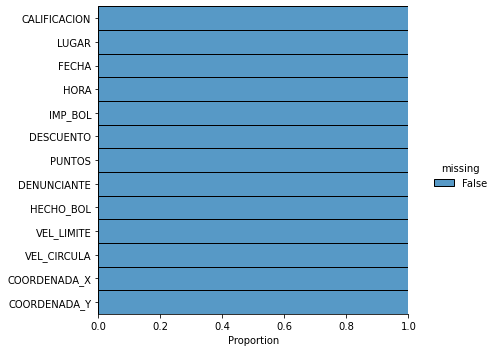

In [33]:
chequeo_datos(multas)

Vemos que no existen valores `nan` en el pandas generado

# Dimensiones y valores singulares de los datos:

Saquemos valores característicos de la serie: 

In [9]:
def kpis(datos,anno='',mes=''):
    if anno!='':
        datos = datos.loc[datos['FECHA'].dt.year==anno,:]
    if mes!='':
        datos = datos.loc[datos['FECHA'].dt.month==mes,:]
    return len(datos),datos.IMP_BOL.max(),datos.IMP_BOL.min(), datos.PUNTOS.max(),datos.PUNTOS.min(),datos.IMP_BOL.sum(), datos.PUNTOS.sum()

    

In [10]:
numero, max_imp,min_imp, max_puntos, min_puntos, total_euros, total_puntos = kpis(multas)
print (f'Máximo importe: {max_imp:,.0f}€; Mínimo importe:{min_imp:,.0f}€; Máximo puntos: {max_puntos}; Mínimo puntos:{min_puntos:,.0f}; Total euros: {total_euros:10,.0f}; Total puntos: {total_puntos:10,.0f}')

Máximo importe: 1,000€; Mínimo importe:30€; Máximo puntos: 6; Mínimo puntos:0; Total euros: 646,624,340; Total puntos:    899,303


y ahora saquemos esos valores característicos por cada mes:

In [11]:
for anno in ANNOS:
    for i,mes in enumerate(MESES):
        numero, max_imp,min_imp, max_puntos, min_puntos, total_euros, total_puntos = kpis(multas,anno=int(anno),mes=i+1)
        print (f'{mes:10} {anno[:2]:2}: {numero:>7,.0f} multas-Máximo importe: {max_imp:,.0f}€-Mínimo importe:{min_imp:,.0f}€-Máximo puntos: {max_puntos}-Mínimo puntos:{min_puntos}-Total euros: {total_euros:>10,.0f}-Total puntos: {total_puntos:6,.0f}')

Enero      20: 170,883 multas-Máximo importe: 1,000€-Mínimo importe:30€-Máximo puntos: 6-Mínimo puntos:0-Total euros: 17,091,150-Total puntos: 19,476
Febrero    20: 161,384 multas-Máximo importe: 1,000€-Mínimo importe:30€-Máximo puntos: 6-Mínimo puntos:0-Total euros: 16,050,420-Total puntos: 20,732
Marzo      20: 163,776 multas-Máximo importe: 1,000€-Mínimo importe:30€-Máximo puntos: 6-Mínimo puntos:0-Total euros: 16,127,640-Total puntos: 21,502
Abril      20: 158,391 multas-Máximo importe: 1,000€-Mínimo importe:30€-Máximo puntos: 6-Mínimo puntos:0-Total euros: 15,706,530-Total puntos: 20,419
Mayo       20: 172,888 multas-Máximo importe: 1,000€-Mínimo importe:30€-Máximo puntos: 6-Mínimo puntos:0-Total euros: 17,207,760-Total puntos: 24,121
Junio      20: 248,483 multas-Máximo importe: 1,000€-Mínimo importe:30€-Máximo puntos: 6-Mínimo puntos:0-Total euros: 23,574,080-Total puntos: 22,143
Julio      20: 253,269 multas-Máximo importe: 1,000€-Mínimo importe:30€-Máximo puntos: 6-Mínimo punt

In [18]:
multas.groupby(['FECHA']).size().mean()

184136.27777777778

In [19]:
multas.groupby(['FECHA'])['IMP_BOL'].sum().mean()

17961787.222222224

In [20]:
multas.groupby(['FECHA'])['PUNTOS'].sum().mean()

24980.63888888889

Y  en media mensual: unas 184k multas, con 17.9m€ de  importe acumulado, y casi 25k puntos....

Empecemos con las visualizaciones de estas multas, recordemos que son tres años, del 2019 al 2021, con la pandemia Covid-19 empezando en Marzo-20..

# Gráficos generales

Veamos varias distribución de multas por meses, y también de los puntos y euros acumulados.

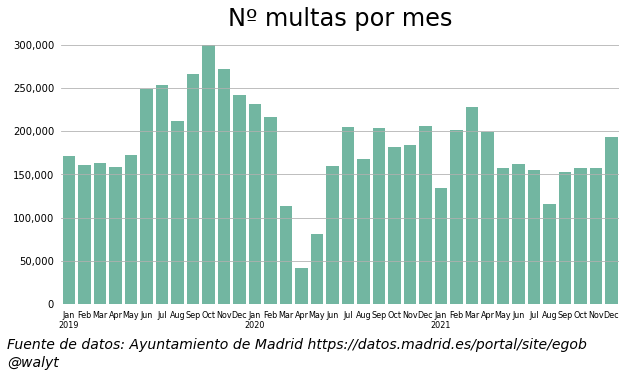

In [21]:
fig = plt.figure(1, (10,5))
ax = fig.add_subplot(1,1,1)
etiquetas_meses_x = [i.strftime('%b') if i.strftime('%-m')!='1' else i.strftime('%b\n%Y') for i in df.groupby(['FECHA']).sum().index]
g = sns.countplot(data=multas,x='FECHA',ax=ax,color=color_multas)
#ax.bar(x=datos['FECHA'],height=datos['PUNTOS'],width=20,align='center')
ax.xaxis_date()
ax.xaxis.set_tick_params(labelsize=8,width=0,labelcolor=color_ejes,rotation=0)
#ax.xaxis.set_major_formatter(XmajorFmt)
#ax.xaxis.set_major_locator(MonthLocator([1,4,7,10]))
ax.yaxis.set_tick_params(labelsize=10,width=0,labelcolor=color_ejes)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x,v:'{:0,.0f}'.format(x)))
ax.set_xticklabels(etiquetas_meses_x)

ax.set_xlabel('',size=16)
ax.set_ylabel('')
#ax.set_ylabel('Número de puntos',size=16)
ax.grid(axis='y')
sns.despine(left=True,bottom=True)
ax.set_title('Nº multas por mes',size=24)

fig.text(x=0.05,y=0.0,s=fuente,color=color_titulos,fontsize=14,ha='left',fontstyle='italic')
fig.text(x=0.05,y=-.05,s=autor,color=color_titulos,fontsize=14,fontstyle='italic')
#fig.suptitle(fuente,size=10,x=1,y=-0.01)
fichero = f'{path_proyecto}{path_img}/multas_mes.png'
fig.savefig(fichero,bbox_inches = 'tight')
plt.show()

Vemos la bajada brutal del número de multas en Marzo, Abril y Mayo del 20, coincidiendo con los momentos más duros de la pandemia.

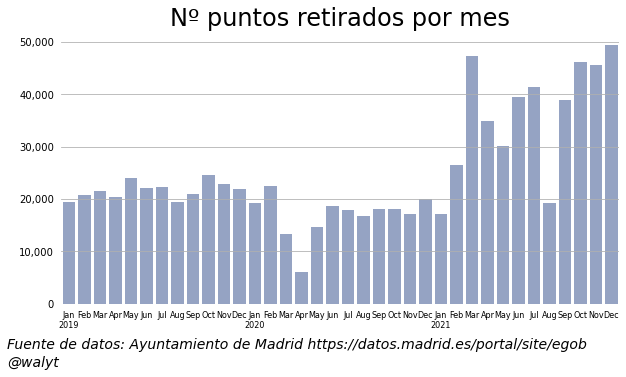

In [22]:
fig = plt.figure(1, (10,5))
ax = fig.add_subplot(1,1,1)
etiquetas_meses_x = [i.strftime('%b') if i.strftime('%-m')!='1' else i.strftime('%b\n%Y') for i in multas.groupby(['FECHA']).sum().index]
g = sns.barplot(data=multas,x='FECHA',y='PUNTOS',ax=ax,color=color_puntos,estimator=sum,ci=None)
ax.xaxis_date()
ax.xaxis.set_tick_params(labelsize=8,width=0,labelcolor=color_ejes,rotation=0)
#ax.xaxis.set_major_formatter(XmajorFmt)
#ax.xaxis.set_major_locator(MonthLocator([1,4,7,10]))
ax.yaxis.set_tick_params(labelsize=10,width=0,labelcolor=color_ejes)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x,v:'{:0,.0f}'.format(x)))
ax.set_xticklabels(etiquetas_meses_x)

ax.set_xlabel('',size=16)
ax.set_ylabel('')
#ax.set_ylabel('Número de puntos',size=16)
ax.grid(axis='y')
sns.despine(left=True,bottom=True)
ax.set_title('Nº puntos retirados por mes',size=24)

fig.text(x=0.05,y=0.0,s=fuente,color=color_titulos,fontsize=14,ha='left',fontstyle='italic')
fig.text(x=0.05,y=-.05,s=autor,color=color_titulos,fontsize=14,fontstyle='italic')
#fig.suptitle(fuente,size=10,x=1,y=-0.01)
fichero = f'{path_proyecto}{path_img}/puntos_mes.png'
fig.savefig(fichero,bbox_inches = 'tight')

En esta gráfica se observa el crecimiento en el nº de puntos retirados en el año 2021, más tarde tendremos la oportunidad de buscar la razón tras ese comportamiento.

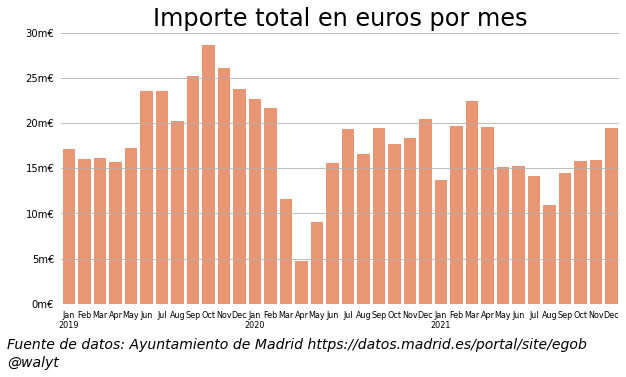

In [23]:

fig = plt.figure(1, (10,5))
ax = fig.add_subplot(1,1,1)
etiquetas_meses_x = [i.strftime('%b') if i.strftime('%-m')!='1' else i.strftime('%b\n%Y') for i in multas.groupby(['FECHA']).sum().index]
g = sns.barplot(data=multas,x='FECHA',y='IMP_BOL',ax=ax,color=color_euros,estimator=sum,ci=None)
ax.xaxis_date()
ax.xaxis.set_tick_params(labelsize=8,width=0,labelcolor=color_ejes,rotation=0)
#ax.xaxis.set_major_formatter(XmajorFmt)
#ax.xaxis.set_major_locator(MonthLocator([1,4,7,10]))
ax.yaxis.set_tick_params(labelsize=10,width=0,labelcolor=color_ejes)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x,v:'{:0,.0f}m€'.format(x/1000000)))
ax.set_xticklabels(etiquetas_meses_x)

ax.set_xlabel('',size=16)
ax.set_ylabel('')
#ax.set_ylabel('Número de puntos',size=16)
ax.grid(axis='y')
sns.despine(left=True,bottom=True)
ax.set_title('Importe total en euros por mes',size=24)

fig.text(x=0.05,y=0.0,s=fuente,color=color_titulos,fontsize=14,ha='left',fontstyle='italic')
fig.text(x=0.05,y=-.05,s=autor,color=color_titulos,fontsize=14,fontstyle='italic')
#fig.suptitle(fuente,size=10,x=1,y=-0.01)
fichero = f'{path_proyecto}{path_img}/euros_mes.png'
fig.savefig(fichero,bbox_inches = 'tight')


También es interesante ver la media de puntos y euros por multas, tanto en la evolución de los meses como en las horas del día.
La librería `seaborn` nos permite fácilmente esta visualización sin necesidad de calcular la media, tan solo indicando que el `estimator` es el operador `mean`, `np.mean` en particular.

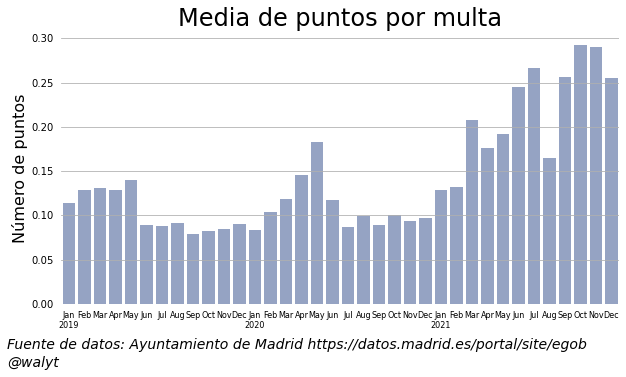

In [24]:
fig = plt.figure(1, (10,5))
ax = fig.add_subplot(1,1,1)
etiquetas_meses_x = [i.strftime('%b') if i.strftime('%-m')!='1' else i.strftime('%b\n%Y') for i in multas.groupby(['FECHA']).sum().index]
g = sns.barplot(data=multas,x='FECHA',y='PUNTOS',ax=ax,color=color_puntos,ci=None,estimator=np.mean)

ax.xaxis_date()
ax.xaxis.set_tick_params(labelsize=8,width=0,labelcolor=color_ejes,rotation=0)
ax.yaxis.set_tick_params(labelsize=10,width=0,labelcolor=color_ejes)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x,v:'{:0,.2f}'.format(x)))
ax.set_xticklabels(etiquetas_meses_x)

ax.set_xlabel('',size=16)
ax.set_ylabel('Número de puntos',size=16)
ax.grid(axis='y')
sns.despine(left=True,bottom=True)
ax.set_title('Media de puntos por multa',size=24)
fig.text(x=0.05,y=0.0,s=fuente,color=color_titulos,fontsize=14,ha='left',fontstyle='italic')
fig.text(x=0.05,y=-.05,s=autor,color=color_titulos,fontsize=14,fontstyle='italic')
#fig.suptitle(fuente,size=10,x=1,y=-0.01)
fichero = f'{path_proyecto}{path_img}/media_puntos_mes.png'
fig.savefig(fichero,bbox_inches = 'tight')

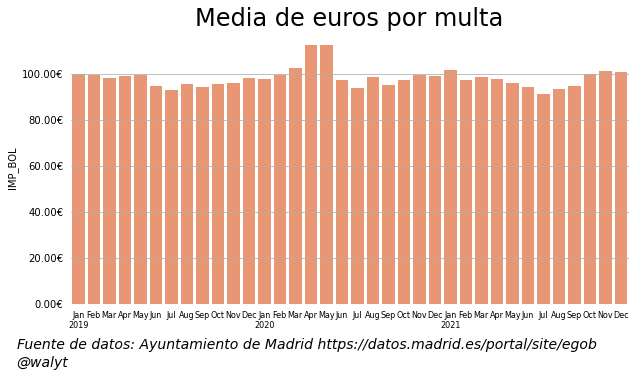

In [15]:
fig = plt.figure(1, (10,5))
ax = fig.add_subplot(1,1,1)
etiquetas_meses_x = [i.strftime('%b') if i.strftime('%-m')!='1' else i.strftime('%b\n%Y') for i in multas.groupby(['FECHA']).sum().index]
g = sns.barplot(data=multas,x='FECHA',y='IMP_BOL',ax=ax,color=color_euros,ci=None,estimator=np.mean)

ax.xaxis_date()
ax.xaxis.set_tick_params(labelsize=8,width=0,labelcolor=color_ejes,rotation=0)
#ax.xaxis.set_major_formatter(XmajorFmt)
#ax.xaxis.set_major_locator(MonthLocator([1,4,7,10]))
ax.yaxis.set_tick_params(labelsize=10,width=0,labelcolor=color_ejes)

ax.yaxis.set_major_formatter(FuncFormatter(lambda x,v:f'{x:0,.2f}€'))
ax.set_xticklabels(etiquetas_meses_x)

ax.set_xlabel('',size=16)
ax.grid(axis='y')
sns.despine(left=True,bottom=True)
ax.set_title('Media de euros por multa',size=24)
fig.text(x=0.05,y=0.0,s=fuente,color=color_titulos,fontsize=14,ha='left',fontstyle='italic')
fig.text(x=0.05,y=-.05,s=autor,color=color_titulos,fontsize=14,fontstyle='italic')
#fig.suptitle(fuente,size=10,x=1,y=-0.01)
fichero = f'{path_proyecto}{path_img}/media_euros_mes.png'
fig.savefig(fichero,bbox_inches = 'tight')

..y ahora por agregamos por horas, para ver el comportamiento durante las 24 horas del día

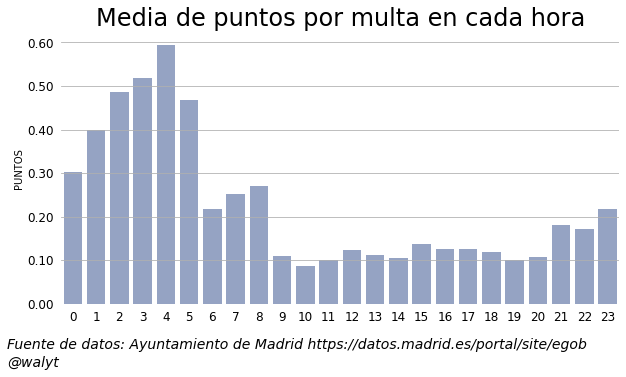

In [16]:
fig = plt.figure(1, (10,5))
ax = fig.add_subplot(1,1,1)

datos = multas[['PUNTOS','HORA']].resample('H',on='HORA').aggregate('mean').reset_index()    #agregamos las multas por cada hora    
datos['HORA'] = datos['HORA'].dt.hour
g = sns.barplot(data=datos,x='HORA',y='PUNTOS',ax=ax,color=color_puntos,ci=None)

ax.xaxis.set_tick_params(labelsize=12,width=0,labelcolor=color_ejes,rotation=0)
ax.yaxis.set_tick_params(labelsize=12,width=0,labelcolor=color_ejes)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x,v:'{:0,.2f}'.format(x)))
ax.set_xlabel('',size=16)
ax.grid(axis='y')
sns.despine(left=True,bottom=True)
ax.set_title('Media de puntos por multa en cada hora',size=24)
fig.text(x=0.05,y=0.0,s=fuente,color=color_titulos,fontsize=14,ha='left',fontstyle='italic')
fig.text(x=0.05,y=-.05,s=autor,color=color_titulos,fontsize=14,fontstyle='italic')
#fig.suptitle(fuente,size=10,x=1,y=-0.01)
fichero = f'{path_proyecto}{path_img}/media_puntos_hora.png'
fig.savefig(fichero,bbox_inches = 'tight')

Vemos que la hora con en la que, de media, se pierden más puntos por multa es entre las 4 y las 5 de la noche, con 0.6 puntos/multa, mientras que entre las 9 y las 20 se pierden en el entorno de 0.1 puntos/multa.

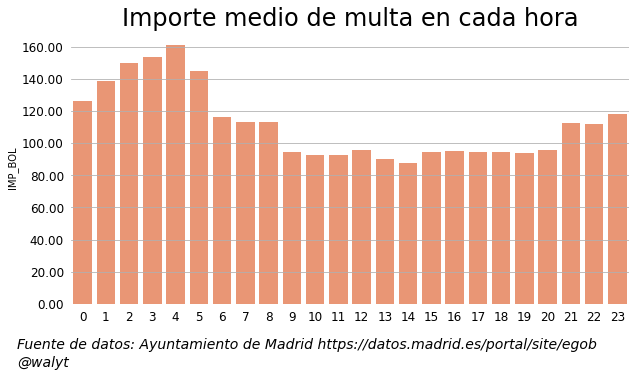

In [17]:
fig = plt.figure(1, (10,5))
ax = fig.add_subplot(1,1,1)

datos = multas[['IMP_BOL','HORA']].resample('H',on='HORA').aggregate('mean').reset_index()        
datos['HORA'] = datos['HORA'].dt.hour
g = sns.barplot(data=datos,x='HORA',y='IMP_BOL',ax=ax,color=color_euros,ci=None)

ax.xaxis.set_tick_params(labelsize=12,width=0,labelcolor=color_ejes,rotation=0)
ax.yaxis.set_tick_params(labelsize=12,width=0,labelcolor=color_ejes)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x,v:'{:0,.2f}'.format(x)))
ax.set_xlabel('',size=16)
ax.grid(axis='y')
sns.despine(left=True,bottom=True)
ax.set_title('Importe medio de multa en cada hora',size=24)
fig.text(x=0.05,y=0.0,s=fuente,color=color_titulos,fontsize=14,ha='left',fontstyle='italic')
fig.text(x=0.05,y=-.05,s=autor,color=color_titulos,fontsize=14,fontstyle='italic')
#fig.suptitle(fuente,size=10,x=1,y=-0.01)
fichero = f'{path_proyecto}{path_img}/media_euros_hora.png'
fig.savefig(fichero,bbox_inches = 'tight')

En el caso de la media de euros por multa sigue un comportamiento similar al de puntos aunque el rango es menor. 160€ es la media de multa entre las 4 y las 5, mientras que durante el día, de 9 a 20, se situa en el entorno de los 90~95€.

He calculado un par de ratios de interés, euros por multa y puntos por multa a lo largo del día, viendo que la media por la noche es significativamente superior a la media del día. Aquí vemos exclusivamente que las multas de la noche traen más euros y quitan as puntos que las multas de día, cosa que parece razonable, en ambos casos vemos que la hora caliente es de 04:00 a 05:00 de la madrugada, con más de 160€ y casi 0.6 puntos por multa.

Veamos ahora un par de gráficas en las cuales no vamos a utilizar series temporales en el eje x, sino el importe de la multa y los puntos retirados como categoría, vemos que fácil se puede codificar con seaborn, no es necesario realizar ningún tratamiento al `pandas` original de datos, simplemente elegir el campo `IMP_BOL` o `PUNTOS`como eje X.

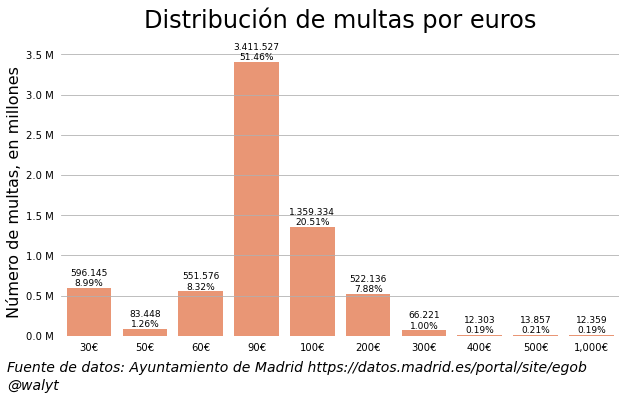

In [18]:
fig = plt.figure(1, (10,5))
ax = fig.add_subplot(1,1,1)
g = sns.countplot(data=multas,x='IMP_BOL',ax=ax,color=color_euros)

ax.xaxis.set_tick_params(labelsize=10,width=0,labelcolor=color_ejes,rotation=0)

ax.yaxis.set_tick_params(labelsize=10,width=0,labelcolor=color_ejes)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x,v:'{:0,.1f} M'.format(x/1000000)))
etiquetas_x = ['{:0,.0f}€'.format(i) for i in list(multas['IMP_BOL'].sort_values().unique())]
ax.set_xticklabels(etiquetas_x)
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x,v:f'{v:0,.0f}€'))
patches=ax.patches
n_multas = multas.shape[0]
for i,rect in enumerate(patches):
    _,y_max = ax.get_ylim()
    height = rect.get_height()
    ax.text(rect.get_x()+rect.get_width()/2,y_max/30+height,'{:0,.0f}\n{:0,.2%}'.format(height,height/n_multas).replace(',','.'),
            ha='center', va='center',fontsize=9,color=color_ejes)

ax.set_xlabel('',size=16)
ax.set_ylabel('')
ax.set_ylabel('Número de multas, en millones',size=16)
ax.grid(axis='y')
sns.despine(left=True,bottom=True)
ax.set_title('Distribución de multas por euros',size=24,x=.5,y=1.05)
fig.text(x=0.05,y=0.0,s=fuente,color=color_titulos,fontsize=14,ha='left',fontstyle='italic')
fig.text(x=0.05,y=-.05,s=autor,color=color_titulos,fontsize=14,fontstyle='italic')
fig.subplots_adjust(top=.9,bottom=.1,wspace=0.1,hspace=0)
fichero = f'{path_proyecto}{path_img}/distri_multas_importe.png'
fig.savefig(fichero,bbox_inches = 'tight')

Vemos como, con mucha diferencia, el importe de 90€ es el más frecuente, con más del 50% con ese importe. Le sigue las multas de 100€ con un 20.5% y las de 30€ con un 9%. Como curiosidad las multas máximas, 1.000€, agregan un 0.2% aproximadamente.

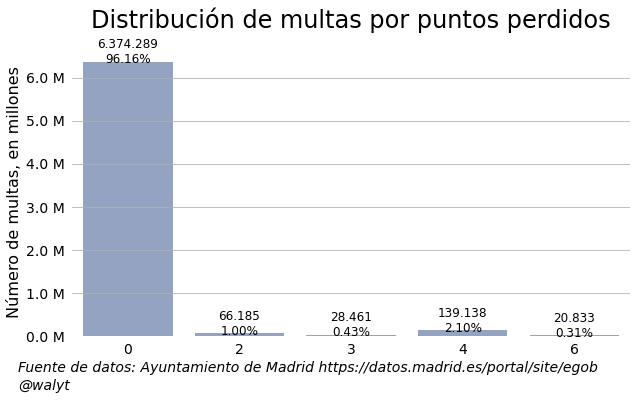

In [19]:
fig = plt.figure(1, (10,5))
ax = fig.add_subplot(1,1,1)
g = sns.countplot(data=multas,x='PUNTOS',ax=ax,color=color_puntos)

ax.xaxis.set_tick_params(labelsize=14,width=0,labelcolor=color_ejes,rotation=0)

ax.yaxis.set_tick_params(labelsize=14,width=0,labelcolor=color_ejes)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x,v:'{:0,.1f} M'.format(x/1000000)))
etiquetas_x = ['{:0,.0f}'.format(i) for i in list(multas['PUNTOS'].sort_values().unique())]
ax.set_xticklabels(etiquetas_x)
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x,v:f'{v:0,.0f}€'))
patches=ax.patches
n_multas = multas.shape[0]
for i,rect in enumerate(patches):
    _,y_max = ax.get_ylim()
    height = rect.get_height()
    ax.text(rect.get_x()+rect.get_width()/2,y_max/30+height,'{:0,.0f}\n{:0,.2%}'.format(height,height/n_multas).replace(',','.'),
            ha='center', va='center',fontsize=12,color=color_ejes)

ax.set_xlabel('',size=16)
ax.set_ylabel('')
ax.set_ylabel('Número de multas, en millones',size=16)
ax.grid(axis='y')
sns.despine(left=True,bottom=True)
ax.set_title('Distribución de multas por puntos perdidos',size=24,x=.5,y=1.05)
fig.text(x=0.05,y=0.0,s=fuente,color=color_titulos,fontsize=14,ha='left',fontstyle='italic')
fig.text(x=0.05,y=-.05,s=autor,color=color_titulos,fontsize=14,fontstyle='italic')
fig.subplots_adjust(top=.9,bottom=.1,wspace=0.1,hspace=0)
fichero = f'{path_proyecto}{path_img}/distri_multas_puntos.png'
fig.savefig(fichero,bbox_inches = 'tight')

y también será interesante ver un heatmap con la distribución de multas por importe y puntos simultáneamente:

In [58]:
multas.shape[0]

6628906

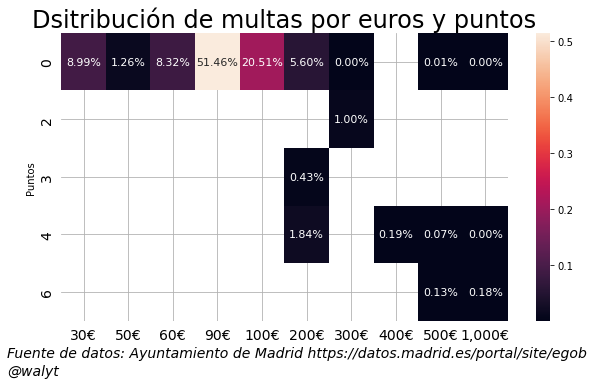

In [64]:
datos = pd.pivot_table(multas[['PUNTOS','IMP_BOL','CALIFICACION']],values='CALIFICACION',index='PUNTOS',columns='IMP_BOL',aggfunc='count')/multas.shape[0]
fig = plt.figure(1, (10,5))
ax = fig.add_subplot(1,1,1)
fmt_pct = '0,.2%'
g = sns.heatmap(data=datos,
                ax=ax,
                annot=True,
                fmt=fmt_pct,
                annot_kws={"size":11},
                )

ax.set_xlabel('',size=16)
ax.set_ylabel('Puntos')
ax.xaxis.set_tick_params(labelsize=14,width=0,labelcolor=color_ejes,rotation=0)
ax.yaxis.set_tick_params(labelsize=14,width=0,labelcolor=color_ejes)
etiquetas_x = ['{:0,.0f}€'.format(i) for i in list(multas['IMP_BOL'].sort_values().unique())]
ax.set_xticklabels(etiquetas_x)
ax.set_axisbelow(True)
ax.grid(axis='both')
sns.despine(left=True,bottom=True)
ax.set_title('Dsitribución de multas por euros y puntos',size=24)
fig.text(x=0.05,y=0.0,s=fuente,color=color_titulos,fontsize=14,ha='left',fontstyle='italic')
fig.text(x=0.05,y=-.05,s=autor,color=color_titulos,fontsize=14,fontstyle='italic')
#fig.suptitle(fuente,size=10,x=1,y=-0.01)
fig.subplots_adjust(top=.9,bottom=.1,wspace=0.1,hspace=0.17)
fichero = f'{path_proyecto}{path_img}/distri_euros_puntos.png'
fig.savefig(fichero,bbox_inches = 'tight')


Vemos como la celda con más elementos es la correspondiente a {90€,0puntos}. Y curiosamente nos encontramos con multas de 1.000€ son pérdida de puntso que entendemos que se debe a un error. Busquemos algunas de este tipo:

In [21]:
multas.loc[(multas['IMP_BOL']==1000) & (multas['PUNTOS']==0),'HECHO_BOL'].unique()

array(['CONDUCIR CON UNA TASA DE ALCOHOLEMIA NO PERMITIDA SUPERIOR A 0.50 MG/L EN AIRE ESPIRADO (0.30 MG/L NOVELES/PROF.)',
       'CONDUCIR CON PRESENCIA DE DROGAS EN EL ORGANISMO.',
       'INCUMPLIR LA OBLIGACIÓNDE SOMETERSE A LAS PRUEBAS DE DETECCIÓN DE ALCOHOL O DE PRESENCIADE DROGAS EN EL ORGANISMO.',
       'CONDUCIR CON UNA TASA DE ALCOHOL NO PERMITIDA SUPERIOR A 0.50 MG/L EN AIRE ESPIRADO (0.30 MG/L NOVELES/PROF.)'],
      dtype=object)

Efectivamente se trata de errores en la trasncripción de la multa, pues todos esos conceptos llevan aparejado pérdida de puntos

# Distribución por horas a los largo de los meses

Como curiosidad vamos a construir una rejilla con los gráficos correspondientes a cada mes, pero con la hora en el eje X, como forzamos a que se utilice la misma escala en el eje y, `sharey=True`, podremos ver la evolución a lo largo de los meses.


/opt/anaconda3/envs/covid/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


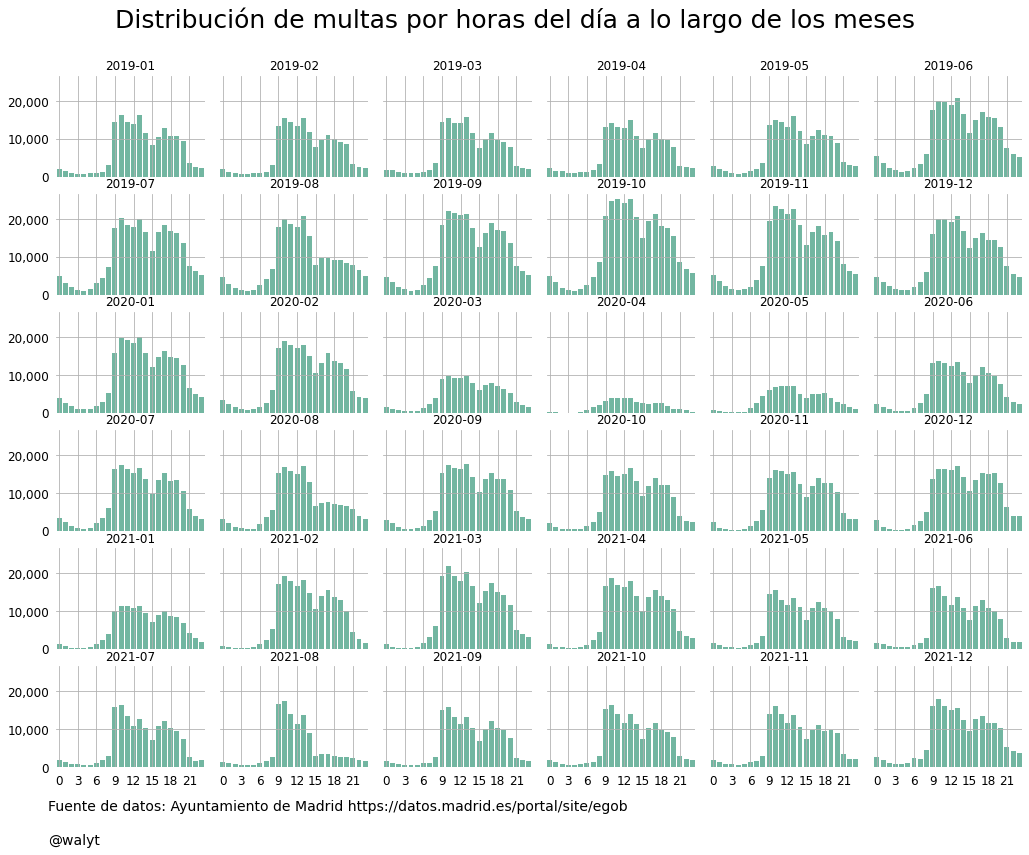

In [66]:
titulo='Distribución de multas por horas del día a lo largo de los meses'
datos_draw = multas.set_index('HORA').groupby(['FECHA']).resample('H')['IMP_BOL'].count().reset_index()
g = sns.catplot(
    data=datos_draw,
    x="HORA", y="IMP_BOL", col="FECHA",
    kind='bar',sharey=True,dodge=True,
    col_wrap=6, height=2, aspect=1.2, legend=False,ci=None,estimator=sum,color=color_multas
)
for col_key,ax in g.axes_dict.items():
    ax.set_title(f"{col_key}"[:7])
for ax in g.axes.flat:
    ax.xaxis_date()
    ax.xaxis.set_tick_params(labelsize=12,width=0,labelcolor=color_ejes,rotation=0)
    #ax.xaxis.set_major_formatter(XmajorFmt)
    #ax.xaxis.set_major_locator(DayLocator([1]))
    ax.yaxis.set_tick_params(labelsize=12,width=0,labelcolor=color_ejes)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x,v:'{:0,.0f}'.format(x)))
    #ax.xaxis.set_major_formatter(FuncFormatter(lambda x,v: str(x)[-8:2]))
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
    #ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    ax.grid(axis='both')
    ax.set_xticks([tick for tick in ax.get_xticks() if tick % 3 == 0])
    ax.set_xticklabels([i.hour for i in pd.to_datetime(datos_draw['HORA'].unique()[::3])])

g.fig.suptitle('{}'.format(titulo),fontsize=25,color=color_titulos)
g.fig.text(x=0.05,y=.05,s=fuente,color='black',fontsize=14,ha='left')
g.fig.text(x=0.05,y=.01,s=autor,color='black',fontsize=14)
# Tweak the supporting aspects of the plot
g.despine(bottom=True,left=True)
#g.set_titles(col_template="{col_name}",size=12)
g.set_axis_labels("", "")
g.tight_layout()
g.fig.subplots_adjust(top=.9,bottom=.1,wspace=0.1,hspace=0.17)
fichero = f'{path_proyecto}{path_img}/distri_multas_horas_meses.png'
g.fig.savefig(fichero,bbox_inches = 'tight')


Como cosas curiosas mencionaría:
 - Lo que ya hemos visto en otras gráficas anteriores, el bajón de la época dura de la pandemia
 - El bajón de Enero del 2021, por el efecto Filomena
 - El cambio de perfil de Agosto-21, respecto a Agosto 20 y 19. Valdrá la pena buscar la razón.

/opt/anaconda3/envs/covid/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


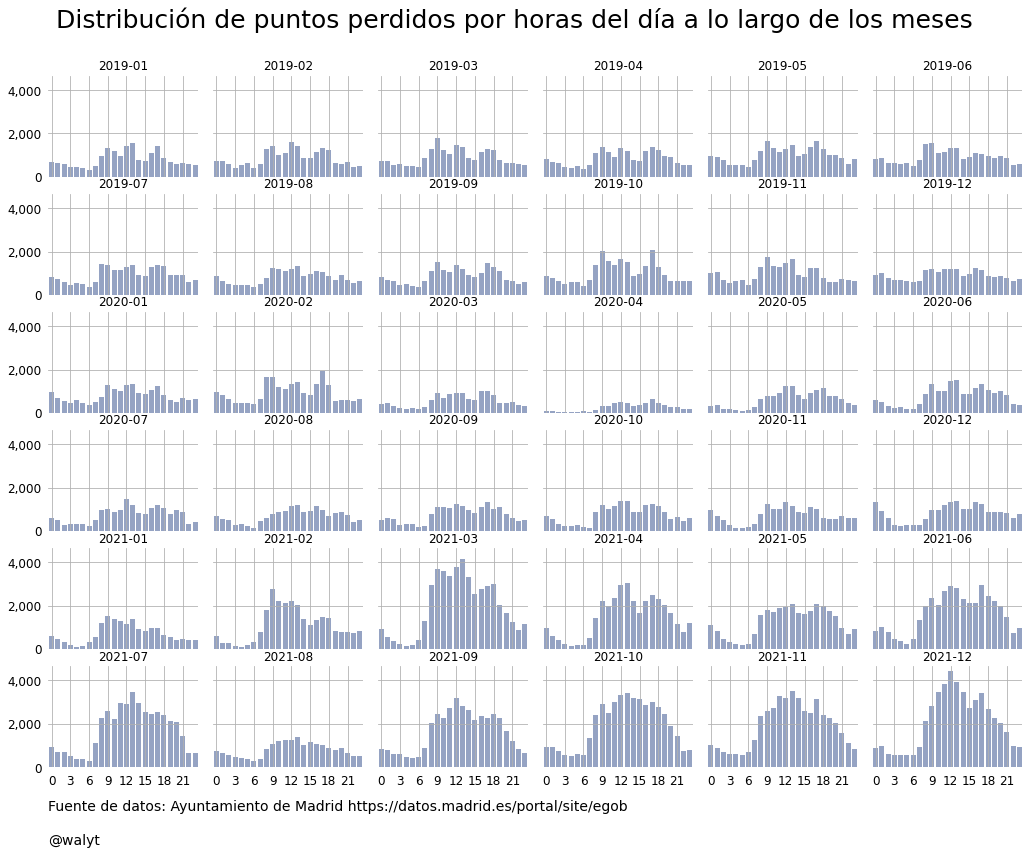

In [67]:
titulo='Distribución de puntos perdidos por horas del día a lo largo de los meses'
datos_draw = multas.set_index('HORA').groupby(['FECHA']).resample('H')['PUNTOS'].sum().reset_index()
g = sns.catplot(
    data=datos_draw,
    x="HORA", y="PUNTOS", col="FECHA",dodge=True,
    kind='bar',sharey=True,
    col_wrap=6, height=2, aspect=1.2, legend=False,ci=None,estimator=sum,color=color_puntos
)
for col_key,ax in g.axes_dict.items():
    ax.set_title(f"{col_key}"[:7])
for ax in g.axes.flat:
    ax.xaxis_date()
    ax.xaxis.set_tick_params(labelsize=12,width=0,labelcolor='black',rotation=0)
    #ax.xaxis.set_major_formatter(XmajorFmt)
    #ax.xaxis.set_major_locator(DayLocator([1]))
    ax.yaxis.set_tick_params(labelsize=12,width=0,labelcolor='black')
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x,v:'{:0,.0f}'.format(x)))
    #ax.xaxis.set_major_formatter(FuncFormatter(lambda x,v: str(x)[-8:2]))
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
    #ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    ax.grid(axis='both')
    ax.set_xticks([tick for tick in ax.get_xticks() if tick % 3 == 0])
    ax.set_xticklabels([i.hour for i in pd.to_datetime(datos_draw['HORA'].unique()[::3])])

g.fig.suptitle('{}'.format(titulo),fontsize=25,color='black')
g.fig.text(x=0.05,y=.05,s=fuente,color='black',fontsize=14,ha='left')
g.fig.text(x=0.05,y=.01,s=autor,color='black',fontsize=14)
# Tweak the supporting aspects of the plot
g.despine(bottom=True,left=True)
#g.set_titles(col_template="{col_name}",size=12)
g.set_axis_labels("", "")
g.tight_layout()
g.fig.subplots_adjust(top=.9,bottom=.1,wspace=0.1,hspace=0.17)
fichero = f'{path_proyecto}{path_img}/distri_puntos_horas_meses.png'
g.fig.savefig(fichero,bbox_inches = 'tight')
    

Y en la misma gráfica, pero mostrando puntos en vez de multas, podemos observar el mismo efecto que ya hemos visto antes. Como se incrementa el número de puntos perdidos desde Marzo 2023.

# Análisis multas por tipo

Vamos a estudiar ahora la distribución de las multas por los conceptos descritos en el campo `HECHO_BOL`. Sabemos que el texto asociado no está normalizada, nos encontramos con muchas variaciones sobre los mismos. 

In [66]:
multas['HECHO_BOL'].unique().size

4142

...en efecto, nos encontramos con más de 4.000 descripciones diferentes. Con el objetivo de simplificar las visualizaciones vamos a obtener la lista con los HECHOS_BOL, y el número de apariciones, ordenamos descendente, y nos quedamos con el top. Digamos con los 50 primeros. Luego veremos si este filtro afecta a un número significativo del número total de multas..es decir: las multas filtradas con este criterio siguen siendo una muestra significativa del total?

In [67]:
(
    multas. # dataframe original
    groupby('HECHO_BOL'). #agrupamos por HECHO_BOL
    size(). #calculamos la cantidad de cada HECHO_BOL
    to_frame('size'). #renombramos la nueva columna con el nombre size
    sort_values(by='size',ascending=False). #la ordenamos por tamaño descendente
    assign(contribucion=lambda x:x.sum(axis=1)/x.sum(axis=1).sum()). #calculamos una nueva columna con el porcentaje de cada tamaño sobre el total
    cumsum(axis=0). #acumulamos esos porcentajes
    head(50) #nos quedamos con los 20 primeros
)

,size,contribucion
HECHO_BOL,,
ACCEDER A MADRID CENTRAL SIN AUTORIZACIÓN.,1482655,0.22
SOBREPASAR LA VELOCIDAD MÁXIMA EN VÍAS LIMITADAS EN 60 KM/H O MÁS.,2579237,0.39
"ESTACIONAR, SIN LA CORRESPONDIENTE AUTORIZACIÓN, EN LUGAR HABILITADO PARA EL ESTACIONAMIENTO CON LIMITACIÓN HORARIA.",3648265,0.55
ESTACIONAR CON AUTORIZACIÓN NO VÁLIDA.,4133695,0.62
"ESTACIONAR CON AUTORIZACIÓN EN LUGAR HABILITADO PARA EL ESTACIONAMIENTO CON LIMITACIÓNHORARIA,REBASANDO EL TIEMPO MÁXIMO",4601014,0.69
ESTACIONAR EN LUGAR PROHIBIDO.,4936585,0.74
SOBREPASAR LA VELOCIDAD MÁXIMA EN VÍAS LIMITADAS HASTA 50 KM/H.,5157450,0.78
SOBREPASAR LA VELOCIDAD MEDIA EN TRAMO CONTROLADO.,5364508,0.81
ESTACIONAR EN CARRIL DE CIRCULACIÓN.,5501918,0.83


In [68]:
multas_hecho = list(multas.groupby('HECHO_BOL').size().to_frame('size').sort_values(by='size',ascending=False).assign(contribucion=lambda x:x.sum(axis=1)/x.sum(axis=1).sum()).cumsum(axis=0).head(50).index)

Ya tenemos la lista con los `HECHO_BOL` frecuentes: 20, que abarcan el 94% de las multas. Creemos que es un buen ratio para simplificar. Ahora vamos 

In [69]:
multas.loc[multas['HECHO_BOL'].isin(multas_hecho),:].shape[0] / multas.shape[0]

0.9877288952355034

In [70]:
multas.loc[multas['HECHO_BOL'].isin(multas_hecho),'IMP_BOL'].sum() / multas['IMP_BOL'].sum()

0.9736619410274596

In [71]:
multas.loc[multas['HECHO_BOL'].isin(multas_hecho),'PUNTOS'].sum() / multas['PUNTOS'].sum()

0.9086470299776604

Con este filtro tendriamos el 98.8% de las multas (6.29m/6,62m), el 817149/899303 = 90.8% de los puntos totales, y el 629.6/646.6 = 97.3% de los euros. Hay disparidad en esos porcentajes, luego probablemente nos encontremos con algun sesgo en el resultado. Veamos si es así:

Para resumir los resultados vamos a agrupar cada uno de los ***HECHOS_BOL*** en unas "supercategorias": 
- Velocidad
- Estacionamiento Indebido
- Circulación Indebida
- Semáforo
- Alcohol
- Uso móvil
- Acceso Madrid Central

Así podremos preparar gráficas en las que fácilmente se pueda ver la evolución. Denominaremos este nuevo campo como ***HECHO_BOL_resumido***, este trabajo, me temo, no se puede hacer sino a mano. Preparamos un nuevo diccionario con las multas_hecho que hemos calculado, funcionando estas como clave y  añadiendo el atributo de la supercategoría como valor:

In [72]:
hechos_top = {'ACCEDER A MADRID CENTRAL SIN AUTORIZACIÓN.':'Acceso Madrid Central',
 'SOBREPASAR LA VELOCIDAD MÁXIMA EN VÍAS LIMITADAS EN 60 KM/H O MÁS.':'Velocidad',
 'ESTACIONAR, SIN LA CORRESPONDIENTE AUTORIZACIÓN, EN LUGAR HABILITADO PARA EL ESTACIONAMIENTO CON LIMITACIÓN HORARIA.':'Estacionamiento Indebido',
 'ESTACIONAR CON AUTORIZACIÓN NO VÁLIDA.':'Estacionamiento Indebido',
 'ESTACIONAR CON AUTORIZACIÓN EN LUGAR HABILITADO PARA EL ESTACIONAMIENTO CON LIMITACIÓNHORARIA,REBASANDO EL TIEMPO MÁXIMO':'Estacionamiento Indebido',
 'ESTACIONAR EN LUGAR PROHIBIDO.':'Estacionamiento Indebido',
 'SOBREPASAR LA VELOCIDAD MÁXIMA EN VÍAS LIMITADAS HASTA 50 KM/H.':'Velocidad',
 'SOBREPASAR LA VELOCIDAD MEDIA EN TRAMO CONTROLADO.':'Velocidad',
 'ESTACIONAR EN CARRIL DE CIRCULACIÓN.':'Estacionamiento Indebido',
 'ESTACIONAR SOBRE LA ACERA.':'Estacionamiento Indebido',
 'ESTACIONAR EN LUGAR PROHIBIDO. VEHÍCULO DE CATEGORÍA AMBIENTAL A EN ZONA SER.':'Estacionamiento Indebido',
 'REBASAR UN SEMÁFORO EN FASE ROJA.':'Semáforo',
 'ESTACIONAR EN DOBLE FILA.':'Estacionamiento Indebido',
 'ESTACIONAR EN ZONA SEŃALIZADA PARA USO EXCLUSIVO DE PERSONAS CON MOVILIDAD REDUCIDA.':'Estacionamiento Indebido',
 'ESTACIONAR OBSTACULIZANDO LA UTILIZACIÓN DE UN VADO SEŃALIZADO CORRECTAMENTE.':'Estacionamiento Indebido',
 'ESTACIONAR EN ZONA Y HORARIO DE CARGA Y DESCARGA SIN REALIZAR OPERACIONES CON ESA FINALIDAD.':'Estacionamiento Indebido',
 'ESTACIONAR SOBRE LA ACERA OBSTACULIZANDO GRAVEMENTE EL TRÁNSITO DE PEATONES.':'Estacionamiento Indebido',
 'ESTACIONAR EN CARRIL DECIRCULACIÓN OBSTACULIZANDO GRAVEMENTE LA CIRCULACIÓN.':'Estacionamiento Indebido',
 'ESTACIONAR EN CARRIL RESERVADO PARA USO, PARADA O ESTACIONAMIENTO EXCLUSIVO DEL TRANSPORTE PÚBLICO URBANO.':'Estacionamiento Indebido',
 'ESTACIONAR MOTOCICLETA O CICLOMOTOR SOBRE LA ACERA DE FORMA ANTIRREGLAMENTARIA.':'Estacionamiento Indebido',
 'ESTACIONAR SUPERANDO ELTIEMPO PERMITIDO EN ZONA DE CARGAY DESCARGA DURANTE LAS HORAS FIJADAS PARA SU USO.':'Estacionamiento Indebido',
 'CONDUCIR UTILIZANDO MANUALMENTE TELEFONÍA MÓVIL, NAVEGADOR O SISTEMA DE COMUNICACIÓN ODETECCIÓN DE RADAR.':'Uso móvil',
 'ESTACIONAR EN INTERSECCIÓN OBSTACULIZANDO GRAVEMENTE LACIRCULACIÓN.':'Estacionamiento Indebido',
 'ESTACIONAR OBSTACULIZANDO LA UTILIZACIÓN NORMAL DE UNPASO DE PEATONES.':'Estacionamiento Indebido',
 'ESTACIONAR EN PARQUE O ZONA VERDE FUERA DE LAS ZONAS AUTORIZADAS PARA ELLO.':'Estacionamiento Indebido',
 'EFECTUAR UN CAMBIO DE DIRECCIÓN PROHIBIDO.':'Circulación Indebida',
 'ESTACIONAR INCUMPLIENDOLAS RESTRICCIONES ESTABLECIDAS POR ALTA CONTAMINACIÓN.':'Estacionamiento Indebido',
 'ESTACIONAR EN MEDIO DE LA CALZADA OBSTACULIZANDO GRAVEMENTE LA CIRCULACIÓN.':'Estacionamiento Indebido',
 'CONDUCIR CON UNA TASA DE ALCOHOLEMIA NO PERMITIDA SUPERIOR A 0.50 MG/L EN AIRE ESPIRADO (0.30 MG/L NOVELES/PROF.)':'Alcohol',
 'ESTACIONAR EN LUGAR PROHIBIDO DEBIDAMENTE SEŃALIZADO. ZONA RESERVADA':'Estacionamiento Indebido',
 'ESTACIONAR SOBRE O JUNTO A ELEMENTOS CANALIZADORES DEL TRÁFICO OBSTACULIZANDO GRAVEMENTELA CIRCULACIÓN.':'Estacionamiento Indebido',
 'EFECTUAR UN CAMBIO DE SENTIDO PROHIBIDO.':'Circulación Indebida',
 'ESTACIONAR UN VEHÍCULO SIN PERMITIR LA MEJOR UTILIZACIÓNDEL RESTANTE ESPACIO DISPONIBLE PARA LOS DEMÁS USUARIOS.':'Estacionamiento Indebido',
 'ESTACIONAR MOTOCICLETA O CICLOMOTOR SOBRE LA ACERA OBSTACULIZANDO GRAVEMENTE EL TRÁNSITO DE PEATONES.':'Estacionamiento Indebido',
 'NO RESPETAR LA SEŃALIZACIÓN.':'Circulación Indebida',
 'ESTACIONAR DIFICULTANDOEL GIRO O IMPIDIENDO EL PASO DE VEHÍCULOS.':'Estacionamiento Indebido',
 'ESTACIONAR EN LUGAR PROHIBIDO DEBIDAMENTE SEŃALIZADO. RESERVA CARGA Y DESCARGA EN HORAS UTILIZACIÓN':'Estacionamiento Indebido',
 'CIRCULAR POR UN CARRIL DE CIRCULACIÓN RESERVADA.':'Circulación Indebida',
 'CIRCULAR EN SENTIDO CONTRARIO AL ESTABLECIDO.':'Circulación Indebida',
 'CONDUCIR CON UNA TASA DE ALCOHOLEMIA NO PERMITIDA DE HASTA 0.50 MG/L EN AIRE ESPIRADO (0.30 MG/L NOVELES/PROFESIONALES)':'Alcohol',
 'NO RESPETAR LAS SEŃALES EN UNA VÍA DE CIRCULACIÓN RESTRINGIDA O RESERVADA.':'Circulación Indebida',
 'ESTACIONAR EN LUGAR RESERVADO TEMPORALMENTE PARA OTROS USOS SEŃALIZADO AL MENOS CON 48 HORAS DE ANTELACIÓN.':'Estacionamiento Indebido',
 'ESTACIONAR VEHÍCULO DE MOVILIDAD URBANA EN LUGAR NO PERMITIDO O DE FORMA ANTIRREGLAMENTARIA':'Estacionamiento Indebido',
 'ESTACIONAR EN SENTIDO CONTRARIO AL SENTIDO DE LA MARCHA.':'Estacionamiento Indebido',
 'ESTACIONAR EN LUGAR PROHIBIDO DEBIDAMENTE SEŃALIZADO':'Estacionamiento Indebido',
 'PARAR EN UN CARRIL DE CIRCULACIÓN.':'Circulación Indebida',
 'CIRCULAR POR ZONA RESERVADA AL USO EXCLUSIVO DE PEATONES.':'Circulación Indebida',
 'ESTACIONAR OBSTACULIZANDO LA UTILIZACIÓN DE ZONAS O PASOS REBAJADOS.':'Estacionamiento Indebido',
 'PARAR EN ZONA RESERVADAPARA USO EXCLUSIVO DEL TRANSPORTEPÚBLICO URBANO, OBSTACULIZANDO GRAVEMENTE LA CIRCULACIÓN.':'Estacionamiento Indebido',
 'ESTACIONAR EN LUGAR PROHIBIDO DEBIDAMENTE SEŃALIZADO. PLACAS QUE PROHIBEN EL ESTACIONAMIENTO' :'Estacionamiento Indebido',        
 'ESTACIONAR BICICLETA ENLUGAR NO PERMITIDO.':'Estacionamiento Indebido',
 'ACCEDER A LA ZBEDEP DISTRITO CENTRO SIN AUTORIZACIÓN':'Acceso Madrid Central',
 'ESTACIONAR VEHÍCULO DE MOVILIDAD PERSONAL EN LUGAR NO PERMITIDO O DE FORMA ANTIRREGLAMENTARIA':'Estacionamiento Indebido',
}

In [73]:
multas.loc[multas['HECHO_BOL'].isin(multas_hecho),:].apply(lambda x:hechos_top[x['HECHO_BOL']],axis=1)

6628905    Estacionamiento Indebido
6514986    Estacionamiento Indebido
6514985    Estacionamiento Indebido
6514984    Estacionamiento Indebido
6514983    Estacionamiento Indebido
                     ...           
129077                    Uso móvil
129076                    Uso móvil
129074         Circulación Indebida
129083                    Uso móvil
0          Estacionamiento Indebido
Length: 6547562, dtype: object

In [74]:
def hecho_bol_resumido(df,filtro):
    return df.assign(HECHO_BOL_resumido=df.apply(lambda x:hechos_top[x['HECHO_BOL']],axis=1))

In [75]:
datos = multas.loc[multas['HECHO_BOL'].isin(multas_hecho),:].pipe(hecho_bol_resumido,hechos_top)

Chequeamos que se ha hecho correctamente, y en su caso el número de multas por cada nueva categoría:

In [76]:
datos['HECHO_BOL_resumido'].unique()

array(['Estacionamiento Indebido', 'Semáforo', 'Circulación Indebida',
       'Uso móvil', 'Velocidad', 'Alcohol', 'Acceso Madrid Central'],
      dtype=object)

In [77]:
datos['HECHO_BOL_resumido'].value_counts()

Estacionamiento Indebido    3316019
Velocidad                   1524505
Acceso Madrid Central       1514548
Semáforo                     119603
Circulación Indebida          46486
Uso móvil                     16307
Alcohol                       10094
Name: HECHO_BOL_resumido, dtype: int64

También podríamos contestar a preguntas tipo: dentro de una categoría: ¿como se comportan los HECHOS_BOL originales?. Fácillmente podemos crear un ***dataframe*** auxiliar y respresentarlo en un gráfico. Hagámoslo como ejemplo para el caso de ***Circulación Indebida***

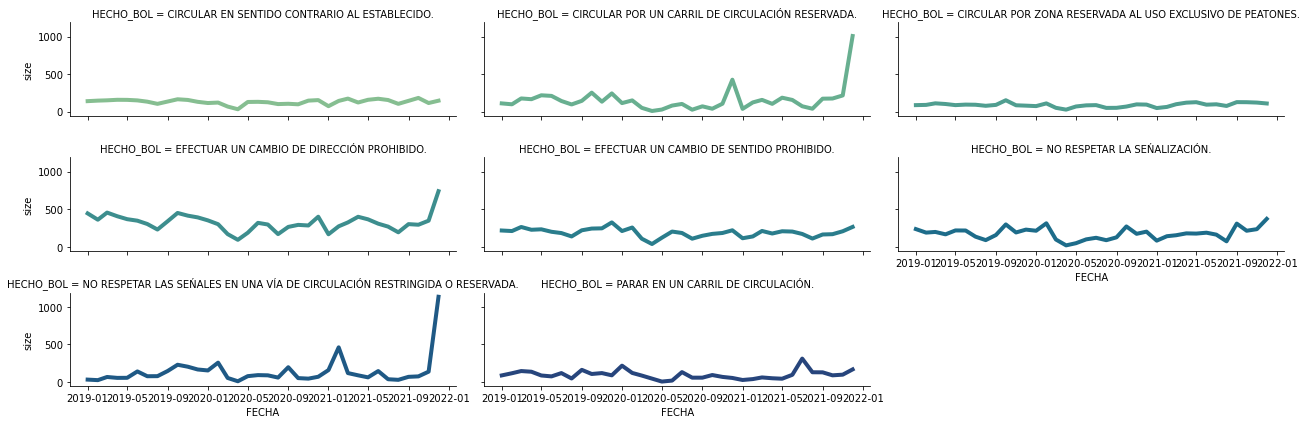

In [37]:
g = sns.relplot(
    data=(datos.
 loc[datos['HECHO_BOL_resumido']=='Circulación Indebida',:].
 groupby(['FECHA','HECHO_BOL']).
 size().
 to_frame('size').
 reset_index()),
    x="FECHA", y='size', hue="HECHO_BOL",col='HECHO_BOL',
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=2, aspect=3, legend=False,
)

ya estamos listos para contestar a la pregunta : ¿como se comporta el nº de multas, puntos y euros de cada una de las 7 categorías a los largo de los meses?. Preparemos una rejilla para ver cada una de las tres dimensiones: número de multas, euros y puntos perdidos:

<Figure size 720x360 with 0 Axes>

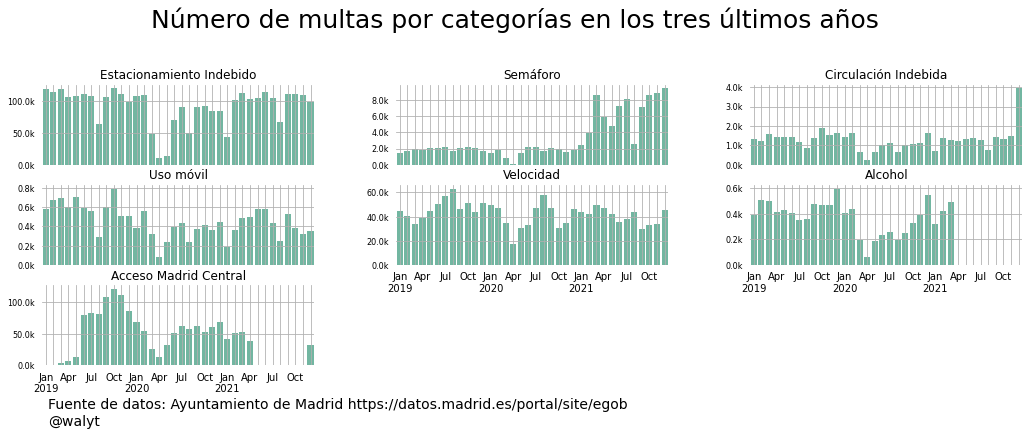

In [78]:
titulo='Número de multas por categorías en los tres últimos años'
fig = plt.figure(1, (10,5))
g = sns.catplot(
    data=datos,x='FECHA',
    col="HECHO_BOL_resumido",
    kind='count',dodge=True,
    col_wrap=3, height=2, aspect=2.4, legend=False,ci=None,estimator=sum,color=color_multas,sharey=False
)

#g = sns.FacetGrid(data=datos, col="HECHO_BOL",hue='HECHO_BOL',col_wrap=3,height=2,aspect=2.2,sharey=False)
#g.map_dataframe(sns.scatterplot, x='FECHA',y='LUGAR')

for ax in g.axes.flat:
    #ax.xaxis_date()
    ax.xaxis.set_tick_params(labelsize=10,width=0,labelcolor=color_ejes,rotation=0)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x,v:'{}'.format(etiquetas_meses_x[x]) if x%3==0 else ''))
    
    #ax.xaxis.set_major_locator(DayLocator([1]))
    ax.yaxis.set_tick_params(labelsize=8,width=0,labelcolor=color_ejes)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x,v:'{:0,.1f}k'.format(x/1000).replace(',','.')))
    ax.grid(True)
    #ax.set_xticklabels(etiquetas_x)
    #ax.set_xticks([tick for tick in ax.get_xticks() if tick % 4 == 0])
    #ax.set_yticklabels([i[:10] for i in multas_hecho])
g.fig.suptitle('{}'.format(titulo),fontsize=25,color=color_titulos)
g.fig.text(x=0.05,y=.05,s=fuente,color=color_titulos,fontsize=14,ha='left')
g.fig.text(x=0.05,y=.01,s=autor,color=color_titulos,fontsize=14)
# Tweak the supporting aspects of the plot
g.despine(bottom=True,left=True)
g.set_titles(col_template="{col_name}",size=12)
g.set_axis_labels("", "")
g.tight_layout()
g.fig.subplots_adjust(top=.8,bottom=.15,wspace=0.3,hspace=0.25)
plt.savefig('distri_tiposmultas_meses.png',dpi=288)  

Vaya, todo parece correcto, salvo la desaparición de las multas por ***Alcohol*** desde Abril-21. Para ver que ha ocurrido vamos a crear la  rejilla, que hemos visto en el penúltimo gráfico con los ***HECHOS_BOL*** relacionados con *Alcohol* y como se comportan a lo largo del tiempo:

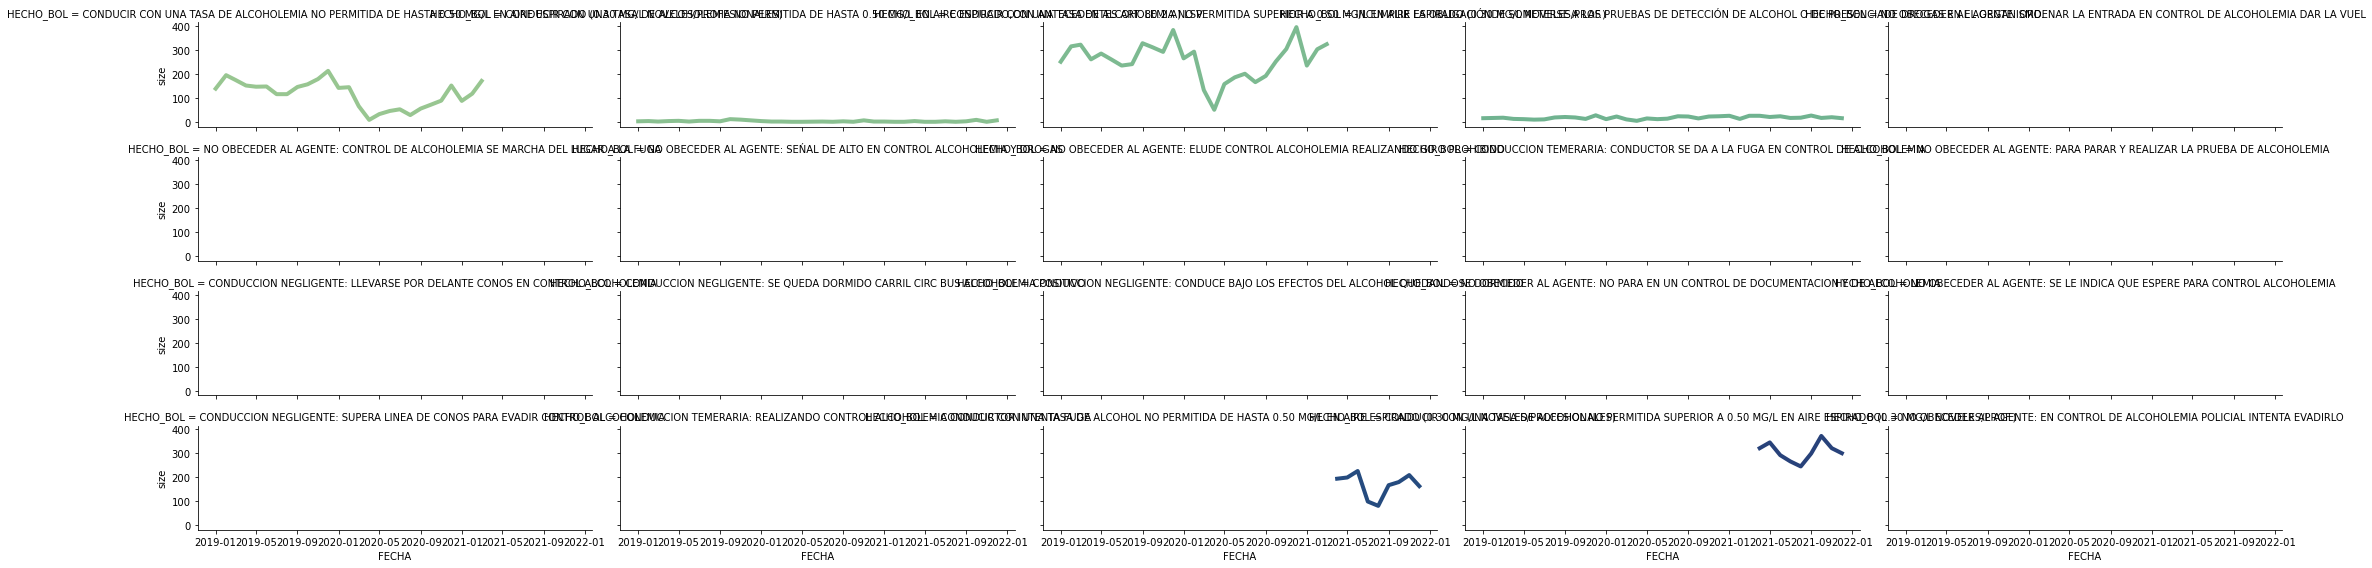

In [79]:
g = sns.relplot(
    data=(multas.
 loc[multas['HECHO_BOL'].str.contains('ALCOHOL'),:].
 groupby(['FECHA','HECHO_BOL']).
 size().
 to_frame('size').
 reset_index()),
    x="FECHA", y='size', hue="HECHO_BOL",col='HECHO_BOL',
    kind="line", palette="crest", linewidth=4, zorder=5,
    height=2, aspect=3, legend=False,col_wrap=5
)

Aunque no se ve muy bien, sí podemos comprobar que han aparecido un par de nuevos **HECHO_BOL** en los últimos meses, que han quedado fuera del filtro que hemos ejecutado al principio de este apartado. Para solucionarlo vamos a añadir todos los HECHOS_BOL de **Alcohol** a la lista del filtro:

In [80]:
hechos_alcohol = multas.loc[multas['HECHO_BOL'].str.contains('ALCOHOL'),'HECHO_BOL'].unique()

In [81]:
hechos_alcohol

array(['CONDUCIR CON UNA TASA DE ALCOHOLEMIA NO PERMITIDA SUPERIOR A 0.50 MG/L EN AIRE ESPIRADO (0.30 MG/L NOVELES/PROF.)',
       'INCUMPLIR LA OBLIGACIÓNDE SOMETERSE A LAS PRUEBAS DE DETECCIÓN DE ALCOHOL O DE PRESENCIADE DROGAS EN EL ORGANISMO.',
       'CONDUCIR CON UNA TASA DE ALCOHOLEMIA NO PERMITIDA DE HASTA 0.50 MG/L EN AIRE ESPIRADO (0.30 MG/L NOVELES/PROFESIONALES)',
       'CONDUCIR CON UNA TASA DE ALCOHOLEMIA NO PERMITIDA DE HASTA 0.50 MG/L EN AIRE ESPIRADO,CON ANTECEDENTES ART. 80.2.A) LSV.',
       'NO OBECEDER AL AGENTE: ORDENAR LA ENTRADA EN CONTROL DE ALCOHOLEMIA DAR LA VUEL',
       'NO OBECEDER AL AGENTE: CONTROL DE ALCOHOLEMIA SE MARCHA DEL LUGAR A LA FUGA',
       'NO OBECEDER AL AGENTE: SEŃAL DE ALTO EN CONTROL ALCOHOLEMIA Y DROGAS',
       'NO OBECEDER AL AGENTE: ELUDE CONTROL ALCOHOLEMIA REALIZANDO GIRO PROHIBIDO',
       'CONDUCCION TEMERARIA: CONDUCTOR SE DA A LA FUGA EN CONTROL DE ALCOHOLEMIA',
       'NO OBECEDER AL AGENTE: PARA PARAR Y REALIZAR LA PRUEBA DE 

Añadimos estos nuevos hechos relacionados con *Alcohol* a la lista original, y actualizamos el diccionario:

In [82]:
multas_hecho = multas_hecho + list(hechos_alcohol)

In [83]:
hechos_top = {'ACCEDER A MADRID CENTRAL SIN AUTORIZACIÓN.':'Acceso Madrid Central',
 'SOBREPASAR LA VELOCIDAD MÁXIMA EN VÍAS LIMITADAS EN 60 KM/H O MÁS.':'Velocidad',
 'ESTACIONAR, SIN LA CORRESPONDIENTE AUTORIZACIÓN, EN LUGAR HABILITADO PARA EL ESTACIONAMIENTO CON LIMITACIÓN HORARIA.':'Estacionamiento Indebido',
 'ESTACIONAR CON AUTORIZACIÓN NO VÁLIDA.':'Estacionamiento Indebido',
 'ESTACIONAR CON AUTORIZACIÓN EN LUGAR HABILITADO PARA EL ESTACIONAMIENTO CON LIMITACIÓNHORARIA,REBASANDO EL TIEMPO MÁXIMO':'Estacionamiento Indebido',
 'ESTACIONAR EN LUGAR PROHIBIDO.':'Estacionamiento Indebido',
 'SOBREPASAR LA VELOCIDAD MÁXIMA EN VÍAS LIMITADAS HASTA 50 KM/H.':'Velocidad',
 'SOBREPASAR LA VELOCIDAD MEDIA EN TRAMO CONTROLADO.':'Velocidad',
 'ESTACIONAR EN CARRIL DE CIRCULACIÓN.':'Estacionamiento Indebido',
 'ESTACIONAR SOBRE LA ACERA.':'Estacionamiento Indebido',
 'ESTACIONAR EN LUGAR PROHIBIDO. VEHÍCULO DE CATEGORÍA AMBIENTAL A EN ZONA SER.':'Estacionamiento Indebido',
 'REBASAR UN SEMÁFORO EN FASE ROJA.':'Semáforo',
 'ESTACIONAR EN DOBLE FILA.':'Estacionamiento Indebido',
 'ESTACIONAR EN ZONA SEŃALIZADA PARA USO EXCLUSIVO DE PERSONAS CON MOVILIDAD REDUCIDA.':'Estacionamiento Indebido',
 'ESTACIONAR OBSTACULIZANDO LA UTILIZACIÓN DE UN VADO SEŃALIZADO CORRECTAMENTE.':'Estacionamiento Indebido',
 'ESTACIONAR EN ZONA Y HORARIO DE CARGA Y DESCARGA SIN REALIZAR OPERACIONES CON ESA FINALIDAD.':'Estacionamiento Indebido',
 'ESTACIONAR SOBRE LA ACERA OBSTACULIZANDO GRAVEMENTE EL TRÁNSITO DE PEATONES.':'Estacionamiento Indebido',
 'ESTACIONAR EN CARRIL DECIRCULACIÓN OBSTACULIZANDO GRAVEMENTE LA CIRCULACIÓN.':'Estacionamiento Indebido',
 'ESTACIONAR EN CARRIL RESERVADO PARA USO, PARADA O ESTACIONAMIENTO EXCLUSIVO DEL TRANSPORTE PÚBLICO URBANO.':'Estacionamiento Indebido',
 'ESTACIONAR MOTOCICLETA O CICLOMOTOR SOBRE LA ACERA DE FORMA ANTIRREGLAMENTARIA.':'Estacionamiento Indebido',
 'ESTACIONAR SUPERANDO ELTIEMPO PERMITIDO EN ZONA DE CARGAY DESCARGA DURANTE LAS HORAS FIJADAS PARA SU USO.':'Estacionamiento Indebido',
 'CONDUCIR UTILIZANDO MANUALMENTE TELEFONÍA MÓVIL, NAVEGADOR O SISTEMA DE COMUNICACIÓN ODETECCIÓN DE RADAR.':'Uso móvil',
 'ESTACIONAR EN INTERSECCIÓN OBSTACULIZANDO GRAVEMENTE LACIRCULACIÓN.':'Estacionamiento Indebido',
 'ESTACIONAR OBSTACULIZANDO LA UTILIZACIÓN NORMAL DE UNPASO DE PEATONES.':'Estacionamiento Indebido',
 'ESTACIONAR EN PARQUE O ZONA VERDE FUERA DE LAS ZONAS AUTORIZADAS PARA ELLO.':'Estacionamiento Indebido',
 'EFECTUAR UN CAMBIO DE DIRECCIÓN PROHIBIDO.':'Circulación Indebida',
 'ESTACIONAR INCUMPLIENDOLAS RESTRICCIONES ESTABLECIDAS POR ALTA CONTAMINACIÓN.':'Estacionamiento Indebido',
 'ESTACIONAR EN MEDIO DE LA CALZADA OBSTACULIZANDO GRAVEMENTE LA CIRCULACIÓN.':'Estacionamiento Indebido',
 'CONDUCIR CON UNA TASA DE ALCOHOLEMIA NO PERMITIDA SUPERIOR A 0.50 MG/L EN AIRE ESPIRADO (0.30 MG/L NOVELES/PROF.)':'Alcohol',
 'ESTACIONAR EN LUGAR PROHIBIDO DEBIDAMENTE SEŃALIZADO. ZONA RESERVADA':'Estacionamiento Indebido',
 'ESTACIONAR SOBRE O JUNTO A ELEMENTOS CANALIZADORES DEL TRÁFICO OBSTACULIZANDO GRAVEMENTELA CIRCULACIÓN.':'Estacionamiento Indebido',
 'EFECTUAR UN CAMBIO DE SENTIDO PROHIBIDO.':'Circulación Indebida',
 'ESTACIONAR UN VEHÍCULO SIN PERMITIR LA MEJOR UTILIZACIÓNDEL RESTANTE ESPACIO DISPONIBLE PARA LOS DEMÁS USUARIOS.':'Estacionamiento Indebido',
 'ESTACIONAR MOTOCICLETA O CICLOMOTOR SOBRE LA ACERA OBSTACULIZANDO GRAVEMENTE EL TRÁNSITO DE PEATONES.':'Estacionamiento Indebido',
 'NO RESPETAR LA SEŃALIZACIÓN.':'Circulación Indebida',
 'ESTACIONAR DIFICULTANDOEL GIRO O IMPIDIENDO EL PASO DE VEHÍCULOS.':'Estacionamiento Indebido',
 'ESTACIONAR EN LUGAR PROHIBIDO DEBIDAMENTE SEŃALIZADO. RESERVA CARGA Y DESCARGA EN HORAS UTILIZACIÓN':'Estacionamiento Indebido',
 'CIRCULAR POR UN CARRIL DE CIRCULACIÓN RESERVADA.':'Circulación Indebida',
 'CIRCULAR EN SENTIDO CONTRARIO AL ESTABLECIDO.':'Circulación Indebida',
 'CONDUCIR CON UNA TASA DE ALCOHOLEMIA NO PERMITIDA DE HASTA 0.50 MG/L EN AIRE ESPIRADO (0.30 MG/L NOVELES/PROFESIONALES)':'Alcohol',
 'NO RESPETAR LAS SEŃALES EN UNA VÍA DE CIRCULACIÓN RESTRINGIDA O RESERVADA.':'Circulación Indebida',
 'ESTACIONAR EN LUGAR RESERVADO TEMPORALMENTE PARA OTROS USOS SEŃALIZADO AL MENOS CON 48 HORAS DE ANTELACIÓN.':'Estacionamiento Indebido',
 'ESTACIONAR VEHÍCULO DE MOVILIDAD URBANA EN LUGAR NO PERMITIDO O DE FORMA ANTIRREGLAMENTARIA':'Estacionamiento Indebido',
 'ESTACIONAR EN SENTIDO CONTRARIO AL SENTIDO DE LA MARCHA.':'Estacionamiento Indebido',
 'ESTACIONAR EN LUGAR PROHIBIDO DEBIDAMENTE SEŃALIZADO':'Estacionamiento Indebido',
 'PARAR EN UN CARRIL DE CIRCULACIÓN.':'Circulación Indebida',
 'CIRCULAR POR ZONA RESERVADA AL USO EXCLUSIVO DE PEATONES.':'Circulación Indebida',
 'ESTACIONAR OBSTACULIZANDO LA UTILIZACIÓN DE ZONAS O PASOS REBAJADOS.':'Estacionamiento Indebido',
 'PARAR EN ZONA RESERVADAPARA USO EXCLUSIVO DEL TRANSPORTEPÚBLICO URBANO, OBSTACULIZANDO GRAVEMENTE LA CIRCULACIÓN.':'Estacionamiento Indebido',
 'ESTACIONAR EN LUGAR PROHIBIDO DEBIDAMENTE SEŃALIZADO. PLACAS QUE PROHIBEN EL ESTACIONAMIENTO' :'Estacionamiento Indebido',        
 'ESTACIONAR BICICLETA ENLUGAR NO PERMITIDO.':'Estacionamiento Indebido',
 'ACCEDER A LA ZBEDEP DISTRITO CENTRO SIN AUTORIZACIÓN':'Acceso Madrid Central',
 'ESTACIONAR VEHÍCULO DE MOVILIDAD PERSONAL EN LUGAR NO PERMITIDO O DE FORMA ANTIRREGLAMENTARIA':'Estacionamiento Indebido',
'CONDUCIR CON UNA TASA DE ALCOHOLEMIA NO PERMITIDA SUPERIOR A 0.50 MG/L EN AIRE ESPIRADO (0.30 MG/L NOVELES/PROF.)':'Alcohol',
    'CONDUCIR CON UNA TASA DE ALCOHOLEMIA NO PERMITIDA DE HASTA 0.50 MG/L EN AIRE ESPIRADO,CON ANTECEDENTES ART. 80.2.A) LSV.':'Alcohol',
       'CONDUCIR CON UNA TASA DE ALCOHOLEMIA NO PERMITIDA DE HASTA 0.50 MG/L EN AIRE ESPIRADO (0.30 MG/L NOVELES/PROFESIONALES)':'Alcohol',
       'INCUMPLIR LA OBLIGACIÓNDE SOMETERSE A LAS PRUEBAS DE DETECCIÓN DE ALCOHOL O DE PRESENCIADE DROGAS EN EL ORGANISMO.':'Alcohol',
       'NO OBECEDER AL AGENTE: ORDENAR LA ENTRADA EN CONTROL DE ALCOHOLEMIA DAR LA VUEL':'Alcohol',
       'NO OBECEDER AL AGENTE: CONTROL DE ALCOHOLEMIA SE MARCHA DEL LUGAR A LA FUGA':'Alcohol',
       'NO OBECEDER AL AGENTE: SEŃAL DE ALTO EN CONTROL ALCOHOLEMIA Y DROGAS':'Alcohol',
       'NO OBECEDER AL AGENTE: ELUDE CONTROL ALCOHOLEMIA REALIZANDO GIRO PROHIBIDO':'Alcohol',
       'CONDUCCION TEMERARIA: CONDUCTOR SE DA A LA FUGA EN CONTROL DE ALCOHOLEMIA':'Alcohol',
       'NO OBECEDER AL AGENTE: PARA PARAR Y REALIZAR LA PRUEBA DE ALCOHOLEMIA':'Alcohol',
       'CONDUCCION NEGLIGENTE: SE QUEDA DORMIDO CARRIL CIRC BUS ALCOHOLEMIA POSITIVO':'Alcohol',
       'CONDUCCION NEGLIGENTE: LLEVARSE POR DELANTE CONOS EN CONTROL ALCOHOLEMIA':'Alcohol',
       'CONDUCCION NEGLIGENTE: CONDUCE BAJO LOS EFECTOS DEL ALCOHOL QUEDANDOSE DORMIDO':'Alcohol',
       'NO OBECEDER AL AGENTE: NO PARA EN UN CONTROL DE DOCUMENTACION Y DE ALCOHOLEMIA':'Alcohol',
       'NO OBECEDER AL AGENTE: SE LE INDICA QUE ESPERE PARA CONTROL ALCOHOLEMIA':'Alcohol',
       'CONDUCCION NEGLIGENTE: SUPERA LINEA DE CONOS PARA EVADIR CONTROL ALCOHOLEMIA':'Alcohol',
       'CONDUCIR CON UNA TASA DE ALCOHOL NO PERMITIDA SUPERIOR A 0.50 MG/L EN AIRE ESPIRADO (0.30 MG/L NOVELES/PROF.)':'Alcohol',
       'CONDUCIR CON UNA TASA DE ALCOHOL NO PERMITIDA DE HASTA 0.50 MG/L EN AIRE ESPIRADO (0.30 MG/L NOVELES/PROFESIONALES)':'Alcohol',
       'CONDUCCION TEMERARIA: REALIZANDO CONTROL ALCOHOLEMIA CONDUCTOR INTENTA FUGA':'Alcohol',
       'NO OBECEDER AL AGENTE: EN CONTROL DE ALCOHOLEMIA POLICIAL INTENTA EVADIRLO':'Alcohol',
             }

y hagamos la comprobación de nº multas, euros y puntos, que hicimos antes:

In [84]:
n_multas = multas.loc[multas['HECHO_BOL'].isin(multas_hecho),:].size
n_euros = multas.loc[multas['HECHO_BOL'].isin(multas_hecho),'IMP_BOL'].sum()
n_puntos = multas.loc[multas['HECHO_BOL'].isin(multas_hecho),'PUNTOS'].sum()

In [85]:
print (f"Nº multas: {(multas.loc[multas['HECHO_BOL'].isin(multas_hecho),:].shape[0] / multas.shape[0]):.1%}")

Nº multas: 98.8%


In [86]:
print (f"Euros: {multas.loc[multas['HECHO_BOL'].isin(multas_hecho),'IMP_BOL'].sum() / multas['IMP_BOL'].sum():.1%}")

Euros: 98.0%


In [87]:
print (f"Puntos: {multas.loc[multas['HECHO_BOL'].isin(multas_hecho),'PUNTOS'].sum() / multas['PUNTOS'].sum():.1%}")

Puntos: 93.8%


Podemos ver ahora que  hemos subido el nº de multas al 98.8%, euros al 98% y nº de puntos al 93.8%

In [88]:
datos = multas.loc[multas['HECHO_BOL'].isin(multas_hecho),:].pipe(hecho_bol_resumido,hechos_top)

In [89]:
datos['HECHO_BOL_resumido'].value_counts()

Estacionamiento Indebido    3316019
Velocidad                   1524505
Acceso Madrid Central       1514548
Semáforo                     119603
Circulación Indebida          46486
Uso móvil                     16307
Alcohol                       15158
Name: HECHO_BOL_resumido, dtype: int64

Hemos subido desde lo 10.000 relacionados con alcohol del ejercicio anterior hasta estos 15.000, creo que ha valido la pena el cambio.

Y rehacemos la rejilla: 

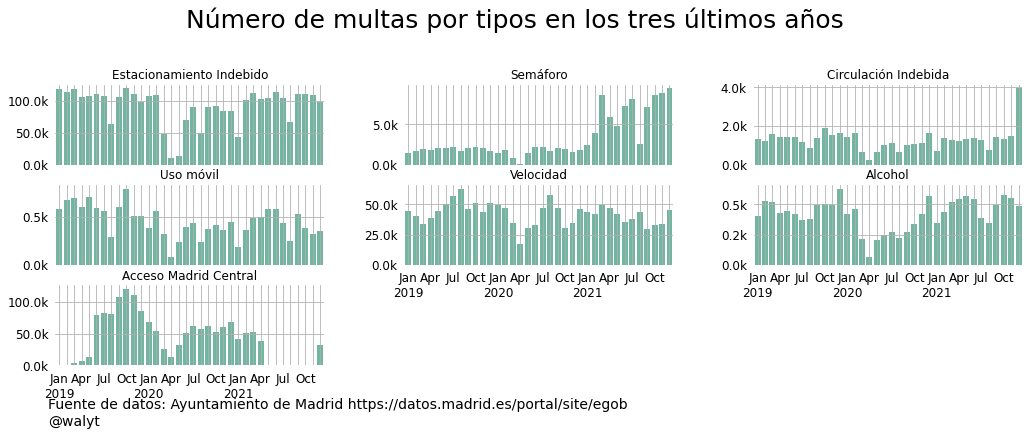

In [90]:
titulo='Número de multas por tipos en los tres últimos años'
g = sns.catplot(
    data=datos,x='FECHA',
    col="HECHO_BOL_resumido",
    kind='count',dodge=True,
    col_wrap=3, height=2, aspect=2.4, legend=False,ci=None,estimator=sum,color=color_multas,sharey=False
)

#g = sns.FacetGrid(data=datos, col="HECHO_BOL",hue='HECHO_BOL',col_wrap=3,height=2,aspect=2.2,sharey=False)
#g.map_dataframe(sns.scatterplot, x='FECHA',y='LUGAR')

for ax in g.axes.flat:
    #ax.xaxis_date()
    ax.xaxis.set_tick_params(labelsize=12,width=0,labelcolor=color_ejes,rotation=0)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x,v:'{}'.format(etiquetas_meses_x[x]) if x%3==0 else ''))
    
    #ax.xaxis.set_major_locator(DayLocator([1]))
    ax.yaxis.set_tick_params(labelsize=12,width=0,labelcolor=color_ejes)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x,v:'{:0,.1f}k'.format(x/1000).replace(',','.')))
    ax.grid(True)
    
    #ax.set_xticklabels(etiquetas_x)
    #ax.set_xticks([tick for tick in ax.get_xticks() if tick % 4 == 0])
    #ax.set_yticklabels([i[:10] for i in multas_hecho])
g.fig.suptitle('{}'.format(titulo),fontsize=25,color=color_titulos)
g.fig.text(x=0.05,y=.05,s=fuente,color=color_titulos,fontsize=14,ha='left')
g.fig.text(x=0.05,y=.01,s=autor,color=color_titulos,fontsize=14)
# Tweak the supporting aspects of the plot
g.despine(bottom=True,left=True)
g.set_titles(col_template="{col_name}",size=12)
g.set_axis_labels("", "")
g.tight_layout()
g.fig.subplots_adjust(top=.8,bottom=.15,wspace=0.3,hspace=0.25)
fichero = f'{path_proyecto}{path_img}/distri_tipos_multas_meses.png'
g.fig.savefig(fichero,bbox_inches = 'tight')

efectivamente, ya tiene otra pinta la gráfica de ***Alcohol***. Modificando levemente el código podemos generar la rejilla de ***Puntos*** y ***Euros*** a lo largo de los meses

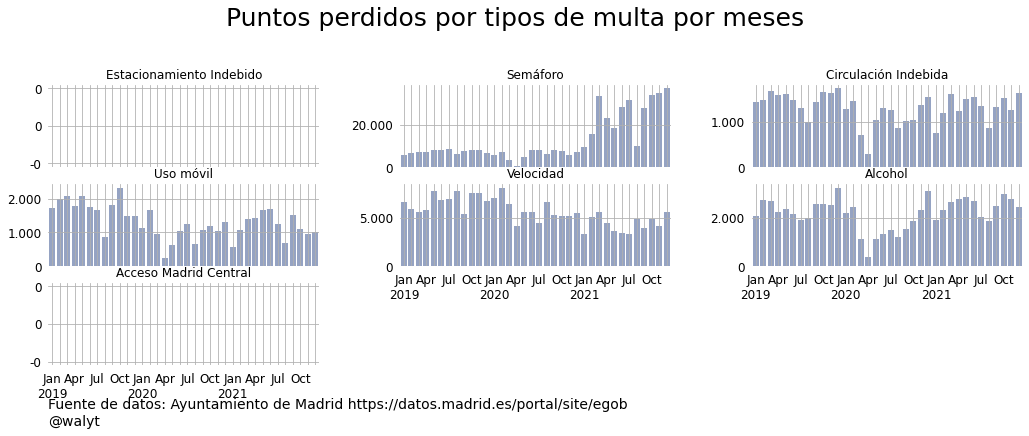

In [92]:
titulo='Puntos perdidos por tipos de multa por meses'
g = sns.catplot(
    data=datos,x='FECHA',
    y="PUNTOS",col="HECHO_BOL_resumido",
    kind='bar',dodge=True,
    col_wrap=3, height=2, aspect=2.4, legend=False,ci=None,estimator=sum,color=color_puntos,sharey=False
)

etiquetas_meses_x = [i.strftime('%b') if i.strftime('%-m')!='1' else i.strftime('%b\n%Y') for i in datos.groupby(['FECHA']).sum().index]
#g = sns.FacetGrid(data=datos, col="HECHO_BOL",hue='HECHO_BOL',col_wrap=3,height=2,aspect=2.2,sharey=False)
#g.map_dataframe(sns.scatterplot, x='FECHA',y='LUGAR')

for ax in g.axes.flat:
    #ax.xaxis_date()
    ax.xaxis.set_tick_params(labelsize=12,width=0,labelcolor=color_ejes,rotation=0)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x,v:'{}'.format(etiquetas_meses_x[x]) if x%3==0 else ''))
    #ax.xaxis.set_major_locator(DayLocator([1]))
    ax.yaxis.set_tick_params(labelsize=12,width=0,labelcolor=color_ejes)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x,v:'{:0,.0f}'.format(x).replace(',','.')))
    ax.grid(True)
    #ax.set_xticklabels(etiquetas_x)
    #ax.set_xticks([tick for tick in ax.get_xticks() if tick % 4 == 0])
    #ax.set_yticklabels([i[:10] for i in multas_hecho])
g.fig.suptitle('{}'.format(titulo),fontsize=25,color=color_titulos)
g.fig.text(x=0.05,y=.05,s=fuente,color=color_titulos,fontsize=14,ha='left')
g.fig.text(x=0.05,y=.01,s=autor,color=color_titulos,fontsize=14)
# Tweak the supporting aspects of the plot
g.despine(bottom=True,left=True)
g.set_titles(col_template="{col_name}",size=12)
g.set_axis_labels("", "")
g.tight_layout()
g.fig.subplots_adjust(top=.8,bottom=.15,wspace=0.3,hspace=0.2)
fichero = f'{path_proyecto}{path_img}/distri_puntos_tipos_meses.png'
g.fig.savefig(fichero,bbox_inches = 'tight') 

...en esta rejilla de puntos vemos que la correspondiente a ***Estacionamiento indebido*** y ***Acceso Madrid Central*** esta vacía, lógico pues estas categorías no llevan a aparejada pérdida de puntos. Y empezamos a vislumbrar un efecto que vimos en una de las primeras gráficas, ¿recuerdan que el ratio puntos por multa se incrementaba en 2022?..pues ya vemos porqué: se han incrementado MUCHO las multas relacionadas con ***Semáforos***.

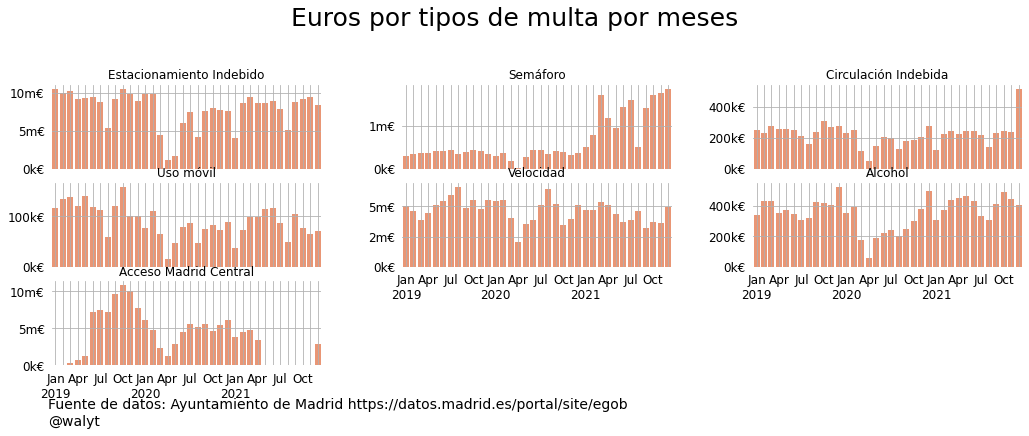

In [94]:
titulo='Euros por tipos de multa por meses'
g = sns.catplot(
    data=datos,x='FECHA',
    y="IMP_BOL",col="HECHO_BOL_resumido",
    kind='bar',dodge=True,
    col_wrap=3, height=2, aspect=2.4, legend=False,ci=None,estimator=sum,color=color_euros,sharey=False
)

#g = sns.FacetGrid(data=datos, col="HECHO_BOL",hue='HECHO_BOL',col_wrap=3,height=2,aspect=2.2,sharey=False)
#g.map_dataframe(sns.scatterplot, x='FECHA',y='LUGAR')

for ax in g.axes.flat:
    #ax.xaxis_date()
    ax.xaxis.set_tick_params(labelsize=12,width=0,labelcolor=color_ejes,rotation=0)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x,v:'{}'.format(etiquetas_meses_x[x]) if x%3==0 else ''))
    #ax.xaxis.set_major_locator(DayLocator([1])de
    ax.yaxis.set_tick_params(labelsize=12,width=0,labelcolor=color_ejes)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x,v:'{:0,.0f}k€'.format(x/1000).replace(',','.')\
                                               if x<1000000 else '{:0,.0f}m€'.format(x/1000000).replace(',','.')))
    ax.grid(True)
    #ax.set_xticklabels(etiquetas_x)
    #ax.set_xticks([tick for tick in ax.get_xticks() if tick % 4 == 0])
    #ax.set_yticklabels([i[:10] for i in multas_hecho])
g.fig.suptitle('{}'.format(titulo),fontsize=25,color=color_titulos)
g.fig.text(x=0.05,y=.05,s=fuente,color=color_titulos,fontsize=14,ha='left')
g.fig.text(x=0.05,y=.01,s=autor,color=color_titulos,fontsize=14)
# Tweak the supporting aspects of the plot
g.despine(bottom=True,left=True)
g.set_titles(col_template="{col_name}",size=12)
g.set_axis_labels("", "")
g.tight_layout()
g.fig.subplots_adjust(top=.8,bottom=.15,wspace=0.3,hspace=0.17)
fichero = f'{path_proyecto}{path_img}/distri_euros_tipos_meses.png'
g.fig.savefig(fichero,bbox_inches = 'tight')

Se me ocurre ahora que podríamos ver, de forma resumida la distribución del total de multas, euros y puntos por estas categorias resumidas. Lo pormos hacer fácil:

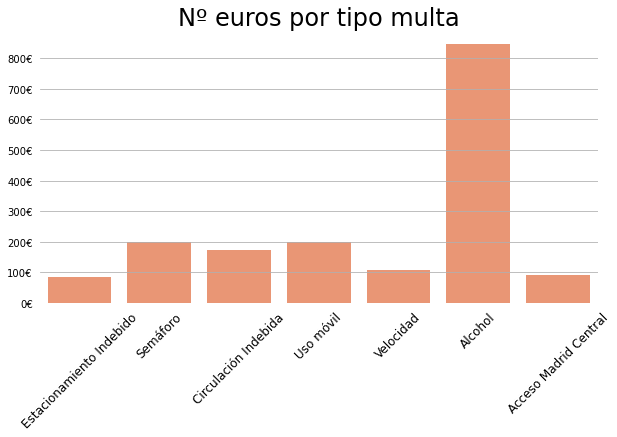

In [53]:
fig = plt.figure(1, (10,5))
ax = fig.add_subplot(1,1,1)
g = sns.barplot(data=datos,x='HECHO_BOL_resumido',y='IMP_BOL',ax=ax,color=color_euros,ci=False)

ax.xaxis.set_tick_params(labelsize=12,width=0,labelcolor=color_ejes,rotation=45)
ax.yaxis.set_tick_params(labelsize=10,width=0,labelcolor=color_ejes)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x,v:'{:0,.0f}€'.format(x).replace(',','.')))

ax.set_xlabel('',size=16)
ax.set_ylabel('',size=16)
ax.grid(axis='y')
sns.despine(left=True,bottom=True)
ax.set_title('Nº euros por tipo multa',size=24)
fichero = f'{path_proyecto}{path_img}/distri_euros_categoria.png'
fig.savefig(fichero,bbox_inches = 'tight')
plt.show()

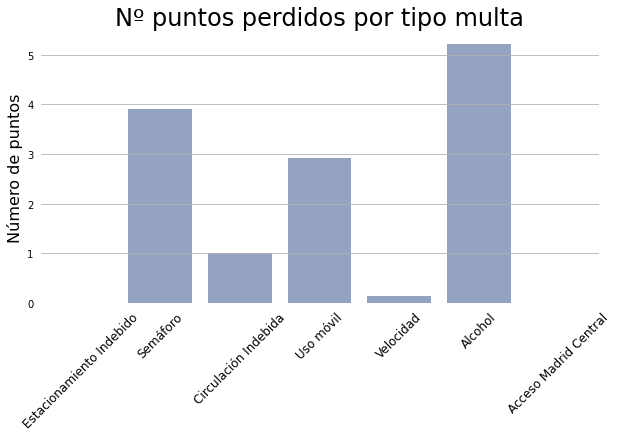

In [54]:
fig = plt.figure(1, (10,5))
ax = fig.add_subplot(1,1,1)
g = sns.barplot(data=datos,x='HECHO_BOL_resumido',y='PUNTOS',ax=ax,color=color_puntos,ci=False)
#ax.bar(x=datos['FECHA'],height=datos['PUNTOS'],width=20,align='center')

ax.xaxis.set_tick_params(labelsize=12,width=0,labelcolor=color_ejes,rotation=45)
#ax.xaxis.set_major_formatter(XmajorFmt)
#ax.xaxis.set_major_locator(MonthLocator([1,4,7,10]))
ax.yaxis.set_tick_params(labelsize=10,width=0,labelcolor=color_ejes)
#ax.yaxis.set_major_formatter(FuncFormatter(lambda x,v:'{:0,.0f}'.format(x).replace(',','.')))
#ax.set_xticklabels(etiquetas_x)

ax.set_xlabel('',size=16)
ax.set_ylabel('Número de puntos',size=16)
ax.grid(axis='y')
sns.despine(left=True,bottom=True)
ax.set_title('Nº puntos perdidos por tipo multa',size=24)
fichero = f'{path_proyecto}{path_img}/distri_puntos_categoria.png'
fig.savefig(fichero,bbox_inches = 'tight')
plt.show()

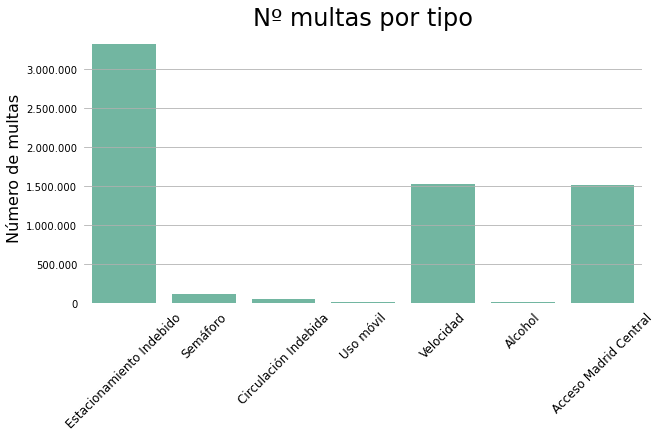

In [55]:
fig = plt.figure(1, (10,5))
ax = fig.add_subplot(1,1,1)
g = sns.countplot(data=datos,x='HECHO_BOL_resumido',ax=ax,color=color_multas)

ax.xaxis.set_tick_params(labelsize=12,width=0,labelcolor=color_ejes,rotation=45)
ax.yaxis.set_tick_params(labelsize=10,width=0,labelcolor=color_ejes)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x,v:'{:0,.0f}'.format(x).replace(',','.')))

ax.set_xlabel('',size=16)
ax.set_ylabel('Número de multas',size=16)
ax.grid(axis='y')
sns.despine(left=True,bottom=True)
ax.set_title('Nº multas por tipo',size=24)
#fig.suptitle(fuente,size=10,x=1,y=-0.01)
fichero = f'{path_proyecto}{path_img}/distri_multas_categoria.png'
fig.savefig(fichero,bbox_inches = 'tight')

..finalizamos generando una tabla con todos los números de las gráficas:

In [121]:
def agrupar(df):
    return df.groupby('HECHO_BOL_resumido')[['IMP_BOL','PUNTOS']]

In [123]:
multas.loc[multas['HECHO_BOL'].isin(multas_hecho),:].pipe(hecho_bol_resumido,hechos_top).pipe(agrupar).agg({'IMP_BOL':['count','sum','mean'],'PUNTOS':['sum','mean']})

IMP_BOL                        PUNTOS     
                            count            sum   mean     sum mean
HECHO_BOL_resumido                                                  
Acceso Madrid Central     1514548 136,309,320.00  90.00       0 0.00
Alcohol                     15158  12,812,400.00 845.26   79028 5.21
Circulación Indebida        46486   8,046,470.00 173.09   47220 1.02
Estacionamiento Indebido  3316019 283,040,670.00  85.36       0 0.00
Semáforo                   119603  23,920,600.00 200.00  468492 3.92
Uso móvil                   16307   3,261,400.00 200.00   47553 2.92
Velocidad                 1524505 166,497,050.00 109.21  200858 0.13

## Agrupando categorías por Hora

Otra pregunta que se nos ocurre es: ¿como se distribuyen esas categorías a los largo de las horas del día?

In [200]:
def columnas(df):
    return list(df.columns)[1:]

def alargo(df):
    return pd.melt(df,id_vars='HECHO_BOL_resumido',value_vars=columnas(df))
def wide_puntos(df):
    return df.pivot(index='HORA',columns='HECHO_BOL_resumido',values='PUNTOS')

def wide_euros(df):
    return df.pivot(index='HORA',columns='HECHO_BOL_resumido',values='IMP_BOL')
def relativo_x(df):
    return df.apply(lambda x: x/df.sum(axis=1))

def relativo_y(df):
    return df.apply(lambda x: x/df.sum(),axis=1)

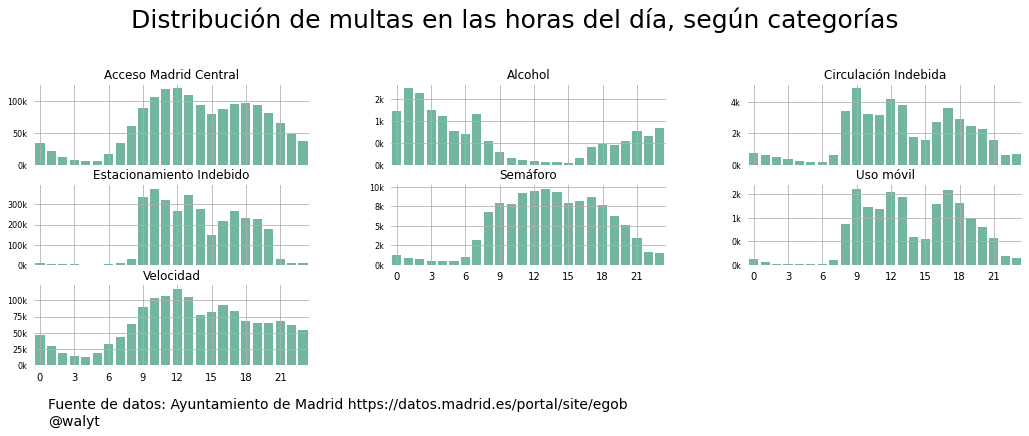

In [201]:
titulo='Distribución de multas en las horas del día, según categorías'
datos_draw = datos.set_index('HORA').groupby(['HECHO_BOL_resumido']).resample('H')['PUNTOS'].count().reset_index()
g = sns.catplot(
    data=(
        multas.
        loc[multas['HECHO_BOL'].isin(multas_hecho),:].
        pipe(hecho_bol_resumido,hechos_top).
        set_index('HORA').
        pipe(agrupar).
        resample('H').
        size().
        reset_index().
        pipe(alargo)
         ),
    x='HORA',
    y="value",col="HECHO_BOL_resumido",
    kind='bar',linewidth=10,
    col_wrap=3, height=2, aspect=2.4, legend=False,ci=None,color=color_multas,sharey=False
)

for ax in g.axes.flat:
    ax.xaxis.set_tick_params(labelsize=10,width=0,labelcolor=color_ejes,rotation=0)
    ax.yaxis.set_tick_params(labelsize=8,width=0,labelcolor=color_ejes)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x,v:'{:0,.0f}k'.format(x/1000).replace(',','.')))
    ax.grid(True)
    ax.set_xticks([tick for tick in ax.get_xticks() if tick % 3 == 0])
    ax.set_xticklabels([i.hour for i in pd.to_datetime(datos_draw['HORA'].unique()[::3])])


g.fig.suptitle('{}'.format(titulo),fontsize=25,color=color_titulos)
g.fig.text(x=0.05,y=.05,s=fuente,color=color_titulos,fontsize=14,ha='left')
g.fig.text(x=0.05,y=.01,s=autor,color=color_titulos,fontsize=14)
# Tweak the supporting aspects of the plot
g.despine(bottom=True,left=True)
g.set_titles(col_template="{col_name}",size=12)
g.set_axis_labels("", "")
g.tight_layout()
g.fig.subplots_adjust(top=.8,bottom=.15,wspace=0.3,hspace=0.25)
fichero = f'{path_proyecto}{path_img}/distri_multas_categoria_horas.png'
g.fig.savefig(fichero,bbox_inches = 'tight')

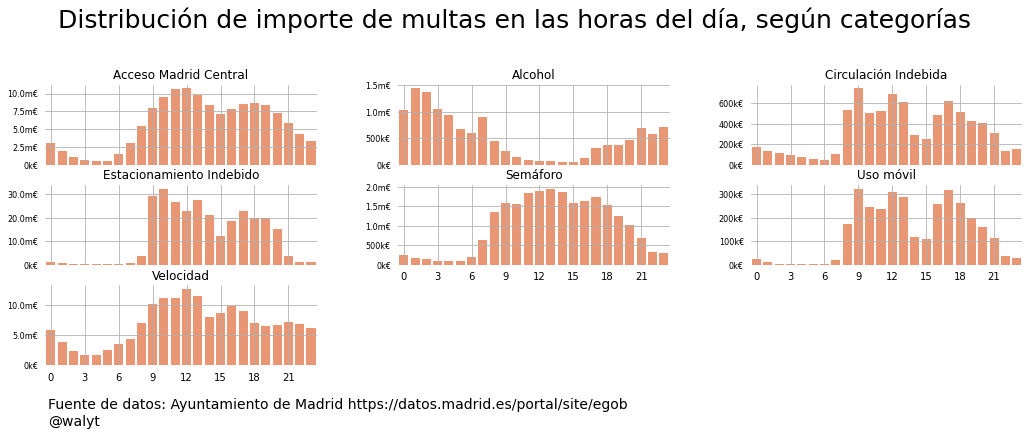

In [202]:
titulo='Distribución de importe de multas en las horas del día, según categorías'
g = sns.catplot(
    data=(
        multas.
        loc[multas['HECHO_BOL'].isin(multas_hecho),:].
        pipe(hecho_bol_resumido,hechos_top).
        set_index('HORA').
        pipe(agrupar).
        resample('H').
        sum().
        reset_index()
         ),
    x='HORA',
    y="IMP_BOL",
    col="HECHO_BOL_resumido",
    kind='bar',
    linewidth=10,
    col_wrap=3, 
    height=2, 
    aspect=2.4, 
    legend=False,
    ci=None,
    color=color_euros,
    sharey=False
)


for ax in g.axes.flat:
    ax.xaxis.set_tick_params(labelsize=10,width=0,labelcolor=color_ejes,rotation=0)
    ax.yaxis.set_tick_params(labelsize=8,width=0,labelcolor=color_ejes)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x,v:'{:0,.0f}k€'.format(x/1000).replace(',','.') if x<1000000 else '{:0,.1f}m€'.format(x/1000000).replace(',','.')))
    ax.grid(True)
    ax.set_xticks([tick for tick in ax.get_xticks() if tick % 3 == 0])
    ax.set_xticklabels([i.hour for i in pd.to_datetime(datos_draw['HORA'].unique()[::3])])

g.fig.suptitle('{}'.format(titulo),fontsize=25,color=color_titulos)
g.fig.text(x=0.05,y=.05,s=fuente,color=color_titulos,fontsize=14,ha='left')
g.fig.text(x=0.05,y=.01,s=autor,color=color_titulos,fontsize=14)
# Tweak the supporting aspects of the plot
g.despine(bottom=True,left=True)
g.set_titles(col_template="{col_name}",size=12)
g.set_axis_labels("", "")
g.tight_layout()
g.fig.subplots_adjust(top=.8,bottom=.15,wspace=0.3,hspace=0.25)
fichero = f'{path_proyecto}{path_img}/distri_importe_categoria_horas.png'
g.fig.savefig(fichero,bbox_inches = 'tight')

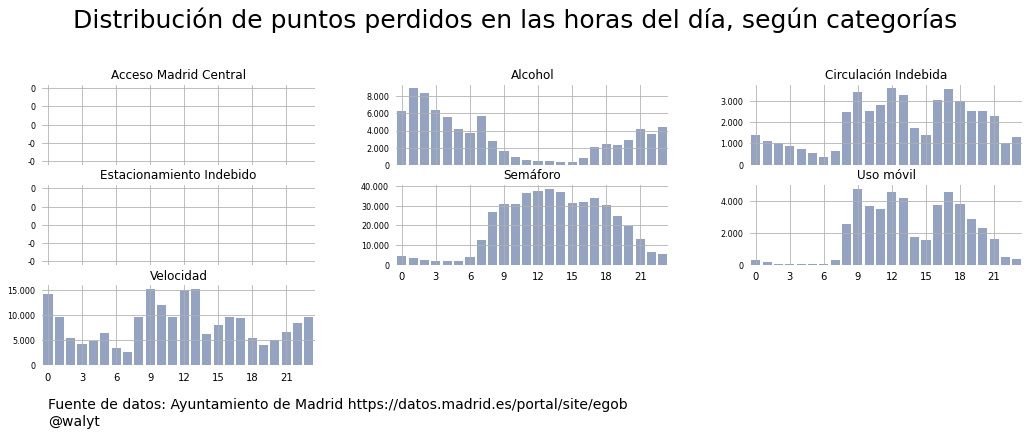

In [203]:
titulo='Distribución de puntos perdidos en las horas del día, según categorías'
g = sns.catplot(
    data=(
        multas.
        loc[multas['HECHO_BOL'].isin(multas_hecho),:].
        pipe(hecho_bol_resumido,hechos_top).
        set_index('HORA').
        pipe(agrupar).
        resample('H').
        sum().
        reset_index()),
    x='HORA',
    y="PUNTOS",col="HECHO_BOL_resumido",
    kind='bar',linewidth=10,
    col_wrap=3, height=2, aspect=2.4, legend=False,ci=None,color=color_puntos,sharey=False
)

for ax in g.axes.flat:
    ax.xaxis.set_tick_params(labelsize=10,width=0,labelcolor=color_ejes,rotation=0)
    ax.yaxis.set_tick_params(labelsize=8,width=0,labelcolor=color_ejes)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x,v:'{:0,.0f}'.format(x).replace(',','.')))
    ax.grid(True)
    ax.set_xticks([tick for tick in ax.get_xticks() if tick % 3 == 0])
    ax.set_xticklabels([i.hour for i in pd.to_datetime(datos_draw['HORA'].unique()[::3])])

    g.fig.suptitle('{}'.format(titulo),fontsize=25,color=color_titulos)
g.fig.text(x=0.05,y=.05,s=fuente,color=color_titulos,fontsize=14,ha='left')
g.fig.text(x=0.05,y=.01,s=autor,color=color_titulos,fontsize=14)
# Tweak the supporting aspects of the plot
g.despine(bottom=True,left=True)
g.set_titles(col_template="{col_name}",size=12)
g.set_axis_labels("", "")
g.tight_layout()
g.fig.subplots_adjust(top=.8,bottom=.15,wspace=0.3,hspace=0.25)
fichero = f'{path_proyecto}{path_img}/distri_puntos_categoria_horas.png'
g.fig.savefig(fichero,bbox_inches = 'tight')

Podemos presentar esa misma información en modo numérico con una *heatmap*. Para ello hemos de preparar 

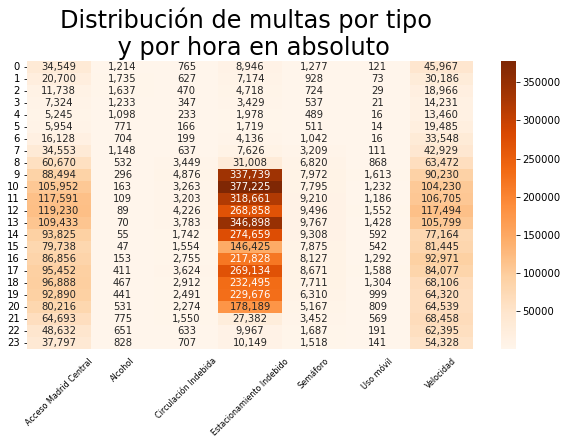

In [210]:
fig = plt.figure(1, (10,5))
ax = fig.add_subplot(1,1,1)
fmt_abs = '0,.0f'
fmt_pct = '0,.3%'

g = sns.heatmap(data=(
    multas.
    loc[multas['HECHO_BOL'].isin(multas_hecho),:].
    pipe(hecho_bol_resumido,hechos_top).
    set_index('HORA').
    pipe(agrupar).
    resample('H').
    size().T),
                ax=ax,
                color=color_barra[1],
                annot=True,
                fmt=fmt_abs,
                cmap='Oranges')
ax.set_xlabel('',size=16)
ax.set_ylabel('')
ax.set_axisbelow(True)
ax.grid(axis='both')
ax.xaxis.set_tick_params(labelsize=8,width=0,labelcolor=color_ejes,rotation=45)
ax.set_yticklabels(etiquetas_y)
sns.despine(left=True,bottom=True)
ax.set_title('Distribución de multas por tipo \n y por hora en absoluto',size=24)
#fig.suptitle(fuente,size=10,x=1,y=-0.01)
fig.subplots_adjust(top=.9,bottom=.1,wspace=0.1,hspace=0.17)
fichero = f'{path_proyecto}{path_img}/heatmap_multas_horas_categorias.png'
fig.savefig(fichero,bbox_inches = 'tight')

Este heatmap permite ver en una matriz de 24 horas y 7 categorías la distribución del números de multas. Permite ver rápidamente la "zona caliente" de número de multas: desde las 8 de la mañana hasta las 20:00 en la categoría ***Estacionamiento indebido***, y las pocas multas, recordemos que es el acumulado de 3 años, de multas por uso de móvil en la noche. Vaya, y por que no lo ponemos en porcentaje?, pues vamos allá, simplemente dividimos por el toal de multa, y variamos el formato para los tantos por ciento.

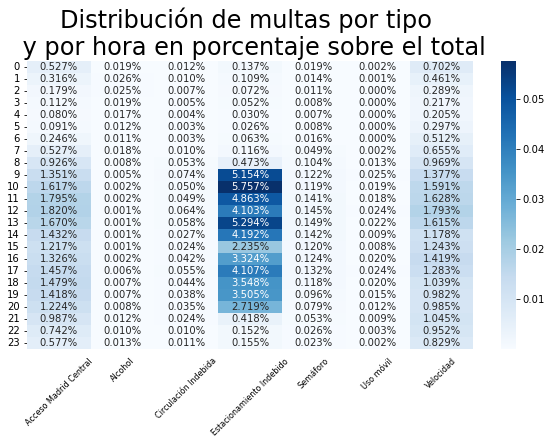

In [213]:
fig = plt.figure(1, (10,5))
ax = fig.add_subplot(1,1,1)
fmt_abs = '0,.0f'
fmt_pct = '0,.3%'

g = sns.heatmap(data=(
    multas.
    loc[multas['HECHO_BOL'].isin(multas_hecho),:].
    pipe(hecho_bol_resumido,hechos_top).
    set_index('HORA').
    pipe(agrupar).
    resample('H').
    size().T)/n_multas,
                ax=ax,
                color=color_barra[1],
                annot=True,
                fmt=fmt_pct,
                cmap='Blues')
etiquetas_y = multas.set_index(['HORA']).resample('H').count().reset_index()['HORA'].dt.hour
ax.set_xlabel('',size=16)
ax.set_ylabel('')
ax.set_axisbelow(True)
ax.grid(axis='both')
ax.xaxis.set_tick_params(labelsize=8,width=0,labelcolor=color_ejes,rotation=45)
#ax.set_yticks([tick[11:16] for tick in a.get_yticks()])
ax.set_yticklabels(etiquetas_y)
sns.despine(left=True,bottom=True)
ax.set_title('Distribución de multas por tipo \n y por hora en porcentaje sobre el total',size=24)
#fig.suptitle(fuente,size=10,x=1,y=-0.01)
fig.subplots_adjust(top=.9,bottom=.1,wspace=0.1,hspace=0.17)
fichero = f'{path_proyecto}{path_img}/heatmap_multas_horas_categorias_pct.png'
fig.savefig(fichero,bbox_inches = 'tight')

Se me ocurre otra pregunta: ¿podría saber como se distribuyen las multas de una hora determinada entre las 7 categorías?..pues claro, añadimos un cálculo en el que calculamos el porcentaje relativo de multas en una hora respecto al toal de esa hora, véase que la suma de los porcentajes de una fila suma lógicamente 100%.

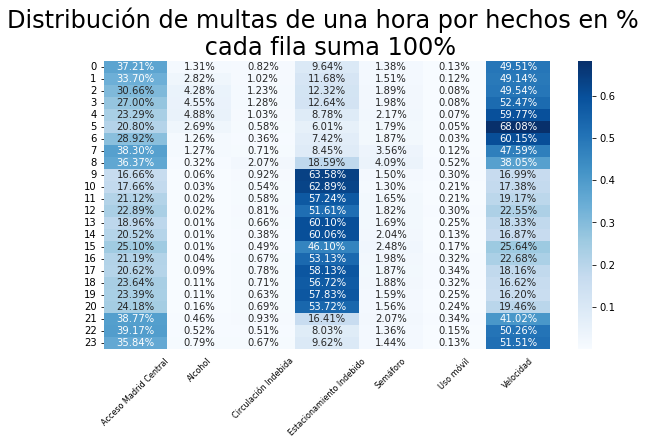

In [214]:
fig = plt.figure(1, (10,5))
ax = fig.add_subplot(1,1,1)
fmt_abs = '0,.0f'
fmt_pct = '0,.2%'

g = sns.heatmap(data=(
    multas.
    loc[multas['HECHO_BOL'].isin(multas_hecho),:].
    pipe(hecho_bol_resumido,hechos_top).
    set_index('HORA').
    pipe(agrupar).
    resample('H').
    size().
    T.
    pipe(relativo_x)
),
                ax=ax,
                color=color_barra[1],
                annot=True,
                fmt=fmt_pct,
                cmap='Blues')

ax.set_xlabel('',size=16)
ax.set_ylabel('')
ax.set_axisbelow(True)
ax.grid(axis='both')
ax.xaxis.set_tick_params(labelsize=8,width=0,labelcolor=color_ejes,rotation=45)
ax.set_yticklabels(etiquetas_y)
sns.despine(left=True,bottom=True)
ax.set_title('Distribución de multas de una hora por hechos en % \n cada fila suma 100%',size=24)
#fig.suptitle(fuente,size=10,x=1,y=-0.01)
fig.subplots_adjust(top=.9,bottom=.1,wspace=0.1,hspace=0.17)
fichero = f'{path_proyecto}{path_img}/heatmap_multas_horas_categorias_hora_agg.png'
fig.savefig(fichero,bbox_inches = 'tight')

Vemos como las multas de ***Estacionamiento Indebido*** como ya intuíamos se llevan la mayor parte del las multas en las horas día. Y en la noche deja paso a la velocidad, que se lleva entre 50% y 60% de las multas totales. Y otra pregunta más: ¿podría ver como se distribuyen las multas de una determinada categoría entre las horas del día?, ahora calcularemos el porcentaje relativo respecto a la suma de cada columna, en este caso la suma de los porcentajes de las columnas sumará 100%.

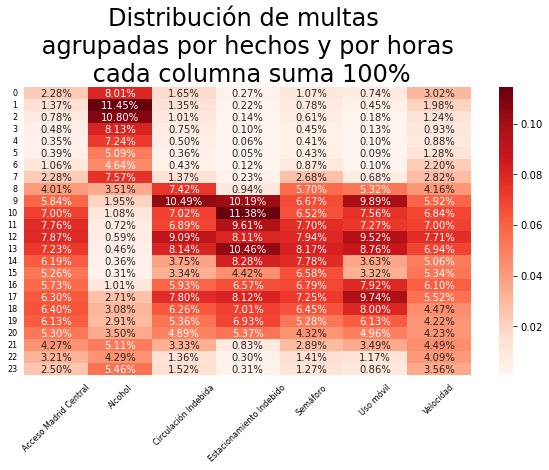

In [207]:
fig = plt.figure(1, (10,5))
ax = fig.add_subplot(1,1,1)
fmt_abs = '0,.0f'
fmt_pct = '0,.2%'
g = sns.heatmap(data=(
    multas.
    loc[multas['HECHO_BOL'].isin(multas_hecho),:].
    pipe(hecho_bol_resumido,hechos_top).
    set_index('HORA').
    pipe(agrupar).
    resample('H').
    size().
    T.
    pipe(relativo_y)
),
                ax=ax,
                color=color_barra[1],
                annot=True,
                fmt=fmt_pct,
                cmap='Reds')
ax.set_xlabel('',size=16)
ax.set_ylabel('')
ax.set_axisbelow(True)
ax.grid(axis='both')
ax.xaxis.set_tick_params(labelsize=8,width=0,labelcolor=color_ejes,rotation=45)
ax.yaxis.set_tick_params(labelsize=8,width=0,labelcolor=color_ejes,rotation=0)
ax.xaxis.set_tick_params(labelsize=8,width=0,labelcolor=color_ejes,rotation=45)
ax.set_yticklabels(etiquetas_y)
sns.despine(left=True,bottom=True)
ax.set_title('Distribución de multas \n agrupadas por hechos y por horas \n cada columna suma 100%',size=24)
#fig.suptitle(fuente,size=10,x=1,y=-0.01)
fig.subplots_adjust(top=.9,bottom=.1,wspace=0.1,hspace=0.17)
fichero = f'{path_proyecto}{path_img}/heatmap_multas_horas_categorias_hecho_agg.png'
fig.savefig(fichero,bbox_inches = 'tight')

Ahora tenemos una visión tal que nos permite ver rápidamente como se distribuyen las multas por categorías, es algo que ya hemos visto en gráficas de barras, pero es otra manera de visualizar.
Para finalizar este apartado hemos preparado un par de heatmaps de porcentajes pero de puntos y euros:

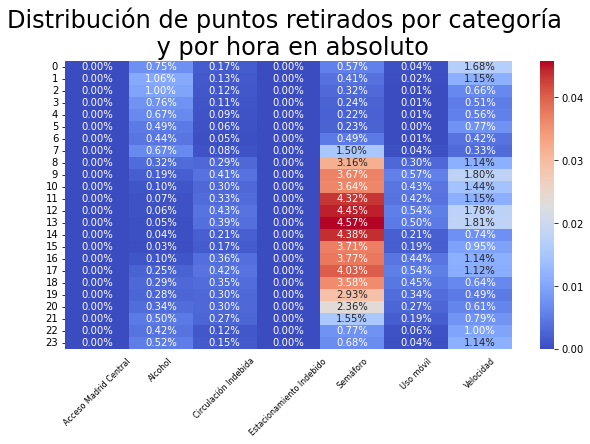

In [222]:
fig = plt.figure(1, (10,5))
ax = fig.add_subplot(1,1,1)
fmt_abs = '0,.0f'
fmt_pct = '0,.2%'

g = sns.heatmap(
    data=(
    multas.
    loc[multas['HECHO_BOL'].isin(multas_hecho),:].
    pipe(hecho_bol_resumido,hechos_top).
    set_index('HORA').
    pipe(agrupar).
    resample('H').
    sum().
    reset_index().
    pipe(wide_puntos)
)/n_puntos,
                ax=ax,
                color=color_barra[1],
                annot=True,
                fmt=fmt_pct,
                cmap='coolwarm')

ax.set_xlabel('',size=16)
ax.set_ylabel('')
ax.set_axisbelow(True)
ax.grid(axis='both')
ax.xaxis.set_tick_params(labelsize=8,width=0,labelcolor=color_ejes,rotation=45)
ax.set_yticklabels(etiquetas_y)
sns.despine(left=True,bottom=True)
ax.set_title('Distribución de puntos retirados por categoría \n y por hora en absoluto',size=24)
#fig.suptitle(fuente,size=10,x=1,y=-0.01)
fig.subplots_adjust(top=.9,bottom=.1,wspace=0.1,hspace=0.17)
fichero = f'{path_proyecto}{path_img}/heatmap_puntos_horas_categorias.png'
fig.savefig(fichero,bbox_inches = 'tight')

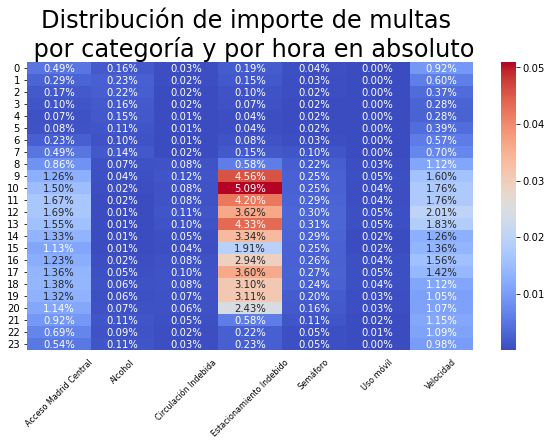

In [223]:
fig = plt.figure(1, (10,5))
ax = fig.add_subplot(1,1,1)
fmt_abs = '0,.0f'
fmt_pct = '0,.2%'

g = sns.heatmap(data=(
    multas.
    loc[multas['HECHO_BOL'].isin(multas_hecho),:].
    pipe(hecho_bol_resumido,hechos_top).
    set_index('HORA').
    pipe(agrupar).
    resample('H').
    sum().
    reset_index().
    pipe(wide_euros)
    )/n_euros,
                ax=ax,
                color=color_barra[1],
                annot=True,
                fmt=fmt_pct,
                cmap='coolwarm')

ax.set_xlabel('',size=16)
ax.set_ylabel('')
ax.set_axisbelow(True)
ax.grid(axis='both')
ax.xaxis.set_tick_params(labelsize=8,width=0,labelcolor=color_ejes,rotation=45)
ax.set_yticklabels(etiquetas_y)
sns.despine(left=True,bottom=True)
ax.set_title('Distribución de importe de multas \n por categoría y por hora en absoluto',size=24)
#fig.suptitle(fuente,size=10,x=1,y=-0.01)
fig.subplots_adjust(top=.9,bottom=.1,wspace=0.1,hspace=0.17)
fichero = f'{path_proyecto}{path_img}/heatmap_euros_horas_categorias.png'
fig.savefig(fichero,bbox_inches = 'tight')

# Análisis multas Semaforo

Vamos a investigar ahora un poco para ver el comportamiento de las multas por semáforos:

Primero vamos a generar un `pandas` aux, sé que no es la mejor práctica pero permite acelerar las pruebas al no tener que repetir una y otra vez los procesos de filtro:

In [97]:
def filtra(df,categoria):
    return df.loc[df['HECHO_BOL_resumido']==categoria,:]

In [438]:
datos = multas.loc[multas['HECHO_BOL'].isin(multas_hecho),:].pipe(hecho_bol_resumido,hechos_top).pipe(filtra,'Semáforo')

In [258]:
datos.shape

(119603, 14)

In [246]:
datos['LUGAR'].unique().size

7510

ya sabemos que tenemos por encima 119.603 multas de Semáforos, y 7.510 lugares diferentes. Con este último número ya vemos la gran cantidad que hay de ***Lugar***.

VEamos las localización con más multas asociadas:

In [439]:
datos.groupby(['LUGAR']).agg(['sum','count'])[['PUNTOS','IMP_BOL']].reset_index().sort_values([('PUNTOS','count')],ascending=False)['LUGAR'][:100].values

/var/folders/_p/bc_h4mbs0350g3s_n60vsd3c0000gp/T/ipykernel_47966/2429061672.py:1: FutureWarning: ['FECHA', 'HORA'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  datos.groupby(['LUGAR']).agg(['sum','count'])[['PUNTOS','IMP_BOL']].reset_index().sort_values([('PUNTOS','count')],ascending=False)['LUGAR'][:100].values


array(['CEA BERMUDEZ - VALLEHERMOSO             ',
       'ALCALA - SAN ROMUALDO                   ',
       'VIA LUSITANA - PL ELIPTICA              ',
       'AV MEDITERRANEO 32                      ',
       'FRANCISCO SILVELA 62                    ',
       'GRAL RICARDOS - QUINCE MAYO             ',
       "O'DONNELL CON DOCTOR ESQUERDO           ",
       'JOSE ABASCAL - SANTA ENGRACIA           ',
       'ALBERTO AGUILERA - B. GRACIAN           ',
       'AV AMERICA - CARTAGENA                  ',
       '124 CEA BERMUDEZ - VALLEHERMOS          ',
       '116 VIA LUSITANA - PL ELIPTICA          ',
       'PO CASTELLANA 105                       ',
       'C. BARRIAL - FDO. L. CARRETER           ',
       'AV ILUSTRACION ESQ BETANZOS             ',
       'AV FILIPINAS 18                         ',
       '111 ALCALA - SAN ROMUALDO               ',
       'M. CORBERA - RICARDO ORTIZ              ',
       'CARAB. ARAVACA - VILLAVICIOSA           ',
       'AV ANDALUCIA ESQ ALCOCE

Me gustaria hacerme una idea sobre el número de variaciones que podemos encontrar de una misma localización. Hagamos un apr de pruebas:

In [440]:
datos[datos['LUGAR'].str.contains('CORBERA') & datos['LUGAR'].str.contains('')]['LUGAR'].unique()

array(['M. CORBERA - RICARDO ORTIZ              ',
       'AV MARQUES DE CORBERA 28                ',
       'RICARDO ORTIZ-AV MQUES CORBERA          ',
       'AV MARQUES CORBERA-MONTEJURRA           ',
       'AV MARQUES CORBERA-HNOS GOMEZ           ',
       'AV MARQUES DE CORBERA 1                 ',
       'AV MARQUES CORBERA                      ',
       'AV MARQUES CORBERA-STA PRISCA           ',
       'AV MARQUES CORBERA-S CLODOALDO          ',
       'SANTA PRISCA 9-AV M CORBERA             ',
       'AV MARQUES DE CORBERA-R ORTIZ           ',
       'AV MARQUES DE CORBERA 60                ',
       'AV MARQUES DE CORBERA 41                ',
       'AV MARQUES DE CORBERA 61                ',
       'POETA BLAS OTERO-AV M CORBERA           ',
       '110 AV MARQUES DE CORBERA - RI          ',
       'AV MARQUES CORBERA-J BARBASTRE          ',
       'AV MARQUES DE CORBERA-G CORDON          ',
       'AV MARQUES DE CORBERA 65                ',
       'AV MAR.CORBERA-POE BLAS

In [441]:
datos[datos['LUGAR'].str.contains('SINESIO DELGADO')]['LUGAR'].unique()

array(['SINESIO DELGADO GTA P. CEBRERO          ',
       'PO CASTELLANA-SINESIO DELGADO           ',
       'SINESIO DELGADO-AV M LEMOS              ',
       'SINESIO DELGADO-CNO CHORRILLO           ',
       'SINESIO DELGADO-VILLAAMIL               ',
       'SINESIO DELGADO RTVE                    ',
       'SINESIO DELGADO FAROLA 9                ',
       'MAGNOLIAS-SINESIO DELGADO               ',
       'SINESIO DELGADO-GTA P CEBRERO           ',
       'SINESIO DELGADO FAROLA 7                ',
       'SINESIO DELGADO HP CARLOS III           ',
       'SINESIO DELGADO-AV ASTURIAS             ',
       'AV ASTURIAS-SINESIO DELGADO             ',
       'SINESIO DELGADO-GINZO DE LIMIA          ',
       'SINESIO DELGADO-CTRA D VILLA            ',
       'SINESIO DELGADO FAROLA 39               ',
       '101 SINESIO DELGADO GTA P. CEB          ',
       'SINESIO DELGADO 10                      ',
       'SINESIO DELGADO-AV BETANZOS             ',
       'SINESIO DELGADO 9      

En los dos  ejemplos anterior, Corberra y Sinesio Delgado, vemos que hay muchas denominaciones con pequeñas variaciones, pero nos entra la duda: ese efecto viene de diferentes entradas de semáforos de control automático (realmente poco probable raro) o se mezclan multas de semáforos de control automático y multas realizadas por policia en otros puntos de Sinesio Delgado?. Para responder a esa pregunta podemos filtrar por las coordenadas, ya que las multas de semáforos con control automático están geoposicionadas, veamos cuantos valores únicos podemos encontrar en `COORDENADA_X`:

In [446]:
datos['COORDENADA_X'].unique()

array(['           ', '  439856.91', '  442633.05', '  439802.04',
       '  435542.26', '  439301.79', '  439232.86', '  439719.40',
       '  443037.87', '  434397.30', '  440000.69', '  444524.76',
       '  432850.36', '  443017.57', '  449801.53', '  443397.89',
       '  444461.78', '  447180.68', '  441258.69', '  446113.77',
       '  439132.53', '  440671.00', '  441556.35', '  441560.69',
       '  441264.06', '  444180.30', '  442840.13', '  439585.57',
       '  440583.84', '  447053.81', '  435089.95', '  442368.00',
       '  439798.51', '  442175.51', '  440617.58', '  445783.54',
       '    4442.21', '    4413.81', '    4415.20', '    4415.23',
       '    4414.96', '    4394.93'], dtype=object)

Filtremos por aquellas multas que tienen una coordenada no nula:

In [444]:
datos[datos['COORDENADA_X']!='           ']

,CALIFICACION,LUGAR,FECHA,HORA,IMP_BOL,DESCUENTO,PUNTOS,DENUNCIANTE,HECHO_BOL,VEL_LIMITE,VEL_CIRCULA,COORDENADA_X,COORDENADA_Y,HECHO_BOL_resumido
6517268,GRAVE,AV FILIPINAS 18,2019-01-01,1900-01-01 20:22:00,200.00,SI,4,AGENTES DE MOVILIDAD,REBASAR UN SEMÁFORO EN FASE ROJA.,,,439856.91,4477037.97,Semáforo
6517266,GRAVE,MENENDEZ PELAYO H. NIŃO JESUS,2019-01-01,1900-01-01 18:15:00,200.00,SI,4,AGENTES DE MOVILIDAD,REBASAR UN SEMÁFORO EN FASE ROJA.,,,442633.05,4474191.88,Semáforo
6517265,GRAVE,ALBERTO AGUILERA - B. GRACIAN,2019-01-01,1900-01-01 17:54:00,200.00,SI,4,AGENTES DE MOVILIDAD,REBASAR UN SEMÁFORO EN FASE ROJA.,,,439802.04,4475938.23,Semáforo
6517264,GRAVE,AV POBLADOS-EST. ALUCHE F 56,2019-01-01,1900-01-01 16:05:00,200.00,SI,4,AGENTES DE MOVILIDAD,REBASAR UN SEMÁFORO EN FASE ROJA.,,,435542.26,4470953.31,Semáforo
6517263,GRAVE,AV POBLADOS-EST. ALUCHE F 56,2019-01-01,1900-01-01 16:46:00,200.00,SI,4,AGENTES DE MOVILIDAD,REBASAR UN SEMÁFORO EN FASE ROJA.,,,435542.26,4470953.31,Semáforo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,GRAVE,AV MEDITERRANEO 32,2021-12-01,1900-01-01 13:00:00,200.00,SI,4,AGENTES DE MOVILIDAD,REBASAR UN SEMÁFORO EN FASE ROJA.,,,443017.57,4473349.72,Semáforo
500,GRAVE,CEA BERMUDEZ - VALLEHERMOSO,2021-12-01,1900-01-01 12:55:00,200.00,SI,4,AGENTES DE MOVILIDAD,REBASAR UN SEMÁFORO EN FASE ROJA.,,,440000.69,4476904.97,Semáforo
499,GRAVE,CEA BERMUDEZ - VALLEHERMOSO,2021-12-01,1900-01-01 12:54:00,200.00,SI,4,AGENTES DE MOVILIDAD,REBASAR UN SEMÁFORO EN FASE ROJA.,,,440000.69,4476904.97,Semáforo
498,GRAVE,AV MEDITERRANEO 32,2021-12-01,1900-01-01 12:53:00,200.00,SI,4,AGENTES DE MOVILIDAD,REBASAR UN SEMÁFORO EN FASE ROJA.,,,443017.57,4473349.72,Semáforo


Vemos que nos quedamos con 102434/119603 = 85.6% de las multas. Veamos cuantos `LUGAR` tenemos en esas multas ya filtradas, idealmente deberíamos tener igual numero que localizaciones, 41. Veámoslo.

In [447]:
datos.loc[datos['COORDENADA_X']!='           ','LUGAR'].unique().size

75

Bueno, tenemos unas pocas más...toca normalizar, sabiendo que es improbable que cometamos error, ya que son multas referenciadas a la misma geolocalización:

In [336]:
datos.loc[datos['COORDENADA_X']!='           ','LUGAR'].unique()

array(['AV FILIPINAS 18                         ',
       'MENENDEZ PELAYO H. NIŃO JESUS           ',
       'ALBERTO AGUILERA - B. GRACIAN           ',
       'AV POBLADOS-EST. ALUCHE F 56            ',
       'AV VENTISQUERO CONDESA 42               ',
       'GRAL RICARDOS - QUINCE MAYO             ',
       'AV ILUSTRACION ESQ BETANZOS             ',
       'AV AMERICA - CARTAGENA                  ',
       'CARAB. ARAVACA - VILLAVICIOSA           ',
       'CEA BERMUDEZ - VALLEHERMOSO             ',
       'CAMINO DE LOS VINATEROS 47              ',
       'C. BARRIAL - FDO. L. CARRETER           ',
       'AV MEDITERRANEO 32                      ',
       'AV LOGROŃO ESQ JOAQUIN IBARRA           ',
       "O'DONNELL CON DOCTOR ESQUERDO           ",
       'M. CORBERA - RICARDO ORTIZ              ',
       'ALCALA - SAN ROMUALDO                   ',
       'AV ANDALUCIA ESQ ALCOCER                ',
       'FTE CARRANTONA ESQ HAC.PAVONES          ',
       'VIA LUSITANA - PL ELIPT

In [339]:
datos.loc[datos['COORDENADA_X']!='           ',:].groupby(['COORDENADA_X','LUGAR']).sum()

IMP_BOL  PUNTOS
COORDENADA_X LUGAR                                                        
    4394.93  VENTURA RODRIGU-PRINCIPE DE VE                 200.00       4
    4413.81  RECOLETOS 000020                               200.00       4
    4414.96  ALBERTO ALCOCER-LA HABANA                      200.00       4
    4415.20  INDEPENDENCIA-SERRANO                          200.00       4
    4415.23  INDEPENDENCIA 000001                           200.00       4
    4442.21  F 108                                          200.00       4
  432850.36  120 CMNO BARRIAL - FDO LAZARO              107,400.00    2148
             C. BARRIAL - FDO. L. CARRETER              495,200.00    9904
  434397.30  121 CRA. CARABANCHEL ARAVACA -             124,200.00    2484
             CARAB. ARAVACA - VILLAVICIOSA              390,800.00    7816
  435089.95  122 AV. PESETA - CTRA BARRIO F              94,800.00    1896
             AV PESETA - CTRA B. FORTUNA                260,200.00    5204
  435542.26  085 AV POBLADOS-EST. ALUCHE F               78,000.00    1560
             AV POBLADOS-EST. ALUCHE F 56               253,800.00    5076
  439132.53  116 VIA LUSITANA - PL ELIPTICA             530,400.00   10608
             VIA LUSITANA - PL ELIPTICA               1,001,000.00   20020
  439232.86  123 GNRAL RICARDOS - PSO QUINC             269,000.00    5380
             GRAL RICARDOS - QUINCE MAYO                690,600.00   13812
  439301.79  088 AV VENTISQUERO CONDESA 42               52,600.00    1052
             AV VENTISQUERO CONDESA 42                  198,000.00    3960
  439585.57  103 AV C. HERRERA ORIA ESQ LA               13,600.00     272
             AV C. HERRERA ORIA ESQ LA MASO              54,800.00    1096
  439719.40  090 AV ILUSTRACION ESQ BETANZO             184,600.00    3692
             AV ILUSTRACION ESQ BETANZOS                474,600.00    9492
  439798.51  101 SINESIO DELGADO GTA P. CEB             119,600.00    2392
             SINESIO DELGADO GTA P. CEBRERO             300,800.00    6016
  439802.04  114 ALBERTO AGUILERA - BALTASA             179,000.00    3580
             ALBERTO AGUILERA - B. GRACIAN              582,600.00   11652
  439856.91  087 AV FILIPINAS 18                        159,200.00    3184
             AV FILIPINAS 18                            463,800.00    9276
  440000.69  124 CEA BERMUDEZ - VALLEHERMOS             535,600.00   10712
             CEA BERMUDEZ - VALLEHERMOSO              1,054,000.00   21080
  440583.84  118 MONFORTE DE LEMOS - FINIST              53,800.00    1076
             MONFORTE  LEMOS - FINISTERRE               165,200.00    3304
  440617.58  075 AV CARDENAL HERRERA ORIA 8              40,800.00     816
             AV CARDENAL HERRERA ORIA 83                113,200.00    2264
  440671.00  117 JOSE ABASCAL - SANTA ENGRA             306,600.00    6132
             JOSE ABASCAL - SANTA ENGRACIA              666,000.00   13320
  441258.69  106 AV ANDALUCIA ESQ ALCOCER                92,800.00    1856
             AV ANDALUCIA ESQ ALCOCER                   330,200.00    6604
  441264.06  091 AV ANDALUCIA METRO S.CRIST             107,000.00    2140
             AV ANDALUCIA METRO S.CRISTOBAL             304,600.00    6092
  441556.35  084 PO CASTELLANA 105                      215,800.00    4316
             PO CASTELLANA 105                          493,800.00    9876
  441560.69  059 PO CASTELLANA 167                      101,400.00    2028
             PO CASTELLANA 167                          266,400.00    5328
  442175.51  JOAQUIN COSTA - VELAZQUEZ                   72,600.00    1452
  442368.00  113 AV CIUDAD DE BARCELONA - M              18,200.00     364
             CIUDAD BARCELONA - M. PELAYO               143,600.00    2872
  442633.05  099 MENENDEZ PELAYO H. NIŃO JE             161,800.00    3236
             MENENDEZ PELAYO H. NIŃO JESUS              281,200.00    5624
  442840.13  100 FRANCISCO SILVELA 62                   310,800.00    6216
         

Vemos ahora claramente que en algún momento se ha normalizado la denominación de la localización del semáforo. En general, salvo alguna excepción (las 5 primeras, y *Joaquín Costa-Velazquez*). Luego el proceso de normalizar es simplemente utulizar una de las dos denominaciones. Para ello vamos a realizar dos pasos:
 - Generamos un diccionario con clave ***COORDENADA_X*** y valor la denominación elegida. En este punto, y por las excepciones comentadas, tendremos que generar 4 diferentes fuentes.
 - Utilizando ese diccionario añadimos una columna nueva a `datos`, por ejemplo `LUGAR_norm` en el que ya tendremos una unicidad entre ***COORDENADA_X*** y una denominación de Lugar.

La primera fuente será simplemente las 6 primeras localizaciones, que tienen un Lugar único. La segunda fuente vendrá referenciada hasta la entrada previa a *Joaquín Costa*, la tercera es justamente *Joaquín Costa*, y la cuarta desde la localización siguiente hasta el final. Vease que con el `2`
 del slicing conseguimos elegir uno de cada dos entradas, es decir, nos quedamos con una de las dos localizaciones.

In [450]:
datos.loc[datos['COORDENADA_X']!='           ',:].groupby(['COORDENADA_X','LUGAR']).sum().reset_index()[['COORDENADA_X','LUGAR']].iloc[6:52:2]

,COORDENADA_X,LUGAR
6,432850.36,120 CMNO BARRIAL - FDO LAZARO
8,434397.30,121 CRA. CARABANCHEL ARAVACA -
10,435089.95,122 AV. PESETA - CTRA BARRIO F
12,435542.26,085 AV POBLADOS-EST. ALUCHE F
14,439132.53,116 VIA LUSITANA - PL ELIPTICA
16,439232.86,123 GNRAL RICARDOS - PSO QUINC
18,439301.79,088 AV VENTISQUERO CONDESA 42
20,439585.57,103 AV C. HERRERA ORIA ESQ LA
22,439719.40,090 AV ILUSTRACION ESQ BETANZO
24,439798.51,101 SINESIO DELGADO GTA P. CEB


In [451]:
datos.loc[datos['COORDENADA_X']!='           ',:].groupby(['COORDENADA_X','LUGAR']).sum().reset_index()[['COORDENADA_X','LUGAR']].iloc[46]

COORDENADA_X                                   442175.51
LUGAR           JOAQUIN COSTA - VELAZQUEZ               
Name: 46, dtype: object

In [452]:
datos.loc[datos['COORDENADA_X']!='           ',:].groupby(['COORDENADA_X','LUGAR']).sum().reset_index()[['COORDENADA_X','LUGAR']].iloc[47::2]

,COORDENADA_X,LUGAR
47,442368.00,113 AV CIUDAD DE BARCELONA - M
49,442633.05,099 MENENDEZ PELAYO H. NIŃO JE
51,442840.13,100 FRANCISCO SILVELA 62
53,443017.57,098 AV MEDITERRANEO 32
55,443037.87,119 AV. AMERICA - CARTAGENA
57,443397.89,097 ODONNELL CON DOCTOR ESQUER
59,444180.30,104 FCO PI Y MARGALL ESQ ANA A
61,444461.78,110 AV MARQUES DE CORBERA - RI
63,444524.76,093 CAMINO DE LOS VINATEROS 47
65,445783.54,112 ASCAO - EMILIO FERRARI


Pues juntando estos tres pandas ya tendremos la base de un diccionario para poder normalizar el `LUGAR` de los semaforos que nos interesan 

In [453]:
df1 = datos.loc[datos['COORDENADA_X']!='           ',:].groupby(['COORDENADA_X','LUGAR']).sum().reset_index()[['COORDENADA_X','LUGAR']].iloc[:6]
df2 = datos.loc[datos['COORDENADA_X']!='           ',:].groupby(['COORDENADA_X','LUGAR']).sum().reset_index()[['COORDENADA_X','LUGAR']].iloc[6:52:2]
df3 = datos.loc[datos['COORDENADA_X']!='           ',:].groupby(['COORDENADA_X','LUGAR']).sum().reset_index()[['COORDENADA_X','LUGAR']].iloc[47::2]
df4 = pd.DataFrame(datos.loc[datos['COORDENADA_X']!='           ',:].groupby(['COORDENADA_X','LUGAR']).sum().reset_index()[['COORDENADA_X','LUGAR']].iloc[46]).T


In [454]:
pd.concat([df1,df2,df3,df4]).reset_index(drop=True)

,COORDENADA_X,LUGAR
0,4394.93,VENTURA RODRIGU-PRINCIPE DE VE
1,4413.81,RECOLETOS 000020
2,4414.96,ALBERTO ALCOCER-LA HABANA
3,4415.20,INDEPENDENCIA-SERRANO
4,4415.23,INDEPENDENCIA 000001
5,4442.21,F 108
6,432850.36,120 CMNO BARRIAL - FDO LAZARO
7,434397.30,121 CRA. CARABANCHEL ARAVACA -
8,435089.95,122 AV. PESETA - CTRA BARRIO F
9,435542.26,085 AV POBLADOS-EST. ALUCHE F


Pues ahí lo tenemos, creamos un diccionario con la `COORDENADA_X`como clave y el `LUGAR` como valor, y normalizamos los lugares de todos el pandas.

In [455]:
lugar_norm = pd.concat([df1,df2,df3,df4]).reset_index(drop=True).set_index('COORDENADA_X').to_dict()['LUGAR']


In [456]:
datos.loc[datos['COORDENADA_X']!='           ','LUGAR_norm'] = datos.loc[datos['COORDENADA_X']!='           ',:].apply(lambda x:lugar_norm[x['COORDENADA_X']],axis=1)

In [457]:
datos = datos.loc[datos['COORDENADA_X']!='           ',:]

chequeemos que ha quedado bien la normalización:

In [458]:
datos.groupby(['COORDENADA_X','LUGAR_norm']).size()

COORDENADA_X  LUGAR_norm                              
    4394.93   VENTURA RODRIGU-PRINCIPE DE VE                 1
    4413.81   RECOLETOS 000020                               1
    4414.96   ALBERTO ALCOCER-LA HABANA                      1
    4415.20   INDEPENDENCIA-SERRANO                          1
    4415.23   INDEPENDENCIA 000001                           1
    4442.21   F 108                                          1
  432850.36   120 CMNO BARRIAL - FDO LAZARO               3013
  434397.30   121 CRA. CARABANCHEL ARAVACA -              2575
  435089.95   122 AV. PESETA - CTRA BARRIO F              1775
  435542.26   085 AV POBLADOS-EST. ALUCHE F               1659
  439132.53   116 VIA LUSITANA - PL ELIPTICA              7657
  439232.86   123 GNRAL RICARDOS - PSO QUINC              4798
  439301.79   088 AV VENTISQUERO CONDESA 42               1253
  439585.57   103 AV C. HERRERA ORIA ESQ LA                342
  439719.40   090 AV ILUSTRACION ESQ BETANZO              3296


perfecto...

Vamos a preparar una rejilla con todos ellos, quiza quitando los seis primeros que tienen solo 1 multa por localizacion y con una coordenada creo que incorrecta:

In [459]:
top_semaforos = list(datos.groupby(['COORDENADA_X','LUGAR_norm']).size().sort_values(ascending=False).reset_index()['LUGAR_norm'][:-6])

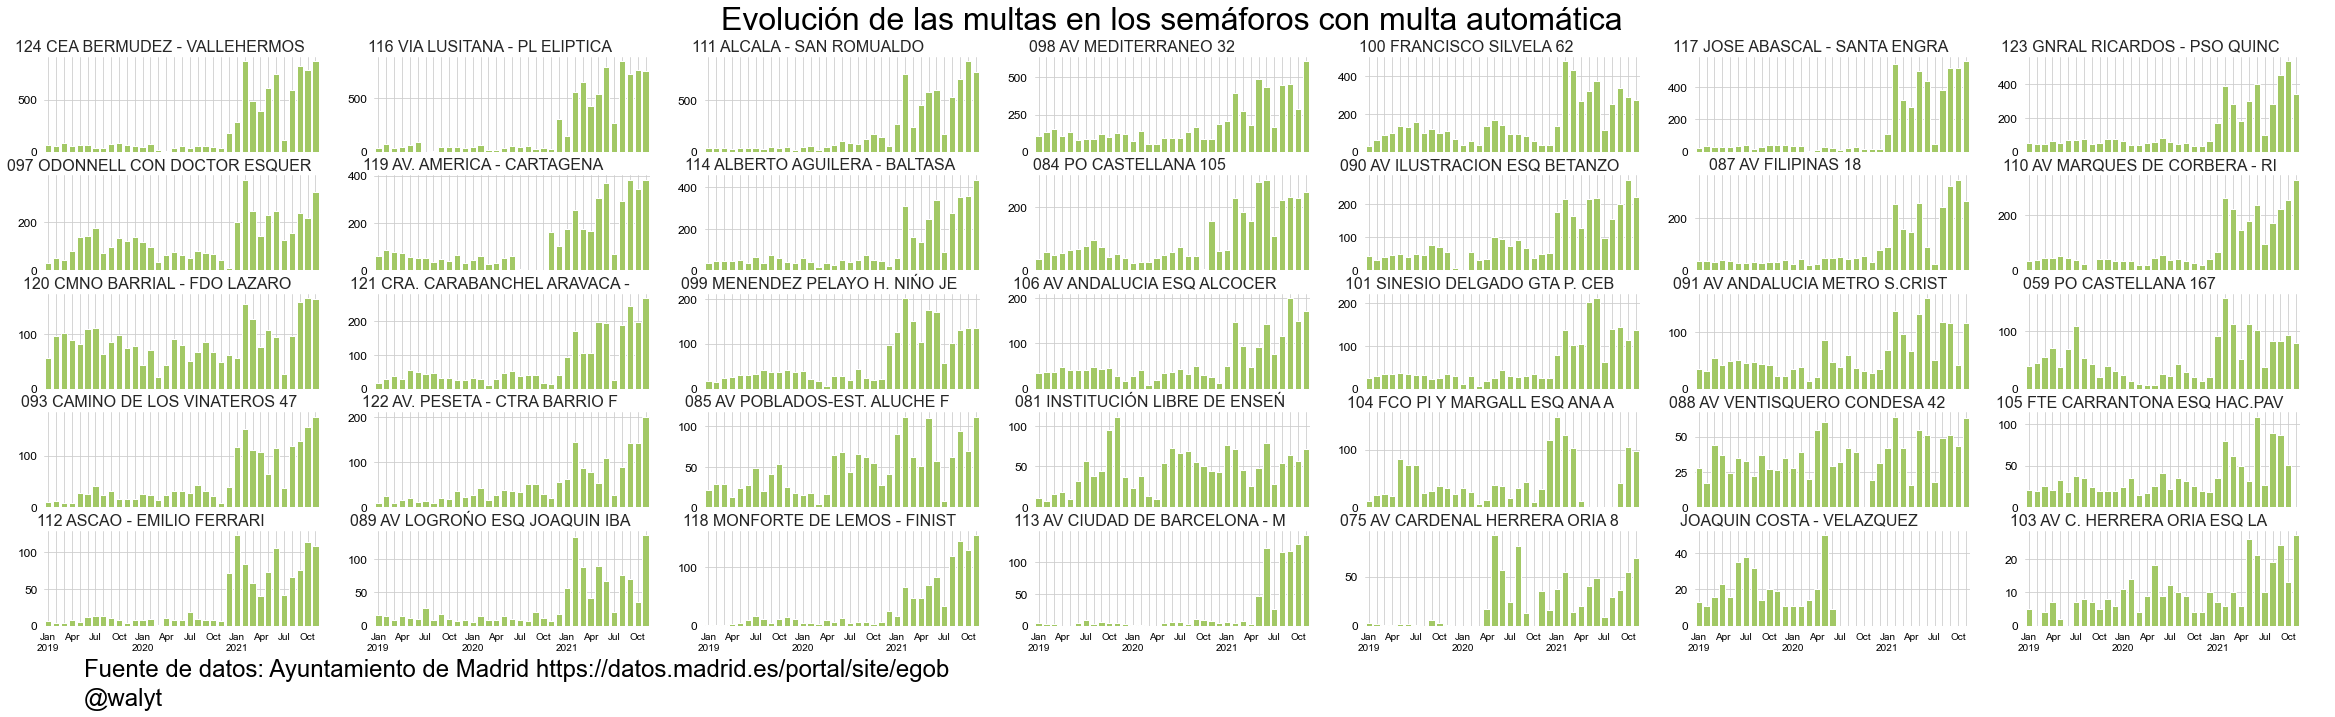

In [460]:
sns.set_style(style='white')
titulo='Evolución de las multas en los semáforos con multa automática'
g = sns.catplot(
    data=datos.loc[datos['LUGAR_norm'].isin(top_semaforos),:],x='FECHA',
    col="LUGAR_norm",
    kind='count',dodge=True,
    col_wrap=7, col_order=top_semaforos,height=2, aspect=2.4, legend=False,ci=None,
    color=color_barra[4],sharey=False
)

for ax in g.axes.flat:
    ax.xaxis.set_tick_params(labelsize=10,width=0,labelcolor=color_ejes,rotation=0)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x,v:'{}'.format(etiquetas_meses_x[x]) if x%3==0 else ''))
    ax.yaxis.set_tick_params(labelsize=12,width=0,labelcolor=color_ejes)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x,v:'{:0,.0f}'.format(x).replace(',','.')))
    ax.grid(True)
    
g.fig.suptitle(f'{titulo}',fontsize=32,color=color_titulos)
g.fig.text(x=0.05,y=.05,s=fuente,color=color_titulos,fontsize=24,ha='left')
g.fig.text(x=0.05,y=.01,s=autor,color=color_titulos,fontsize=24)
g.despine(bottom=True,left=True)
g.set_titles(col_template="{col_name}",size=16)
g.set_axis_labels("", "")
g.fig.subplots_adjust(top=.91,bottom=.12,wspace=0.2,hspace=0.25)
fichero = f'{path_proyecto}{path_img}/semaforos_top_loc.png'
g.fig.savefig(fichero,dpi=288,bbox_inches='tight') 

Pues ya sabemos exactamente a que es debido el incremento del ratio de puntos por multa. En principio vimos que era por el incremento de multas de semáforos, y ahora podemos ver de donde vienen. En este pasado año 2021 se ha multiplicado el nº de multas. Es importante mencionar que las escalas del ejeY no son iguales,en este neuvo gráfico se utiliza la misam gáfirca para ver la gran diferencia de multas entre el nº1 Cea BErmudez-Vallehermoso y el último Herrera Oria

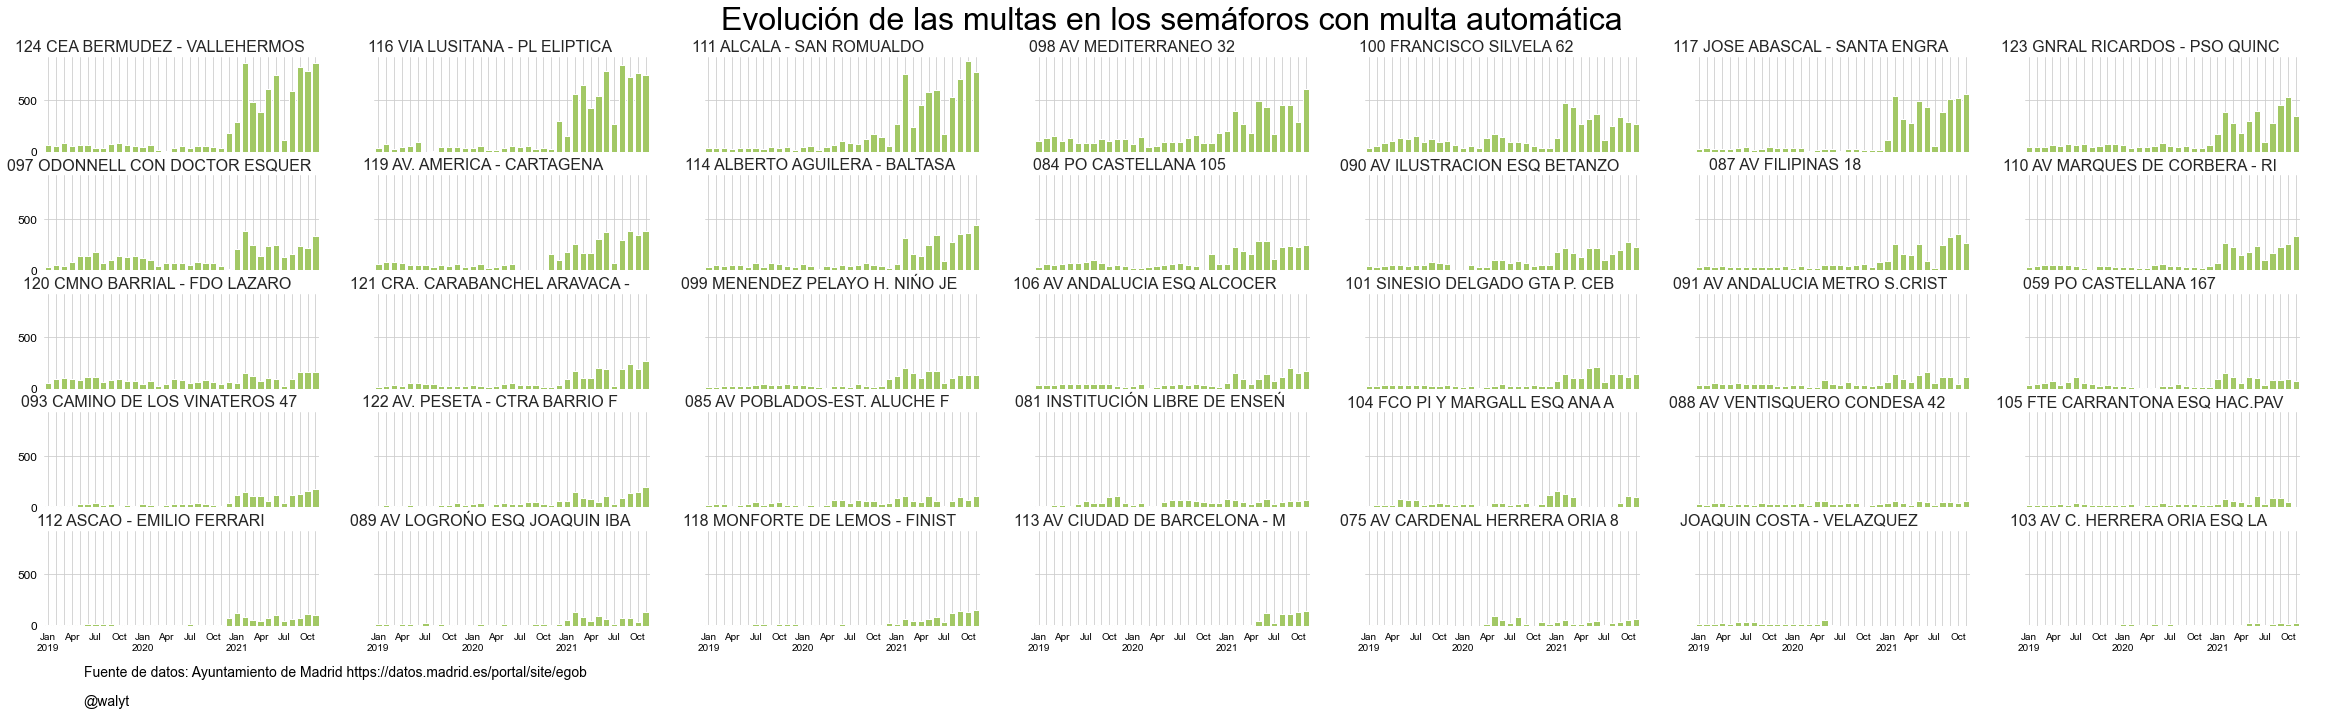

In [461]:
sns.set_style(style='white')
titulo='Evolución de las multas en los semáforos con multa automática'
g = sns.catplot(
    data=datos.loc[datos['LUGAR_norm'].isin(top_semaforos),:],x='FECHA',
    col="LUGAR_norm",
    kind='count',dodge=True,
    col_wrap=7, col_order=top_semaforos,height=2, aspect=2.4, legend=False,ci=None,
    color=color_barra[4],sharey=True   #tan solo cambiamos este parámetro
)

for ax in g.axes.flat:
    ax.xaxis.set_tick_params(labelsize=10,width=0,labelcolor=color_ejes,rotation=0)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x,v:'{}'.format(etiquetas_meses_x[x]) if x%3==0 else ''))
    ax.yaxis.set_tick_params(labelsize=12,width=0,labelcolor=color_ejes)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x,v:'{:0,.0f}'.format(x).replace(',','.')))
    ax.grid(True)
    
g.fig.suptitle(f'{titulo}',fontsize=32,color=color_titulos)
g.fig.text(x=0.05,y=.05,s=fuente,color=color_titulos,fontsize=14,ha='left')
g.fig.text(x=0.05,y=.01,s=autor,color=color_titulos,fontsize=14)
g.despine(bottom=True,left=True)
g.set_titles(col_template="{col_name}",size=16)
g.set_axis_labels("", "")
g.fig.subplots_adjust(top=.91,bottom=.12,wspace=0.2,hspace=0.25)
fichero = f'{path_proyecto}{path_img}/semaforos_top_loc_shareyTrue.png'
g.fig.savefig(fichero,dpi=288,bbox_inches='tight') 

# Multas de velocidad

Vamos a trabajar ahora con multas de `velocidad`, a ver que visualizaciones podemos conseguir. 

Ya sabemos de ejercicios anteriores que tenemos poco más de 1.5m de multas..creamos un pandas adicional para tenerlas  ya lista:

Ya sabemos del análisis inicial que tanto `VEL_LIMITE`como `VEL_CIRCULA` son de tipo `Object`, vamos a convertirlo en tipos numéricos, primero asegurando que todos los campos tienen un valor susceptible de pasar a numérico.

In [98]:
def velocidad_numerico(df):
    df['VEL_LIMITE'] = pd.to_numeric(df['VEL_LIMITE'],downcast='integer')
    df['VEL_CIRCULA'] = pd.to_numeric(df['VEL_CIRCULA'],downcast='float')
    
    return df

def filtra_numericas(df):
    return df.loc[(df['VEL_LIMITE']!='   ') & (df['VEL_CIRCULA']!='   '),:]

In [99]:
multas_velocidad = (
multas.
    loc[multas['HECHO_BOL'].isin(multas_hecho),:]. #nos quedamos con los hechos_bol más frecuentes
    pipe(hecho_bol_resumido,hechos_top).  #categorizamos por 7 categ´rias
    pipe(filtra,'Velocidad'). #nos quedamos con las de VELOCIDAD
    pipe(filtra_numericas). #nos quedamos con las que el campo VEL_LIMITE y VEL_CIRCULA no está vacío, 
    pipe(velocidad_numerico) #convertimos esos dos campos en tipo numérico
)

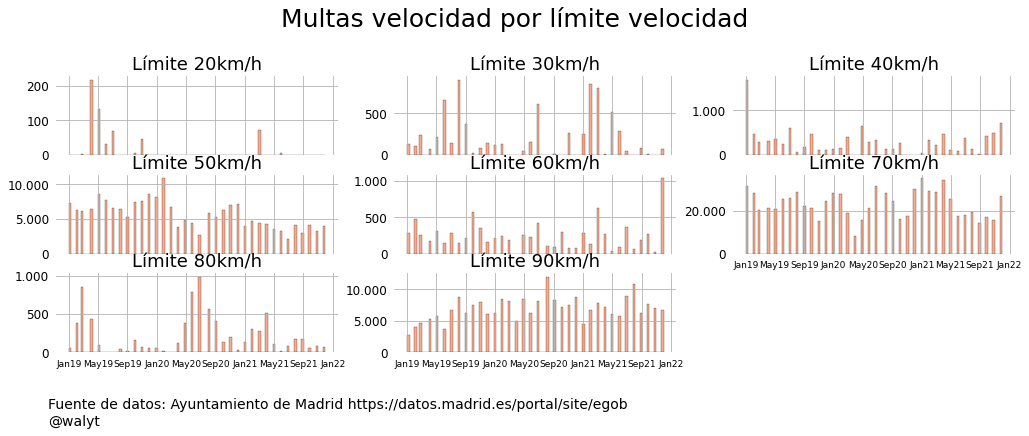

In [100]:
titulo='Multas velocidad por límite velocidad'

order_limites = [20,30,40,50,60,70,80,90]
g = sns.displot(
    data=multas_velocidad,
    x='FECHA',
    col="VEL_LIMITE",
    col_order = order_limites,
    kind='hist',
    col_wrap=3, height=2, aspect=2.4, legend=False,
    color=color_barra[1],facet_kws={'sharey':False}
)

#g = sns.FacetGrid(data=datos, col="HECHO_BOL",hue='HECHO_BOL',col_wrap=3,height=2,aspect=2.2,sharey=False)
#g.map_dataframe(sns.scatterplot, x='FECHA',y='LUGAR')

for ax in g.axes.flat:
    #ax.xaxis_date()
    ax.xaxis.set_tick_params(labelsize=9,width=0,labelcolor=color_ejes,rotation=0)
    #ax.xaxis.set_major_formatter(FuncFormatter(lambda x,v:'{}'.format(etiquetas_x[x]) if x%3==0 else ''))
    #ax.xaxis.set_major_locator(DayLocator([1]))
    ax.yaxis.set_tick_params(labelsize=12,width=0,labelcolor=color_ejes)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x,v:'{:0,.0f}'.format(x).replace(',','.')))
    ax.grid(True)
    ax.xaxis.set_major_formatter(DateFormatter('%-b%y'))
    #ax.set_xticklabels(etiquetas_x)
    #ax.set_xticks([tick for tick in ax.get_xticks() if tick % 4 == 0])
    #ax.set_yticklabels([i[:10] for i in multas_hecho])
g.fig.suptitle('{}'.format(titulo),fontsize=25,color=color_titulos)
g.fig.text(x=0.05,y=.05,s=fuente,color=color_titulos,fontsize=14,ha='left')
g.fig.text(x=0.05,y=.01,s=autor,color=color_titulos,fontsize=14)
# Tweak the supporting aspects of the plot
g.despine(bottom=True,left=True)
g.set_titles(col_template="Límite {col_name}km/h",size=18)
g.set_axis_labels("", "")
g.tight_layout()
g.fig.subplots_adjust(top=.82,bottom=.18,wspace=0.2,hspace=0.25)
fichero = f'{path_proyecto}{path_img}/velocidad_count_meses.png'
g.fig.savefig(fichero,dpi=288,bbox_inches='tight') 


Ya tenemos una primera visión,por las diferentes escalas vemos que hay mucha diferencia en las cantidades. Hagamos una gráfica de barras para chequear esta sospecha..

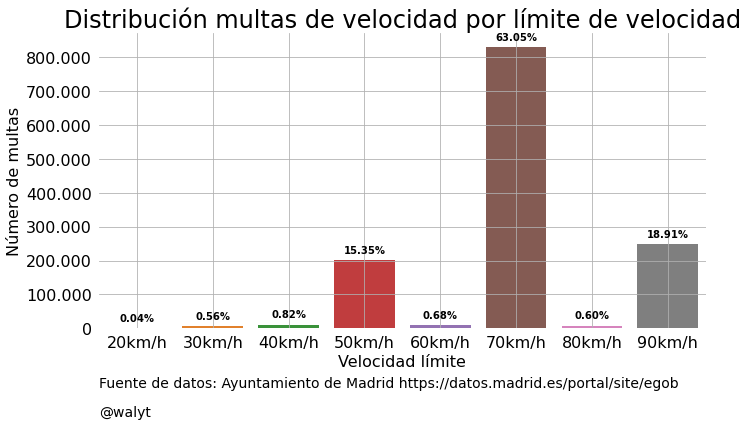

In [101]:
fig = plt.figure(1, (10,5))
ax = fig.add_subplot(1,1,1)
n_multas = multas_velocidad.shape[0]
g = sns.countplot(data=multas_velocidad,
                  x='VEL_LIMITE',ax=ax,order=order_limites)

ax.xaxis.set_tick_params(labelsize=16,width=0,labelcolor=color_ejes,rotation=0)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x,v:f'{x:,.0f}'.replace(',','.')))
ticks_x = [f'{i}km/h' for i in order_limites]
ax.set_xticklabels(ticks_x)

#ax.xaxis.set_major_locator(MonthLocator([1,4,7,10]))
ax.yaxis.set_tick_params(labelsize=16,width=0,labelcolor=color_ejes)
#ax.yaxis.set_major_formatter(FuncFormatter(lambda x,v:'{:0,.0f} km/h'.format(x)))
#ax.set_xticklabels(ticks_x)

ax.set_xlabel('Velocidad límite',size=16)
ax.set_ylabel('Número de multas',size=16)
ax.grid(axis='both')
patches=ax.patches

for i,rect in enumerate(patches):
    _,y_max = ax.get_ylim()
    height = rect.get_height()
    ax.text(rect.get_x()+rect.get_width()/2,y_max/30+height,f'{height/n_multas:0,.2%}'.replace(',','.'),ha='center', va='center',fontsize=10,color='black',weight='bold')

sns.despine(left=True,bottom=True)
ax.set_title('Distribución multas de velocidad por límite de velocidad',size=24)
ax.text(x=0,y=-.2,s=fuente,color=color_titulos,fontsize=14,ha='left',transform=ax.transAxes)
ax.text(x=0,y=-.3,s=autor,color=color_titulos,fontsize=14,transform=ax.transAxes)
#fig.suptitle(fuente,size=10,x=1,y=-0.01)
fig.tight_layout(w_pad=0,h_pad=0,pad=0)
fig.subplots_adjust(top=.82,bottom=0,wspace=0.2,hspace=0.25)
fichero = f'{path_proyecto}{path_img}/Numero_multas_limite.png'
fig.savefig(fichero,dpi=288,bbox_inches='tight') 

Efectivamente vemos que las multas de limite 70km/h se lleva un alto porcentaje del total.

Me pregunto : por cada categoría de velocidad límite: podríamos ver la distribución de la velocidad de circulación de los coches multados?

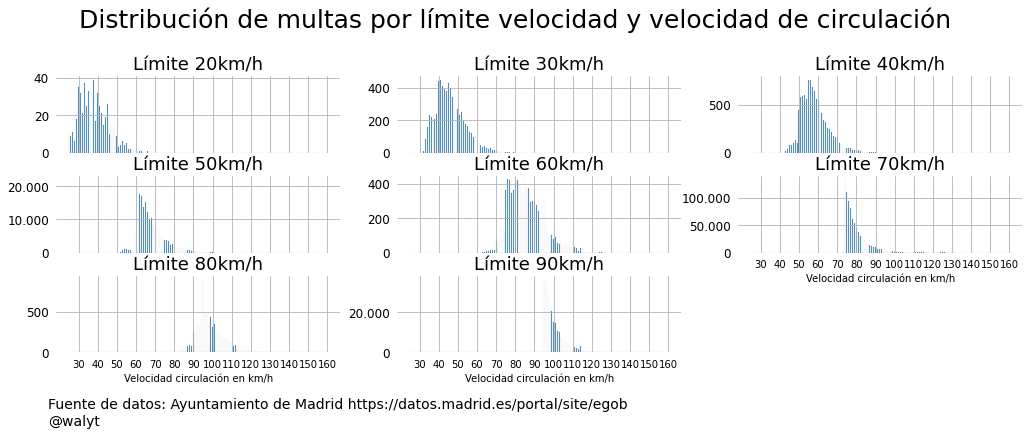

In [102]:
titulo='Distribución de multas por límite velocidad y velocidad de circulación'
g = sns.displot(
    data=multas_velocidad,
    x='VEL_CIRCULA',
    col="VEL_LIMITE",
    col_order=order_limites,
    kind='hist',
    col_wrap=3, height=2, aspect=2.4, legend=False,palette=color_barra,
    facet_kws={'sharey':False}
)



for ax in g.axes.flat:
    ax.xaxis.set_tick_params(labelsize=10,width=0,labelcolor=color_ejes,rotation=0)
    ax.yaxis.set_tick_params(labelsize=12,width=0,labelcolor=color_ejes)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x,v:'{:0,.0f}'.format(x).replace(',','.')))
    ax.grid(True)
    ax.set_xticks([30,40,50,60,70,80,90,100,110,120,130,140,150,160])
g.fig.suptitle('{}'.format(titulo),fontsize=25,color=color_titulos)
g.fig.text(x=0.05,y=.05,s=fuente,color=color_titulos,fontsize=14,ha='left')
g.fig.text(x=0.05,y=.01,s=autor,color=color_titulos,fontsize=14)
# Tweak the supporting aspects of the plot
g.despine(bottom=True,left=True)
g.set_titles(col_template="Límite {col_name}km/h",size=18)
g.set_axis_labels("Velocidad circulación en km/h", "")
g.tight_layout()
g.fig.subplots_adjust(top=.82,bottom=.18,wspace=0.2,hspace=0.3)
fichero = f'{path_proyecto}{path_img}/velocidad_distri_velocidad_circula_limite.png'
g.fig.savefig(fichero,dpi=288,bbox_inches='tight') 

aquí lo vemos..y podemos sacar algunas conclusiones:
 - Cual es la velocidad mínima a la que multan por cada categoría?..mejor, cual es la mínima, media, y máxima?

In [543]:
multas_velocidad.groupby('VEL_LIMITE')['VEL_CIRCULA'].agg([min,'mean',max])

,min,mean,max
VEL_LIMITE,,,
20,25.00,38.27,69.00
30,32.00,46.12,80.00
40,43.00,58.46,90.00
50,51.00,67.54,100.00
60,63.00,85.77,130.00
70,73.00,79.53,140.00
80,83.00,99.35,149.00
90,92.00,100.65,160.00


Esta informacón se puede visualizar también con diagramas de violín, donde veos gráficamente esa distribución. Es importante tener en cuenta que las areas de cada figura no utilizan la misma escala, tan solo vemos la distribuciuón.

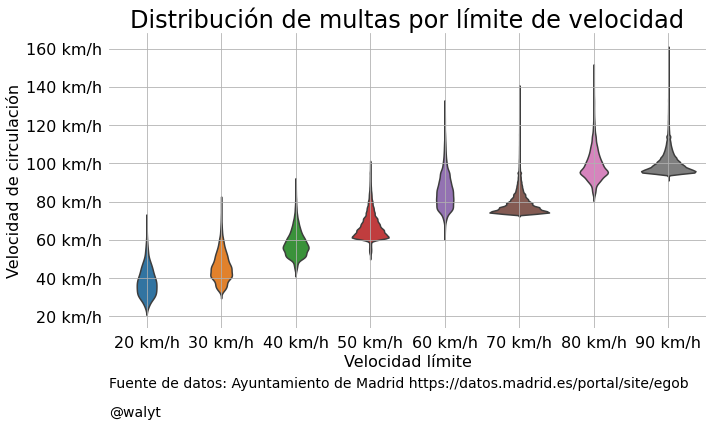

In [103]:

ticks_x = [f'{i} km/h' for i in order_limites]

fig = plt.figure(1, (10,5))
ax = fig.add_subplot(1,1,1)
g = sns.violinplot(data=multas_velocidad,scale='area',
                  inner=None,x='VEL_LIMITE',y='VEL_CIRCULA',ax=ax,order=order_limites,size=.2,lw=2)

ax.xaxis.set_tick_params(labelsize=16,width=0,labelcolor=color_ejes,rotation=0)
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x,v:'{} km/h'.format(x)))
#ax.xaxis.set_major_locator(MonthLocator([1,4,7,10]))
ax.yaxis.set_tick_params(labelsize=16,width=0,labelcolor=color_ejes)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x,v:'{:0,.0f} km/h'.format(x)))
ax.set_xticklabels(ticks_x)

ax.set_xlabel('Velocidad límite',size=16)
ax.set_ylabel('Velocidad de circulación',size=16)
ax.grid(axis='both')

sns.despine(left=True,bottom=True)
ax.set_title('Distribución de multas por límite de velocidad',size=24)
ax.text(x=0,y=-.2,s=fuente,color=color_titulos,fontsize=14,ha='left',transform=ax.transAxes)
ax.text(x=0,y=-.3,s=autor,color=color_titulos,fontsize=14,transform=ax.transAxes)
#fig.suptitle(fuente,size=10,x=1,y=-0.01)
fig.tight_layout(w_pad=0,h_pad=0,pad=0)
fig.subplots_adjust(top=.82,bottom=0,wspace=0.2,hspace=0.25)

fichero = f'{path_proyecto}{path_img}/Multas_distri_limite_circula.png'
fig.savefig(fichero,dpi=288,bbox_inches='tight') 


También podemos utilizar la funcionalidad `hue` de Seaborn para que nos muestre el reparto por ***PUNTOS*** perdidos..

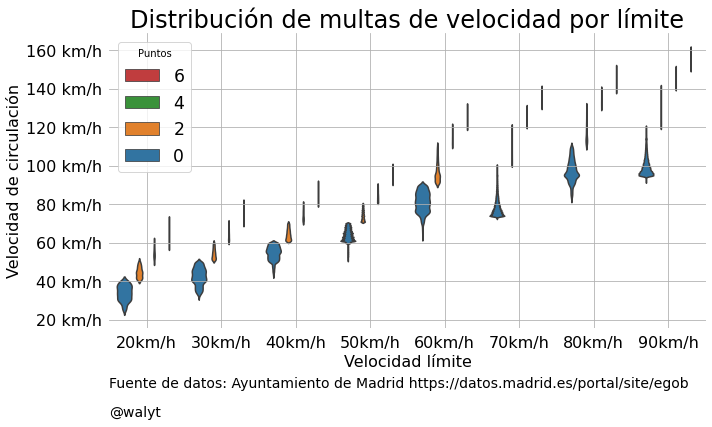

In [104]:

ticks_x = [f'{i}km/h' for i in order_limites]

fig = plt.figure(1, (10,5))
ax = fig.add_subplot(1,1,1)
g = sns.violinplot(data=multas_velocidad,
                  x='VEL_LIMITE',
                   y='VEL_CIRCULA',
                   ax=ax,
                   order=order_limites,
                   size=.2,
                   inner=None,
                   hue='PUNTOS',
                   scale='count')

ax.xaxis.set_tick_params(labelsize=16,width=0,labelcolor=color_ejes,rotation=0)
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x,v:'{} km/h'.format(x)))
#ax.xaxis.set_major_locator(MonthLocator([1,4,7,10]))
ax.yaxis.set_tick_params(labelsize=16,width=0,labelcolor=color_ejes)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x,v:'{:0,.0f} km/h'.format(x)))
ax.set_xticklabels(ticks_x)

ax.set_xlabel('Velocidad límite',size=16)
ax.set_ylabel('Velocidad de circulación',size=16)
ax.grid(axis='both')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Puntos', loc='upper left',fontsize='xx-large',ncol=1)
sns.despine(left=True,bottom=True)
ax.set_title('Distribución de multas de velocidad por límite',size=24)
ax.text(x=0,y=-.2,s=fuente,color=color_titulos,fontsize=14,ha='left',transform=ax.transAxes)
ax.text(x=0,y=-.3,s=autor,color=color_titulos,fontsize=14,transform=ax.transAxes)
#fig.suptitle(fuente,size=10,x=1,y=-0.01)
fig.tight_layout(w_pad=0,h_pad=0,pad=0)
fig.subplots_adjust(top=.82,bottom=0,wspace=0.2,hspace=0.25)

fichero = f'{path_proyecto}{path_img}/Multas_distri_limite_circula_puntos.png'
fig.savefig(fichero,dpi=288,bbox_inches='tight') 



Vemos como las multas sin PUNTOS son mayoría..

En alguna ocasión me he preguntado si realmente se está multando en Madrid en los carriles limitados a 30km/h. Vemos en la gráfica anterior que la respuesta es positiva, pero veamos de qué manera:

Vamos a limitar los datos al último año, 2021. Presentando cada ***LUGAR*** con un color diferente:

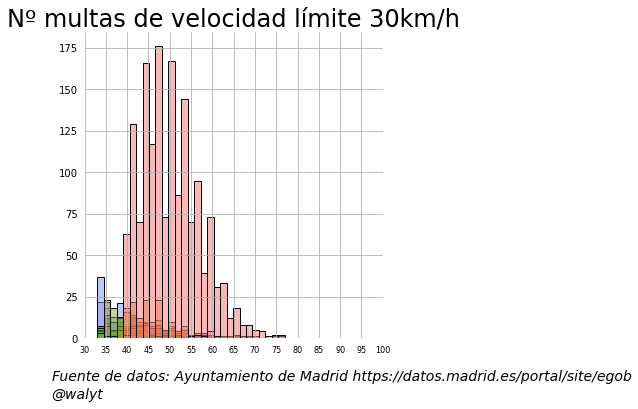

In [111]:
g = sns.displot(data=multas_velocidad.loc[(multas_velocidad['FECHA'].dt.year == 2021) & (multas_velocidad['VEL_LIMITE']==30),:],
                  x='VEL_CIRCULA',
                  color=color_multas,
                  hue='LUGAR',
                legend=False
                )

g.ax.xaxis.set_tick_params(labelsize=8,width=0,labelcolor=color_ejes,rotation=0)
g.ax.yaxis.set_tick_params(labelsize=10,width=0,labelcolor=color_ejes)
g.ax.yaxis.set_major_formatter(FuncFormatter(lambda x,v:'{:0,.0f}'.format(x)))
g.ax.xaxis.set_major_formatter(FuncFormatter(lambda x,v:'{:0,.0f}'.format(x)))
g.ax.set_xticks([30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])

g.ax.set_xlabel('',size=16)
g.ax.set_ylabel('')

g.ax.grid(axis='both')
sns.despine(left=True,bottom=True)
g.ax.set_title('Nº multas de velocidad límite 30km/h',size=24)

g.fig.text(x=0.05,y=0.0,s=fuente,color=color_titulos,fontsize=14,ha='left',fontstyle='italic')
g.fig.text(x=0.05,y=-.05,s=autor,color=color_titulos,fontsize=14,fontstyle='italic')
#fig.suptitle(fuente,size=10,x=1,y=-0.01)
fichero = f'{path_proyecto}{path_img}/multas_vel_circula_30.png'

g.fig.savefig(fichero,dpi=288,bbox_inches='tight') 


Parece que hay diferentes velocidades mínimas desde las que se comienza a multar.En algún caso desde los 40km/h, pero en otros por debajo de 35km/h. Se me ocurre que podriamos generar una rejilla con gráfico por cada ***LUGAR***, limitando a 10.

In [106]:
dfaux = multas_velocidad.loc[(multas_velocidad['FECHA'].dt.year == 2021) & (multas_velocidad['VEL_LIMITE']==30),:]
dfaux['LUGAR'] = dfaux.apply(lambda x:x['LUGAR'].lstrip().rstrip()[4:],axis=1)

/var/folders/_p/bc_h4mbs0350g3s_n60vsd3c0000gp/T/ipykernel_24815/3399572981.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfaux['LUGAR'] = dfaux.apply(lambda x:x['LUGAR'].lstrip().rstrip()[4:],axis=1)


In [107]:
top_radares_30 = dfaux.groupby('LUGAR').size().sort_values(ascending=False).index[:12]

In [108]:
def llenar_columnas(df):
    columnas = ['2021-01-01','2021-02-01','2021-03-01','2021-04-01','2021-05-01','2021-06-01','2021-07-01',
                   '2021-08-01','2021-09-01','2021-10-01','2021-11-01','2021-12-01']
    for i  in columnas:
        if i not in df.columns:
            df[i]=0
    df = df[columnas]
    return df

def alargo(df):
    return pd.melt(df,id_vars='LUGAR',value_vars=df.columns[1:])

In [109]:

df_aux = (dfaux.
 loc[dfaux['LUGAR'].isin(top_radares_30),:].
 groupby(['LUGAR','FECHA']).size().
 to_frame('size').
 reset_index().
 pivot_table(index='LUGAR',columns='FECHA',values='size').
 pipe(llenar_columnas).
 fillna(0).
 reset_index().
 pipe(alargo)
)

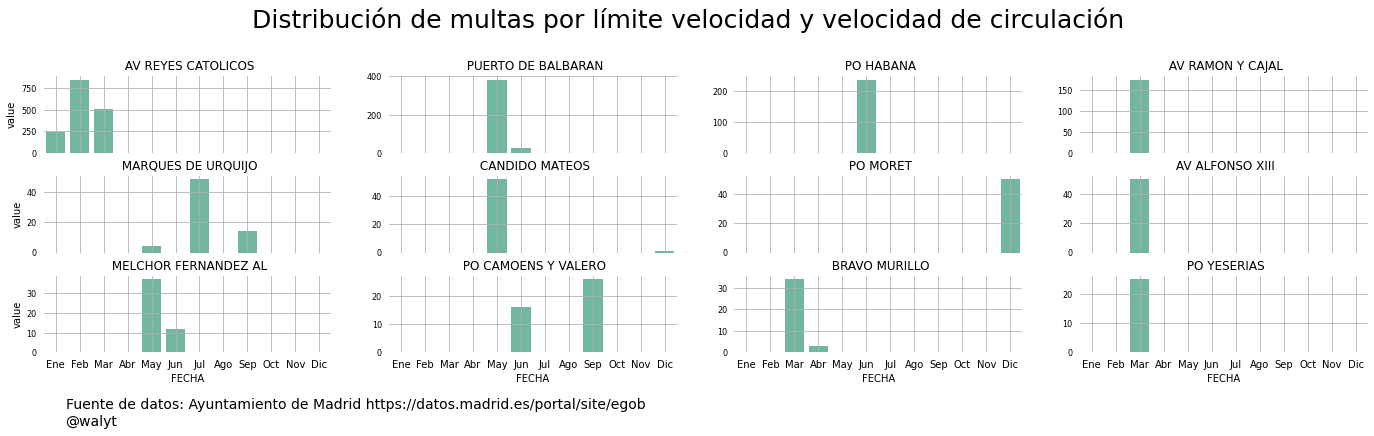

In [110]:
titulo='Distribución de multas de límite velocidad 30km/h por top localizaciones'
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.catplot(
    data=df_aux,x='FECHA',
    col="LUGAR",
    col_wrap=4,
    col_order=top_radares_30,
    y='value',
    dodge=True,
    kind='bar',
    height=2, aspect=2.4, legend=False,ci=None,estimator=sum,color=color_multas,sharey=False
)
#etiquetas_meses_x = [i.month_name() for i in df_aux['FECHA'].unique()]
for ax in g.axes.flat:
    ax.xaxis.set_tick_params(labelsize=10,width=0,labelcolor=color_ejes,rotation=0)
    ax.yaxis.set_tick_params(labelsize=8,width=0,labelcolor=color_ejes)
    ax.grid(True)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
    ax.set_xticklabels(['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic'])
    
#g.set_titles("")
#g.set(yticks=[], ylabel="")
g.fig.text(x=0.05,y=.05,s=fuente,color=color_titulos,fontsize=14,ha='left')
g.fig.text(x=0.05,y=.01,s=autor,color=color_titulos,fontsize=14)
g.set_titles(col_template="{col_name}",size=12)
g.fig.suptitle('{}'.format(titulo),fontsize=25,color=color_titulos)
g.despine(bottom=True,left=True)
#g.set_titles(col_template="Límite {col_name}km/h",size=18)
g.tight_layout()
g.fig.subplots_adjust(top=.82,bottom=.18,wspace=0.2,hspace=0.3)
fichero = f'{path_proyecto}{path_img}/velocidad_distri_velocidad_circula_limite.png'
g.fig.savefig(fichero,dpi=288,bbox_inches='tight') 

Lo que interpreto de esta

/var/folders/_p/bc_h4mbs0350g3s_n60vsd3c0000gp/T/ipykernel_24815/4157117511.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfaux['LUGAR'] = dfaux.apply(lambda x:x['LUGAR'].lstrip().rstrip()[4:],axis=1)
/opt/anaconda3/envs/covid/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 54.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/covid/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 9.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


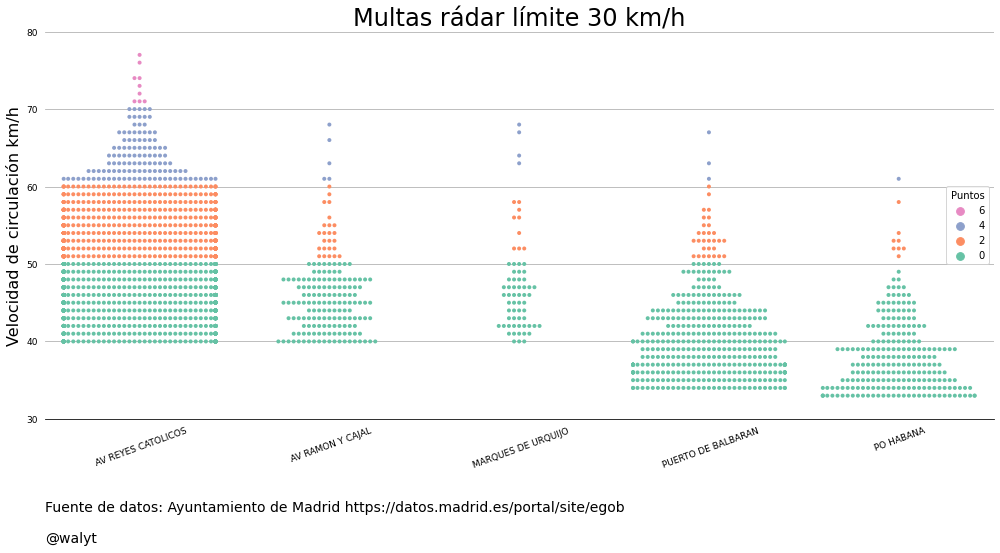

In [112]:
dfaux = multas_velocidad.loc[(multas_velocidad['FECHA'].dt.year == 2021) & (multas_velocidad['VEL_LIMITE']==30),:]
dfaux['LUGAR'] = dfaux.apply(lambda x:x['LUGAR'].lstrip().rstrip()[4:],axis=1)

fig = plt.figure(1, (14,8))
ax = fig.add_subplot(1,1,1)
g = sns.swarmplot(data=dfaux.loc[(dfaux['LUGAR'].isin(top_radares_30[:5])),:],
                  x='LUGAR',y='VEL_CIRCULA',ax=ax,palette=color_barra,hue='PUNTOS',s=4)

ax.yaxis.set_tick_params(labelsize=9,width=0,labelcolor=color_ejes,rotation=0)
ax.xaxis.set_tick_params(labelsize=9,width=0,labelcolor=color_ejes,rotation=20)
ax.set_yticks([30,40,50,60,70,80])
ax.set_xlabel('',size=16)
ax.set_ylabel('Velocidad de circulación km/h',size=16)
ax.grid(axis='y')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Puntos', loc='right')
sns.despine(left=True,bottom=False)
ax.set_title('Multas rádar límite 30 km/h',size=24)
ax.text(x=-.5,y=18,s=fuente,color=color_titulos,fontsize=14,ha='left')
ax.text(x=-.5,y=14,s=autor,color=color_titulos,fontsize=14)
#fig.suptitle(fuente,size=10,x=1,y=-0.01)
fig.tight_layout()
fichero = f'{path_proyecto}{path_img}/distri_multas_30.png'
fig.savefig(fichero,dpi=288,bbox_inches='tight') 

## y podemos buscar los radares que más multas

In [113]:
top_radares = list(multas_velocidad.groupby('LUGAR').size().sort_values(ascending=False).index[:12])

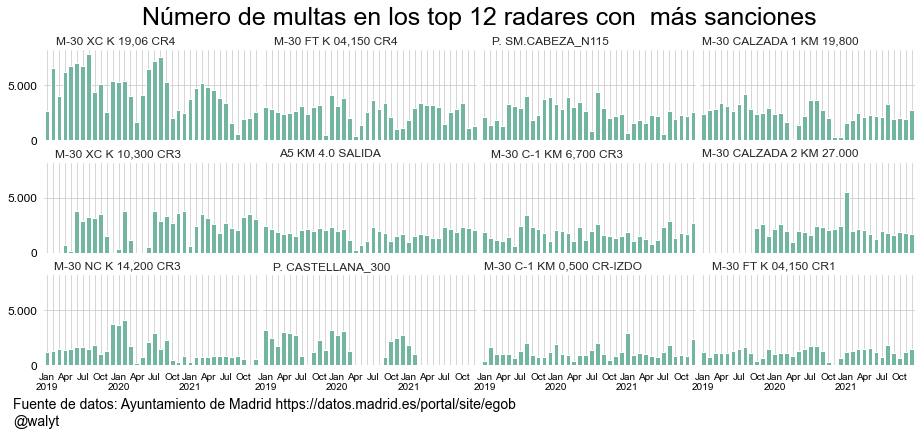

In [114]:

sns.set_style(style='white')
titulo = 'Número de multas en los top 12 radares con  más sanciones'
etiquetas_meses_x = [i.strftime('%b') if i.strftime('%-m')!='1' else i.strftime('%b\n%Y') for i in multas.groupby(['FECHA']).sum().index]

g = sns.catplot(data= multas_velocidad.loc[multas_velocidad['LUGAR'].isin(top_radares),:].sort_values('FECHA'),
            x='FECHA',
            col='LUGAR',
            ci=None,
            kind='count',
            col_wrap=4,
            height=2,
            aspect=1.8,
            col_order=top_radares,
            dodge=False,
            color=color_multas
             )
(g.
 despine(bottom=True,left=True).
 set_axis_labels("","").
 set_titles("{col_name}",size=12)
)
for ax in g.axes.flat:
    ax.xaxis.set_tick_params(labelsize=10,width=0,labelcolor=color_ejes,rotation=0)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x,v:'{}'.format(etiquetas_meses_x[x]) if x%3==0 else ''))
    ax.yaxis.set_tick_params(labelsize=12,width=0,labelcolor=color_ejes)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x,v:'{:0,.0f}'.format(x).replace(',','.')))
    ax.grid(axis='both')
g.fig.suptitle('{}'.format(titulo),fontsize=25,color=color_titulos)
g.fig.text(x=0.05,y=.05,s=fuente,color=color_titulos,fontsize=14,ha='left')
g.fig.text(x=0.05,y=.01,s=autor,color=color_titulos,fontsize=14)    
g.fig.subplots_adjust(top=.88,bottom=.15,wspace=0.02,hspace=0.25)
fichero = f'{path_proyecto}{path_img}/multas_top_radares.png'
g.fig.savefig(fichero,bbox_inches = 'tight')
    

# Análisis multas de alcohol

In [115]:
multas_alcohol = multas.loc[multas['HECHO_BOL'].isin(multas_hecho),:].pipe(hecho_bol_resumido,hechos_top).pipe(filtra,'Alcohol')


In [116]:
multas_alcohol

,CALIFICACION,LUGAR,FECHA,HORA,IMP_BOL,DESCUENTO,PUNTOS,DENUNCIANTE,HECHO_BOL,VEL_LIMITE,VEL_CIRCULA,COORDENADA_X,COORDENADA_Y,HECHO_BOL_resumido
6597195,MUY GRAVE,CA M-22 S/N,2019-01-01,1900-01-01 09:19:00,"1,000.00",SI,6,POLICIA MUNICIPAL,CONDUCIR CON UNA TASA DE ALCOHOLEMIA NO PERMIT...,,,,,Alcohol
6605600,MUY GRAVE,CALLE 30 AV PEŃA PRIETA,2019-01-01,1900-01-01 05:04:00,"1,000.00",SI,6,POLICIA MUNICIPAL,CONDUCIR CON UNA TASA DE ALCOHOLEMIA NO PERMIT...,,,,,Alcohol
6605629,MUY GRAVE,AV PALOMERAS 54,2019-01-01,1900-01-01 22:27:00,"1,000.00",SI,6,POLICIA MUNICIPAL,INCUMPLIR LA OBLIGACIÓNDE SOMETERSE A LAS PRUE...,,,,,Alcohol
6605091,MUY GRAVE,MENDIVIL-GERARDO RUEDA,2019-01-01,1900-01-01 01:53:00,"1,000.00",SI,6,POLICIA MUNICIPAL,CONDUCIR CON UNA TASA DE ALCOHOLEMIA NO PERMIT...,,,,,Alcohol
6605107,MUY GRAVE,AV CIUDAD DE BARCELONA 5,2019-01-01,1900-01-01 06:25:00,"1,000.00",SI,6,POLICIA MUNICIPAL,CONDUCIR CON UNA TASA DE ALCOHOLEMIA NO PERMIT...,,,,,Alcohol
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128734,MUY GRAVE,"M 30 KM 7,200 LAT CALZADA 1",2021-12-01,1900-01-01 22:27:00,"1,000.00",SI,6,POLICIA MUNICIPAL,CONDUCIR CON UNA TASA DE ALCOHOL NO PERMITIDA ...,,,,,Alcohol
128700,MUY GRAVE,M 30 LATERAL CALZADA 1,2021-12-01,1900-01-01 10:43:00,"1,000.00",SI,6,POLICIA MUNICIPAL,CONDUCIR CON UNA TASA DE ALCOHOL NO PERMITIDA ...,,,,,Alcohol
129236,MUY GRAVE,PO PONTONES 22,2021-12-01,1900-01-01 11:00:00,"1,000.00",SI,0,POLICIA MUNICIPAL,CONDUCIR CON UNA TASA DE ALCOHOL NO PERMITIDA ...,,,,,Alcohol
129279,MUY GRAVE,PEŃA TREVINCA SN CNP,2021-12-01,1900-01-01 02:05:00,"1,000.00",SI,6,POLICIA MUNICIPAL,CONDUCIR CON UNA TASA DE ALCOHOL NO PERMITIDA ...,,,,,Alcohol


In [117]:
top_alcohol = multas_alcohol['LUGAR'].value_counts().index[:10]

In [118]:
multas_alcohol[multas_alcohol['LUGAR'].str.contains('TOBALINA')].groupby(['LUGAR']).size().sort_values(ascending=False)

LUGAR
VALLE DE TOBALINA-ACEBEDA                   113
ACEBEDA-VALLE DE TOBALINA                    55
VALLE DE TOBALINA SN                         38
VALLE DE TOBALINA 1                          16
VALLE DE TOBALINA                            11
VALLE DE TOBALINA-RESINA                      9
VALLE DE TOBALINA 16                          3
AV REAL PINTO-VALLE TOBALINA                  2
VALLE DE TOBALINA 9-ACEBEDA                   1
VALLE TOBALINA-AV REAL PINTO                  1
VALLE TOBALINA F 5                            1
VALLE DE TOBALINA-ACEBEDO                     1
VALLE DE TOBALINA METRO                       1
VALLE DE TOBALINA 54                          1
VALLE DE TOBALINA 58                          1
VALLE DE TOBALINA 50                          1
VALLE DE TOBALINA 36                          1
VALLE DE TOBALINA 30                          1
VALLE DE TOBALINA 3                           1
VALLE DE TOBALINA 20                          1
VALLE DE TOBALINA 10              

In [119]:
norm_lugares = {
    ('CASTILLA', 'TUNEL') : 'PZ CASTILLA',
    ('CASTELLANA','CASTILLA'): 'PZA CASTILLA',
    ('PZ','CASTILLA'): 'PZA CASTILLA',
    ('PRINCESA','88'):'CALLE PRINCESA',
     ('PRINCESA','56'):'CALLE PRINCESA',
     ('PRINCESA','94'):'CALLE PRINCESA',
     ('PRINCESA','92'):'CALLE PRINCESA',
     ('PRINCESA','68'):'CALLE PRINCESA',
     ('PRINCESA','38'):'CALLE PRINCESA',
     ('PRINCESA','87'):'CALLE PRINCESA',
     ('PRINCESA','89'):'CALLE PRINCESA',
     ('ALMAGRO','44'):'CALLE ALMAGRO',
    ('ALMAGRO','42'):'CALLE ALMAGRO',
    ('ALMAGRO','29'):'CALLE ALMAGRO',
    ('ALMAGRO','33'):'CALLE ALMAGRO',
    ('ALMAGRO','31'):'CALLE ALMAGRO',
    ('ALMAGRO','40'):'CALLE ALMAGRO',
    ('ALMAGRO','4'):'CALLE ALMAGRO',
    ('ALMAGRO','18'):'CALLE ALMAGRO',
    ('ALMAGRO','5'):'CALLE ALMAGRO',
    ('ALMAGRO','7'):'CALLE ALMAGRO',
    ('EMILIO','CASTELAR'):'GTA EMILIO CASTELAR',
    ('COLON','GENOVA'):'PZ COLON-GENOVA',
    ('PLOMO',' '):'PLOMO, 14',
    ('PLOMO','14'):'PLOMO, 14',
    ('TOBALINA',' '):'CALLE VALLE DE TOBALINA',
    ('TOBALINA','ACEBEDA'):'CALLE VALLE DE TOBALINA',
}

In [120]:
for i in multas_alcohol.index:
    for clave in norm_lugares.keys():
        if (clave[0] in multas_alcohol.loc[i,'LUGAR']) and (clave[1] in multas_alcohol.loc[i,'LUGAR']):
            multas_alcohol.loc[i,'LUGAR'] = norm_lugares[clave]

In [121]:
top_alcohol = multas_alcohol['LUGAR'].value_counts().index[:12]

In [122]:
def agrupar_lugar(df):
    return df.groupby(['HORA','LUGAR'])[['IMP_BOL','PUNTOS']]

def alargo(df):
    return pd.melt(df,id_vars='LUGAR',value_vars=df.columns[1:])


def llenar_columnas(df):
    columnas = [np.datetime64(f'1900-01-01 {i:02}:00:00') for i in range(24)]
    for i  in columnas:
        if i not in df.columns:
            df[i]=0
    df = df[columnas]
    return df

In [123]:
(   multas_alcohol.
    loc[multas_alcohol['LUGAR'].isin(top_alcohol),:].loc[multas_alcohol['LUGAR'].str.contains('CASTILLA'),:].
 set_index(['LUGAR','HORA']).
 groupby([pd.Grouper(level='LUGAR'),pd.Grouper(level='HORA',freq='H')]).
 size().
 to_frame('size').
 reset_index()
)

,LUGAR,HORA,size
0,PZA CASTILLA,1900-01-01 00:00:00,23
1,PZA CASTILLA,1900-01-01 01:00:00,27
2,PZA CASTILLA,1900-01-01 02:00:00,27
3,PZA CASTILLA,1900-01-01 03:00:00,8
4,PZA CASTILLA,1900-01-01 04:00:00,14
5,PZA CASTILLA,1900-01-01 05:00:00,4
6,PZA CASTILLA,1900-01-01 06:00:00,70
7,PZA CASTILLA,1900-01-01 07:00:00,290
8,PZA CASTILLA,1900-01-01 08:00:00,103
9,PZA CASTILLA,1900-01-01 09:00:00,11


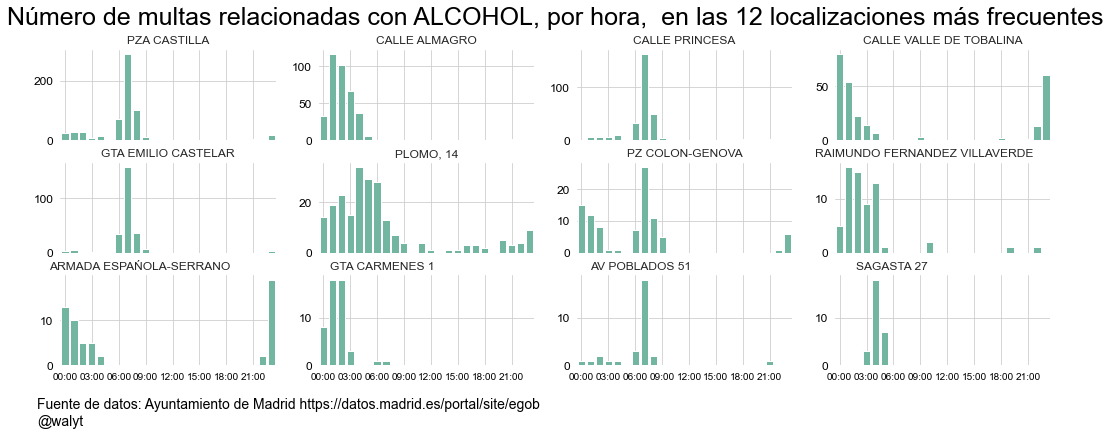

In [124]:
sns.set_style(style='white')
titulo = 'Número de multas relacionadas con ALCOHOL, por hora,  en las 12 localizaciones más frecuentes'
horas = [f'{i:02}:00' for i in range(24)]

g = sns.catplot(data= multas_alcohol.
    loc[multas_alcohol['LUGAR'].isin(top_alcohol),:].
 set_index(['LUGAR','HORA']).
 groupby([pd.Grouper(level='LUGAR'),pd.Grouper(level='HORA',freq='H')]).
 size().
 to_frame('size').
 reset_index().
 pivot_table(index='LUGAR',columns='HORA',values='size').
 pipe(llenar_columnas).
 fillna(0).
 reset_index().
 pipe(alargo),
            x='HORA',
            col='LUGAR',
            y='value',
            kind='bar',
            col_wrap=4,
            height=2,
            aspect=2,
            col_order=top_alcohol,
                estimator=sum,
            dodge=True,
            color=color_multas,sharey=False
             )

(g.
 despine(bottom=True,left=True).
 set_axis_labels("","").
 set_titles("{col_name}",size=12)
)
for ax in g.axes.flat:
    ax.xaxis.set_tick_params(labelsize=10,width=0,labelcolor=color_ejes,rotation=0)
    ax.set_xticks([tick for tick in ax.get_xticks() if tick % 3 == 0])
    ax.set_xticklabels(horas[::3])

    #ax.xaxis.set_major_formatter(FuncFormatter(lambda x,v:'{}'.format(x)))
    ax.yaxis.set_tick_params(labelsize=12,width=0,labelcolor=color_ejes)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x,v:'{:0,.0f}'.format(x).replace(',','.')))
    ax.grid(axis='both')
g.fig.suptitle('{}'.format(titulo),fontsize=25,color=color_titulos)
g.fig.text(x=0.05,y=.05,s=fuente,color=color_titulos,fontsize=14,ha='left')
g.fig.text(x=0.05,y=.01,s=autor,color=color_titulos,fontsize=14)    
g.fig.subplots_adjust(top=.88,bottom=.15,wspace=0.2,hspace=0.25)
fichero = f'{path_proyecto}{path_img}/multas_top_alcohol.png'
g.fig.savefig(fichero,bbox_inches = 'tight')
    